# Plotting fire frequencies and burned areas at different spatiotemporal scales

Authors: Jatan Buch (v1, 220207) || (v2, 220216) || (v3, 220414) || (v4, 220420) || (v5, 220607)

## 1. Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from plot_params import params
import matplotlib.pylab as pylab
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import shap

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
fire_file= "../data/burnarea_12km.nc"
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
forest_reg_arr= np.array([0, 1, 2, 3, 4, 6, 7, 8, 10])
desert_reg_arr= np.array([5, 9, 11, 12, 15, 16, 17])
plain_reg_arr= np.array([13, 14])

startmon= 0
startyr= int((startmon)/12 + 1984)
final_month= 444
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr=  np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12)

## 2. Grid scale frequency

This module includes all plotting functions for the grid scale fire frequencies predicted using mixture density networks (MDN) and MLPs (DNN). Briefly, the workflow is as follows, 

2.1) load the output from various model runs (see `ml_grid_model.ipynb`) including: downsampled (ds), downsamped with alternate training range (alt_ds), and leave-one-region-out (loro) run; </br>
2.2) plot the cumulative annual and monthly fire frequencies for the entire western US study region; </br>
2.3) plot the monthly and annual fire frequencies for individual [L3 ecoregions](https://www.epa.gov/eco-research/level-iii-and-iv-ecoregions-continental-united-states).</br>

All the custom functions called below maybe found in the `ml_utils.py` library file. 

### 2.1 Loading model output

In [275]:
mdn_ds_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_05_30_22.h5') #03_01_22, 04_21_22; 05_30_22 --> with 2020; 04_17_22 --> with threshold
mdn_ds_freq_groups= mdn_ds_freq_df.groupby('reg_indx')
mdn_alt_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_05_31_22.h5') 
mdn_alt_freq_groups= mdn_alt_freq_df.groupby('reg_indx')
mdn_zipd_mod= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_05_30_22', custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})

# mdn_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_mon_fire_freq_02_27_22_it_2_8192_0.3.h5') #['02_27_22', 2, 8192, '0.3']
# mdn_freq_groups= mdn_freq_df.groupby('reg_indx')
# mdn_alt_ds_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_03_02_22.h5') # leaves training data ut starting from month 264 instead of 372
# mdn_alt_ds_freq_groups= mdn_ds_freq_df.groupby('reg_indx')
# dnn_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/dnn_mon_fire_freq_03_01_22_it_12_8192_0.3.h5')
# dnn_freq_groups= dnn_freq_df.groupby('reg_indx')
# dnn_ds_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/dnn_ds_mon_fire_freq_02_25_22.h5')
# dnn_ds_freq_groups= dnn_ds_freq_df.groupby('reg_indx')
# mdn_loro_freq_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_03_03_22.h5') # loro; currently only has region 7

In [276]:
mdn_mon_freq_df, mdn_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_ds_freq_df, n_regs= 18, tot_months= 444, test_start= 420, test_tot= 12, ml_model= 'mdn') #debug= True, regindx= 7, arg_arr= ['linear', 'mean', 'mean'])
mdn_mon_freq_groups= mdn_mon_freq_df.groupby('reg_indx')
mdn_ann_freq_groups= mdn_ann_freq_df.groupby('reg_indx')

mdn_alt_mon_freq_df, mdn_alt_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_alt_freq_df, n_regs= 18, tot_months= 444, test_start= 432, test_tot= 12, ml_model= 'mdn') 
mdn_alt_mon_freq_groups= mdn_alt_mon_freq_df.groupby('reg_indx')
mdn_alt_ann_freq_groups= mdn_alt_ann_freq_df.groupby('reg_indx')

### 2.2 WUS frequencies

In [6]:
tot_mon_obs_freq_arr, tot_mon_pred_freq_arr, tot_mon_pred_high_2sig_arr, tot_mon_pred_low_2sig_arr, \
        tot_ann_obs_freq_arr, tot_ann_pred_freq_arr, tot_ann_pred_high_2sig_arr, tot_ann_pred_low_2sig_arr= cumm_fire_freq_func(mdn_mon_freq_df, mdn_ann_freq_df, \
                                                                                                                optflag= False)

tot_mon_freq_r= stats.pearsonr(np.sum(tot_mon_obs_freq_arr, axis= 0), np.sum(tot_mon_pred_freq_arr, axis= 0))[0]
tot_ann_freq_r= stats.pearsonr(np.sum(tot_ann_obs_freq_arr, axis= 0), np.sum(tot_ann_pred_freq_arr, axis= 0))[0]

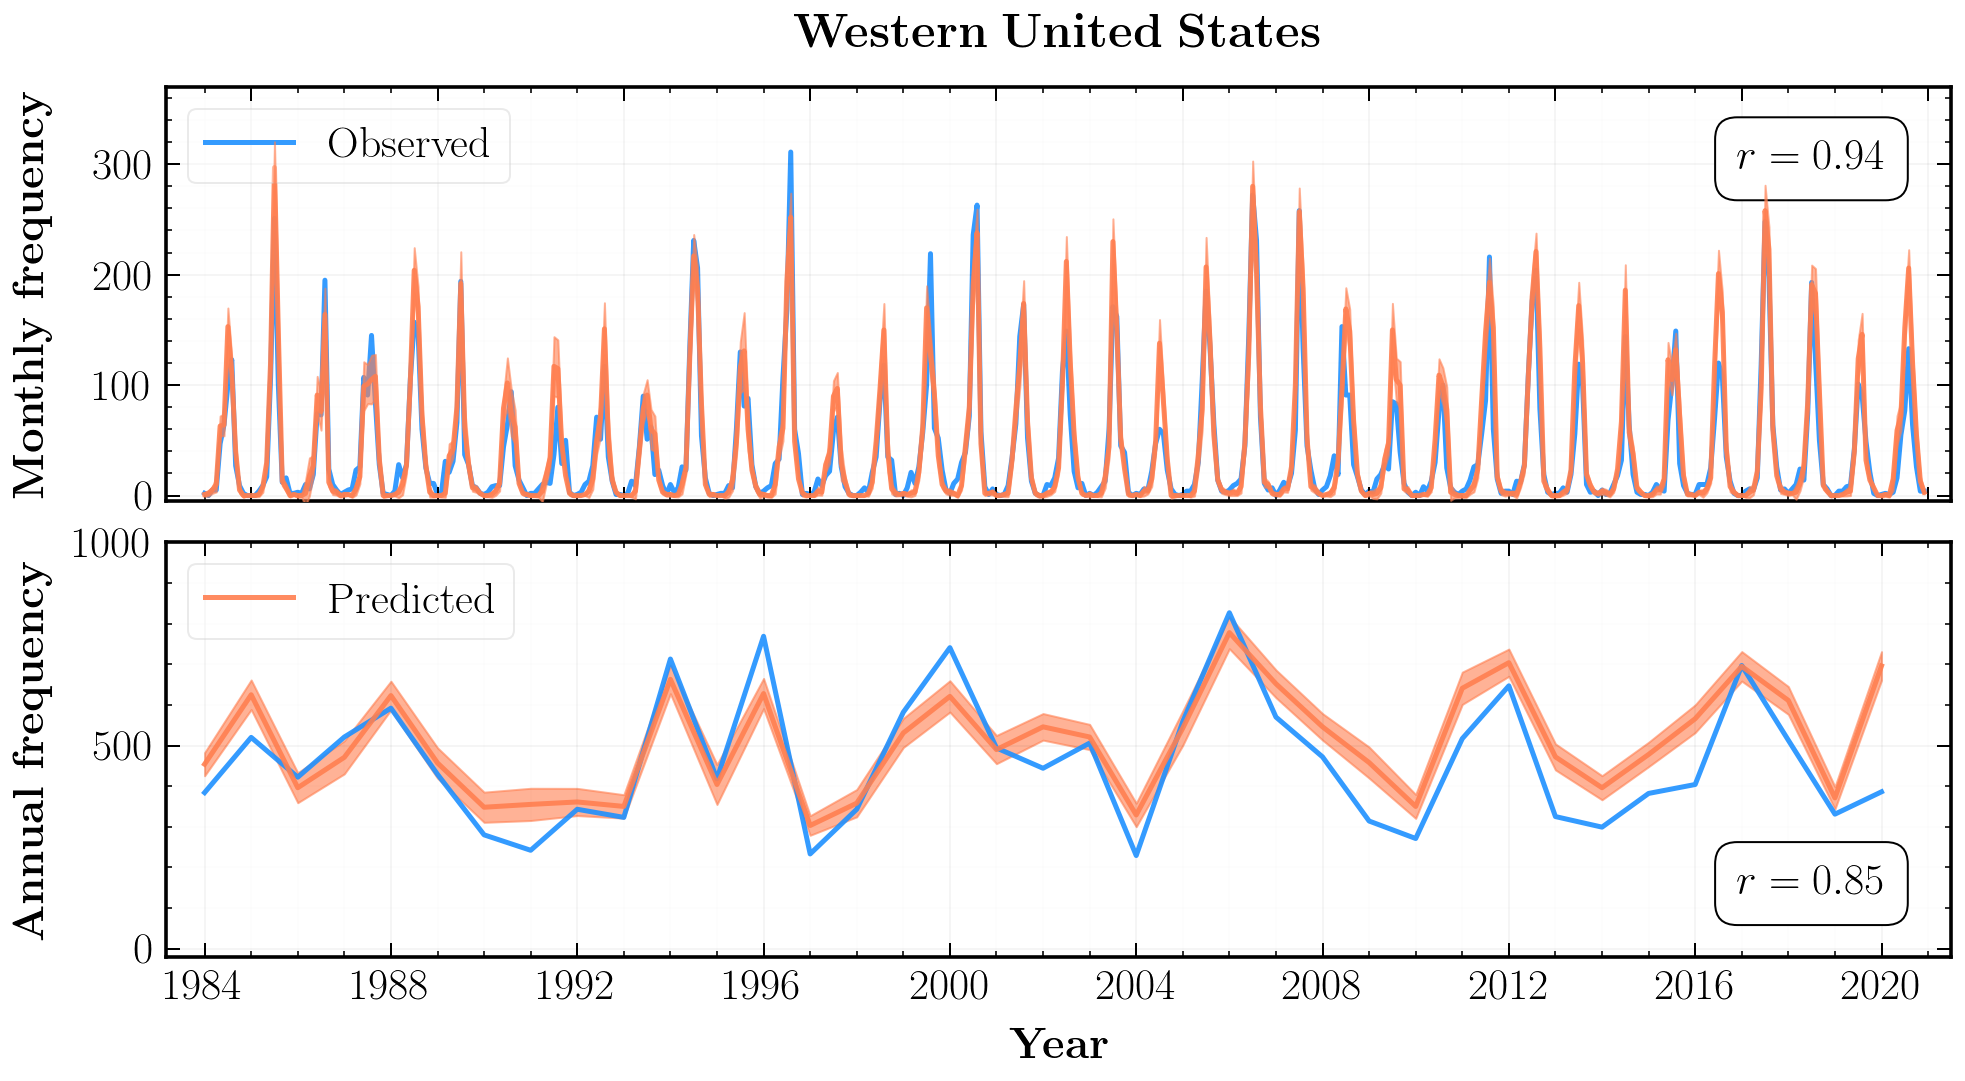

In [7]:
fig, ax= plt.subplots(2, 1, figsize=(16, 8))

ax[1].plot(yr_arr[:-1], np.sum(tot_ann_obs_freq_arr, axis= 0), color= 'dodgerblue');
ax[1].plot(yr_arr[:-1], np.sum(tot_ann_pred_freq_arr, axis= 0), color= 'coral', label= 'Predicted');
ax[1].fill_between(yr_arr[:-1], tot_ann_pred_high_2sig_arr, tot_ann_pred_low_2sig_arr, color= 'coral', alpha= 0.6)
ax[1].set_ylabel(r'{\bf Annual frequency}', fontsize= 22);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_xticks((year_arr - 1984)*12);
ax[1].set_xticklabels(year_arr)
ax[1].set_ylim(-20, 1000);
ax[1].set_xlim(-10, 450);
ax[1].text(0.88, 0.15, r'$r = %.2f$'%tot_ann_freq_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
ax[1].legend(loc='upper left', frameon= True, fontsize= 22);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[0].plot(month_arr, np.sum(tot_mon_obs_freq_arr, axis= 0), color= 'dodgerblue', label= 'Observed', zorder= 1);
ax[0].plot(month_arr, np.sum(tot_mon_pred_freq_arr, axis= 0), color= 'coral');
ax[0].fill_between(month_arr, tot_mon_pred_high_2sig_arr, tot_mon_pred_low_2sig_arr, color= 'coral', alpha= 0.6, zorder= 10)
ax[0].set_title(r'${\bf Western \ United \ States}$', fontsize= 24, pad= 20);
ax[0].set_ylabel(r'{\bf Monthly frequency}', fontsize= 22, labelpad= 20);
ax[0].set_xticks((year_arr - 1983)*12);
ax[0].set_ylim(-5, 370);
ax[0].set_xlim(-10, 450);
ax[0].set_xticklabels([])
ax[0].text(0.88, 0.8, r'$r = %.2f$'%tot_mon_freq_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].legend(loc='upper left', frameon= True, fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../paper_plots/ml_fire_freq_wus.pdf', bbox_inches='tight', dpi= 300);

### 2.3 Regional frequencies

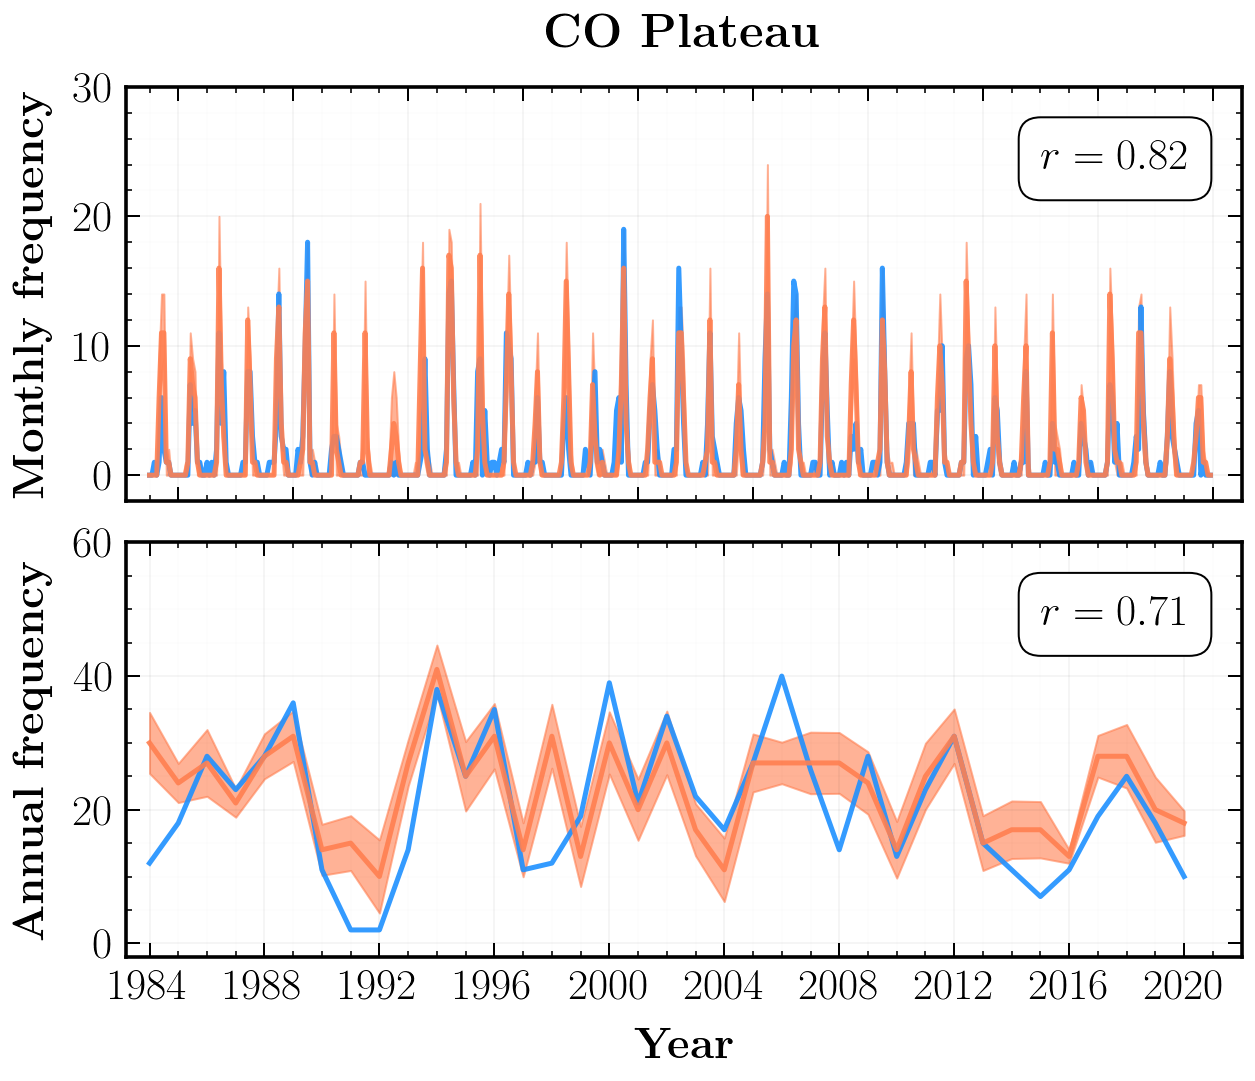

In [313]:
fig, ax= plt.subplots(2, 1, figsize=(10, 8))

regindx= 16
mon_freq_groups= mdn_mon_freq_groups
ann_freq_groups= mdn_ann_freq_groups
reg_mon_r_calib= stats.pearsonr(mon_freq_groups.get_group(regindx)['obs_freq'], mon_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
reg_ann_r_calib= stats.pearsonr(ann_freq_groups.get_group(regindx)['obs_freq'], ann_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
pos_arr= [[0.8, 0.08], [0.82, 0.8]]
pred_ann_low_2sig= ann_freq_groups.get_group(regindx)['pred_low_2sig']
pred_ann_low_2sig[pred_ann_low_2sig < 0]= 0

ax[0].plot(month_arr, mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2.5); #, label= 'Observed'
ax[0].plot(month_arr, mon_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', label= 'Predicted', lw= 2.5); # label= 'Predicted'
ax[0].fill_between(month_arr, mon_freq_groups.get_group(regindx)['pred_high_2sig'], mon_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'coral', alpha= 0.6)
ax[0].set_ylabel(r'{\bf Monthly frequency}', fontsize= 22, labelpad= 10);
ax[0].set_ylim(-2, 30);
ax[0].set_xlim(-10, 456);
ax[0].set_xticks((year_arr - 1983)*12 + startmon);
ax[0].set_xticklabels([])
ax[0].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_mon_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].set_title(r'{\bf %s}'%reg_name[regindx], fontsize= 24, pad= 20);
#ax[0].legend(loc='upper left', frameon= True, fontsize= 20);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[1].plot(yr_arr[:-1], ann_freq_groups.get_group(regindx)['obs_freq'], color= 'dodgerblue', lw= 2.5);
ax[1].plot(yr_arr[:-1], ann_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2.5, label= 'Predicted');
ax[1].fill_between(yr_arr[:-1], ann_freq_groups.get_group(regindx)['pred_high_2sig'], pred_ann_low_2sig, color= 'coral', alpha= 0.6);
ax[1].set_ylabel(r'{\bf Annual frequency}', fontsize= 22);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_ylim(-2, 60);
ax[1].set_xlim(-10, 456);
ax[1].set_xticks((year_arr - startyr)*12 + startmon);
ax[1].set_xticklabels(year_arr)
ax[1].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_ann_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
#ax[1].legend(loc='upper left', frameon= True, fontsize= 20);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#fig.savefig('../paper_plots/ml_fire_freq_colplateau.pdf', bbox_inches='tight', dpi= 300); #bbox_inches='tight',

In [128]:
for r in range(18):
    chisq_freq= chi_sq_func(mdn_groups= mdn_ann_freq_groups, regindx= r+1, dict_flag= 'freq')
    dof= len(chisq_freq) - 3
    chisq_freq_dof= min(np.sum(chi_sq_func(mdn_groups= mdn_ann_freq_groups, regindx= r+1, dict_flag= 'freq'))/dof, \
                                np.sum(chi_sq_func(mdn_groups= mdn_alt_ann_freq_groups, regindx= r+1, dict_flag= 'freq'))/dof)
    
    print("%s (1984-2020) "%reg_name[r+1] + "ann_r:%.2f"%max(stats.pearsonr(mdn_ann_freq_groups.get_group(r+1)['obs_freq'], \
                            mdn_ann_freq_groups.get_group(r+1)['pred_mean_freq'])[0], stats.pearsonr(mdn_alt_ann_freq_groups.get_group(r+1)['obs_freq'], \
                            mdn_alt_ann_freq_groups.get_group(r+1)['pred_mean_freq'])[0]) + " chi_sq: %.2f"%chisq_freq_dof)

Sierra Nevada (1984-2020) ann_r:0.70 chi_sq: 26.09
North Coast (1984-2020) ann_r:0.68 chi_sq: 105.63
Central Coast (1984-2020) ann_r:0.46 chi_sq: 73.75
South Coast (1984-2020) ann_r:0.61 chi_sq: 39.74
Pacific NW (1984-2020) ann_r:0.70 chi_sq: 11.29
Columbia Plateau (1984-2020) ann_r:0.78 chi_sq: 14.49
Northern Rockies (1984-2020) ann_r:0.89 chi_sq: 10.70
Middle Rockies (1984-2020) ann_r:0.85 chi_sq: 25.39
Southern Rockies (1984-2020) ann_r:0.82 chi_sq: 9.95
AM Semidesert (1984-2020) ann_r:0.88 chi_sq: 17.36
AZ/NM Mts. (1984-2020) ann_r:0.72 chi_sq: 44.31
IM Semidesert (1984-2020) ann_r:0.66 chi_sq: 35.64
IM Desert (1984-2020) ann_r:0.80 chi_sq: 34.57
Northern Great Plains (1984-2020) ann_r:0.87 chi_sq: 823.16
High Plains (1984-2020) ann_r:0.65 chi_sq: 143.09
Colorado Plateau (1984-2020) ann_r:0.71 chi_sq: 12.01
SW Tablelands (1984-2020) ann_r:0.67 chi_sq: 152.88
CH Desert (1984-2020) ann_r:0.62 chi_sq: 69.16


#### Monthly

In [8]:
ind_grid_1= [[1, 6], [7, 8]]
ind_grid_2= [[11, 12], [13, 14]]

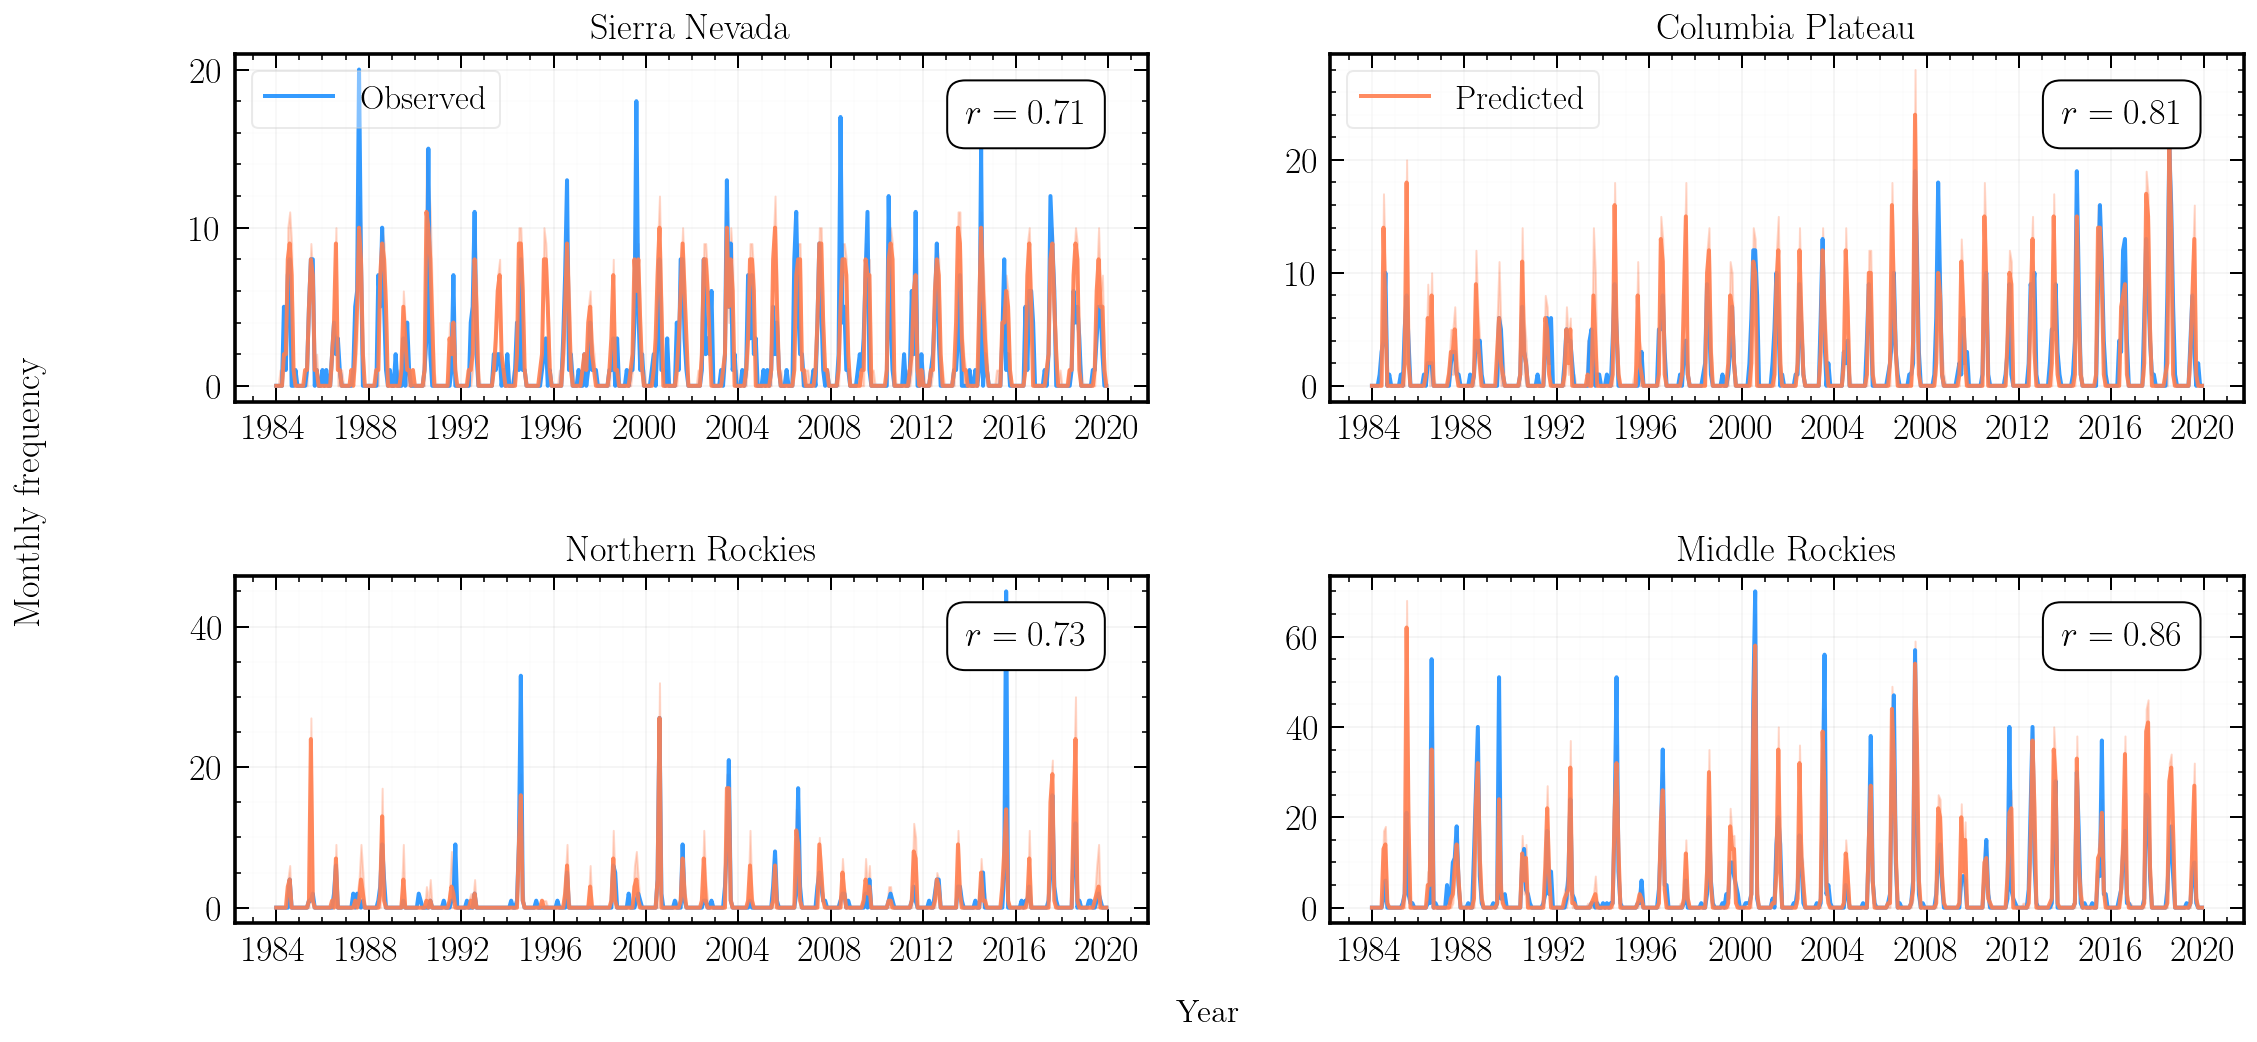

In [85]:
fig, ax= plt.subplots(2, 2, figsize=(18, 8))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= ind_grid_1[i][j]
        reg_mon_r_calib= stats.pearsonr(mdn_mon_freq_groups.get_group(regindx)['obs_freq'], mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
        
        if i+j == 0:
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'][startmon:], color= 'coral', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_mean_freq'][startmon:], color= 'coral', lw= 2);
        ax[i, j].fill_between(month_arr, mdn_mon_freq_groups.get_group(regindx)['pred_high_2sig'][startmon:], \
                              mdn_mon_freq_groups.get_group(regindx)['pred_low_2sig'][startmon:], color= 'coral', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 18);
        ax[i, j].set_xticks((year_arr - startyr)*12 + startmon);
        ax[i, j].set_xticklabels(year_arr)
        ax[i, j].text(0.8, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i, j].transAxes)
            
        fig.subplots_adjust(hspace= 0.5)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_freq_2.pdf', bbox_inches='tight');

#### Annual

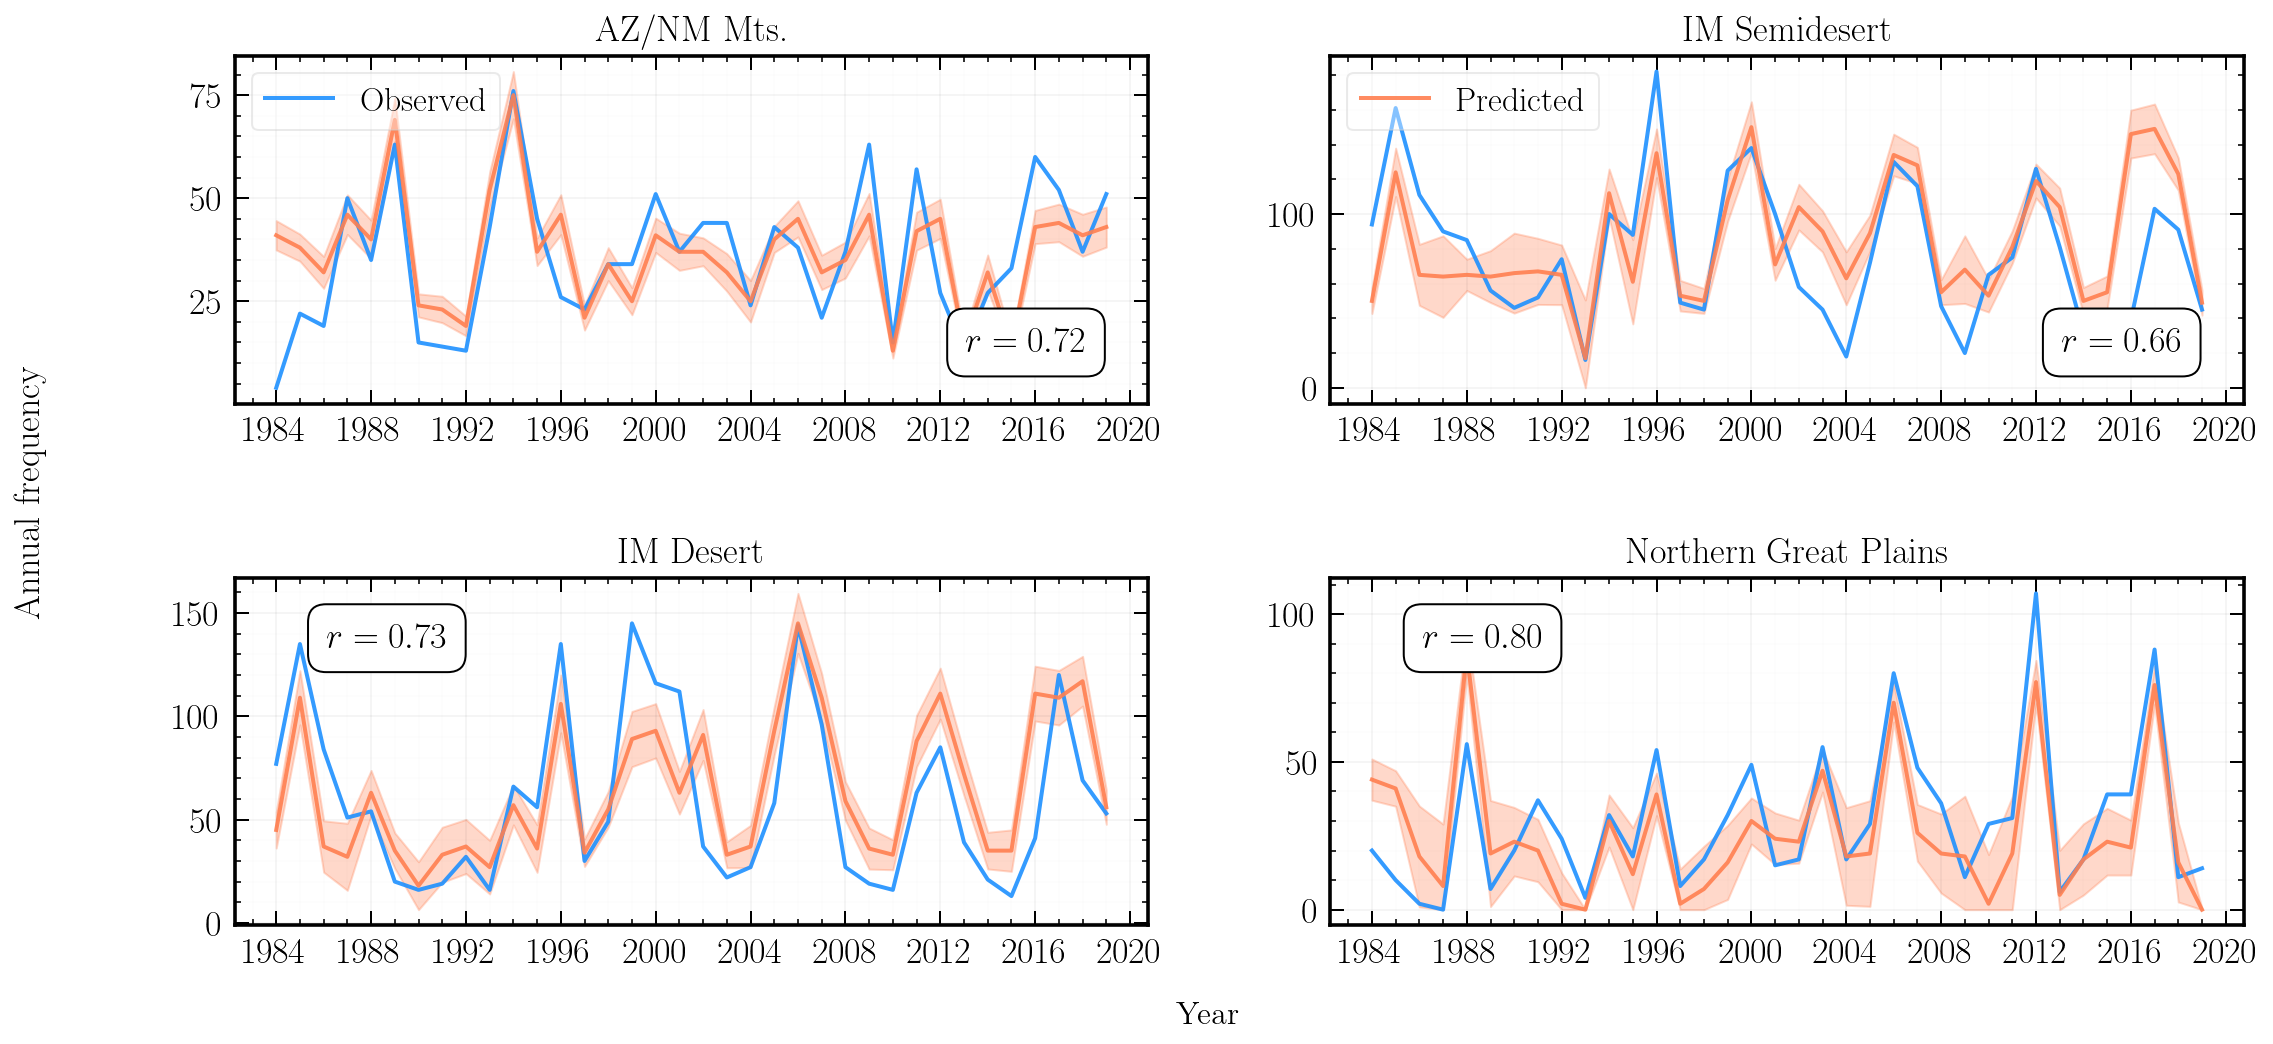

In [86]:
fig, ax= plt.subplots(2, 2, figsize=(18, 8))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= ind_grid_2[i][j]
        reg_ann_r_calib= stats.pearsonr(mdn_ann_freq_groups.get_group(regindx)['obs_freq'], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
        pos_arr= [[0.8, 0.15], [0.1, 0.8]]
        pred_ann_low_2sig= mdn_ann_freq_groups.get_group(regindx)['pred_low_2sig']
        pred_ann_low_2sig[pred_ann_low_2sig < 0]= 0
        
        if i+j == 0:
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['obs_freq'], color= 'dodgerblue', lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['obs_freq'], color= 'dodgerblue', lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_mean_freq'], color= 'coral', lw= 2);
        ax[i, j].fill_between(yr_arr[:-1], mdn_ann_freq_groups.get_group(regindx)['pred_high_2sig'], pred_ann_low_2sig, color= 'coral', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 18);
        ax[i, j].set_xticks((year_arr - startyr)*12 + startmon);
        ax[i, j].set_xticklabels(year_arr)
        ax[i, j].text(pos_arr[i][0], pos_arr[i][1], r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i, j].transAxes)
            
        fig.subplots_adjust(hspace= 0.5)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_freq_2.pdf', bbox_inches='tight');

### 2.4 SHAP plots

In [75]:
freq_id= '07_22_22'
X_plot_df= pd.read_hdf('../sav_files/shap_files/fire_freq_data_%s.h5'%freq_id)
reg_shap_df= pd.read_hdf('../sav_files/shap_files/fire_freq_shap_%s.h5'%freq_id)

In [76]:
reg_shap_df.columns

Index(['Tmax', 'VPD', 'Prec', 'Antprec_lag1', 'Forest', 'Wind', 'Grassland',
       'FM1000', 'AvgVPD_3mo', 'Avgprec_3mo', 'Urban', 'FFWI_max3', 'Tmin',
       'Camp_dist', 'Camp_num', 'Road_dist', 'Antprec_lag2', 'VPD_max3',
       'Tmax_max3', 'Tmin_max3', 'Slope', 'SWE_mean', 'SWE_max', 'AvgSWE_3mo',
       'Biomass', 'Popdensity', 'Housedensity', 'Lightning'],
      dtype='object')

#### WUS feature importance

In [5]:
X_plot_df.columns= ['Tmax', 'VPD', 'Prec', r'${\rm AntPrec}_{\rm 1yr}$', 'Forest', 'Wind', 'Grassland', 'FM1000', r'${\rm AntVPD}_{\rm 3mo}$', r'${\rm AntPrec}_{\rm 3mo}$', 'Urban', \
                    r'${\rm FFWI}^{\rm max3}$', 'Tmin', 'Campdist', 'Campnum', 'Roaddist', r'${\rm AntPrec}_{\rm 2yr}$', r'${\rm VPD}^{\rm max3}$', r'${\rm Tmax}^{\rm max3}$', r'${\rm Tmin}^{\rm max3}$', 'Slope', \
                    r'${\rm SWE}_{\rm mean}$', r'${\rm SWE}_{\rm max}$', r'${\rm AvgSWE}_{\rm 3mo}$', 'Biomass', 'Popdensity', 'Housedensity', 'Lightning', 'reg_indx'] #Southness, CAPE, r'$\Delta T$'

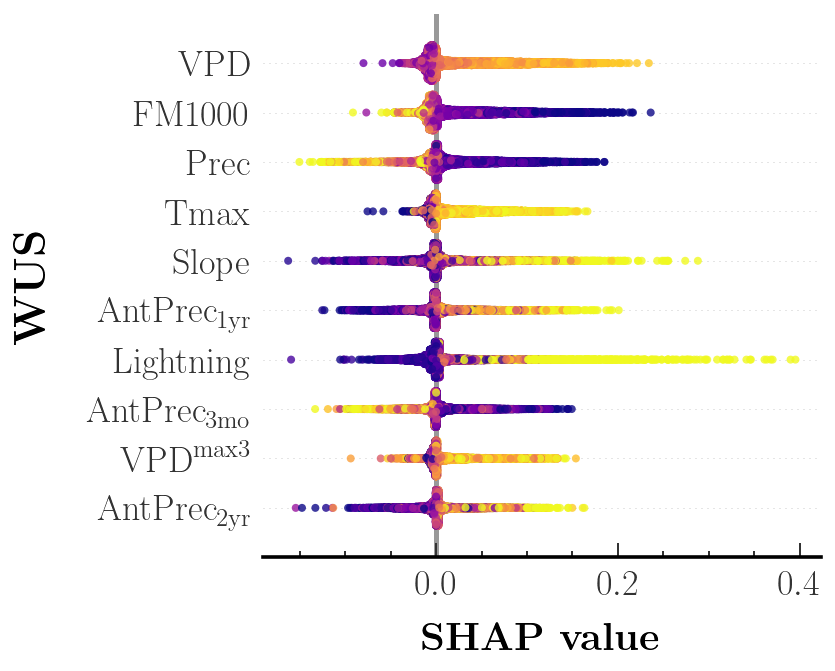

In [21]:
shap.summary_plot(np.array(reg_shap_df), X_plot_df.drop(columns= ['reg_indx']), max_display= 10, plot_size= (5, 5), show= False, alpha= 0.8, color_bar= False, cmap= plt.cm.plasma)
fig, ax= plt.gcf(), plt.gca()
fig.text(-0.22, 0.5, r'{\bf WUS}', va='center', rotation= 'vertical', fontsize= 22);
ax.tick_params(labeltop=False, top=False, labelright=False, right=False, which='both', labelsize= 18);
ax.set_xlabel(r'{\bf SHAP value}', fontsize= 20);
#plt.colorbar(shrink= 0.9);
plt.clim(-2,3);
#plt.savefig('../paper_plots/shap_freq_summary.pdf', bbox_inches='tight', dpi= 300);

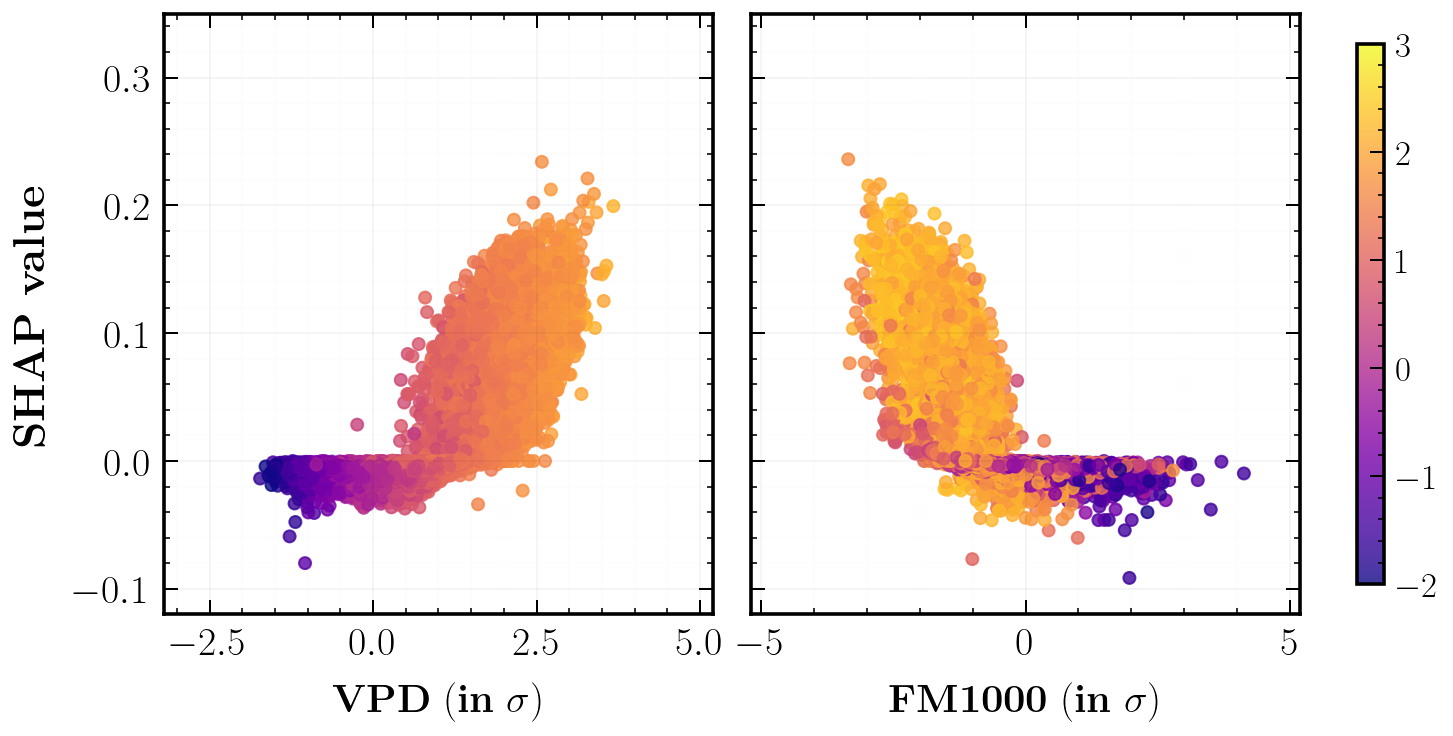

In [20]:
fig, ax= plt.subplots(1, 2, figsize= (10, 5) , constrained_layout= True)
CS0= ax[0].scatter(X_plot_df['VPD'], reg_shap_df['VPD'], alpha=0.8, c= X_plot_df['Tmax'], cmap= plt.cm.plasma)
ax[0].set_xlabel(r'${\bf {\rm \bf VPD \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[0].set_ylim(-0.12, 0.35);
ax[0].set_xlim(-3.2, 5.2); #set_xlim(-1, 20)
ax[0].set_ylabel(r'{\bf SHAP value}', fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].scatter(X_plot_df['FM1000'], reg_shap_df['FM1000'], alpha= 0.8, c= X_plot_df['Tmax'], cmap= plt.cm.plasma)
ax[1].set_xlabel(r'${\bf {\rm \bf FM1000 \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[1].set_ylim(-0.12, 0.35);
ax[1].set_xlim(-5.2, 5.2);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].set_yticklabels([]);
cbar= fig.colorbar(CS0, ax= ax[:], shrink= 0.9);
CS0.set_clim(-2,3);
#plt.savefig('../paper_plots/shap_freq_dependence.jpg', bbox_inches='tight', dpi= 300);

#### Regional feature importance

In [23]:
tmp_ind_vals= []
for r in range(18):
    tmp_ind_vals.append(np.argsort(np.mean(abs(reg_shap_df.iloc[X_plot_df.groupby('reg_indx').get_group(r+1).index].values), axis= 0)))
    print("Top %s"%reg_name[r+1] + " frequency predictors: %s"%np.array(X_plot_df.columns[tmp_ind_vals[r]][::-1][0:8]))

Top Sierra Nevada frequency predictors: ['Slope' 'VPD' 'FM1000' 'Tmax' 'Biomass' 'Lightning' 'Antprec_lag1' 'Prec']
Top North Coast frequency predictors: ['VPD' 'Lightning' 'Tmax' 'FM1000' 'Slope' 'Prec' 'Antprec_lag1'
 'VPD_max3']
Top Central Coast frequency predictors: ['VPD' 'FM1000' 'Tmax' 'Slope' 'Antprec_lag1' 'Grassland' 'Prec'
 'Lightning']
Top South Coast frequency predictors: ['VPD' 'Tmax' 'Slope' 'FM1000' 'Antprec_lag1' 'Lightning' 'AvgVPD_3mo'
 'Antprec_lag2']
Top Pacific NW frequency predictors: ['VPD' 'Slope' 'Biomass' 'Lightning' 'FM1000' 'Tmax' 'Prec' 'Antprec_lag1']
Top Columbia Plateau frequency predictors: ['VPD' 'Prec' 'FM1000' 'Tmax' 'Lightning' 'Slope' 'Antprec_lag1'
 'Grassland']
Top Northern Rockies frequency predictors: ['VPD' 'FM1000' 'Prec' 'Tmax' 'Slope' 'SWE_max' 'VPD_max3' 'Lightning']
Top Middle Rockies frequency predictors: ['VPD' 'FM1000' 'Prec' 'Tmax' 'Slope' 'AvgSWE_3mo' 'Lightning' 'SWE_max']
Top Southern Rockies frequency predictors: ['VPD' 'FM1000'

In [24]:
X_plot_df.columns= ['Tmax', 'VPD', 'Prec', r'${\rm AntPrec}_{\rm 1yr}$', 'Forest', 'Wind', 'Grassland', 'FM1000', r'${\rm AntVPD}_{\rm 3mo}$', r'${\rm AntPrec}_{\rm 3mo}$', 'Urban', \
                    r'${\rm FFWI}^{\rm max3}$', 'Tmin', 'Campdist', 'Campnum', 'Roaddist', r'${\rm AntPrec}_{\rm 2yr}$', r'${\rm VPD}^{\rm max3}$', r'${\rm Tmax}^{\rm max3}$', r'${\rm Tmin}^{\rm max3}$', 'Slope', \
                    r'${\rm SWE}_{\rm mean}$', r'${\rm SWE}_{\rm max}$', r'${\rm AvgSWE}_{\rm 3mo}$', 'Biomass', 'Popdensity', 'Housedensity', 'Lightning', 'reg_indx'] #Wind, Southness, CAPE

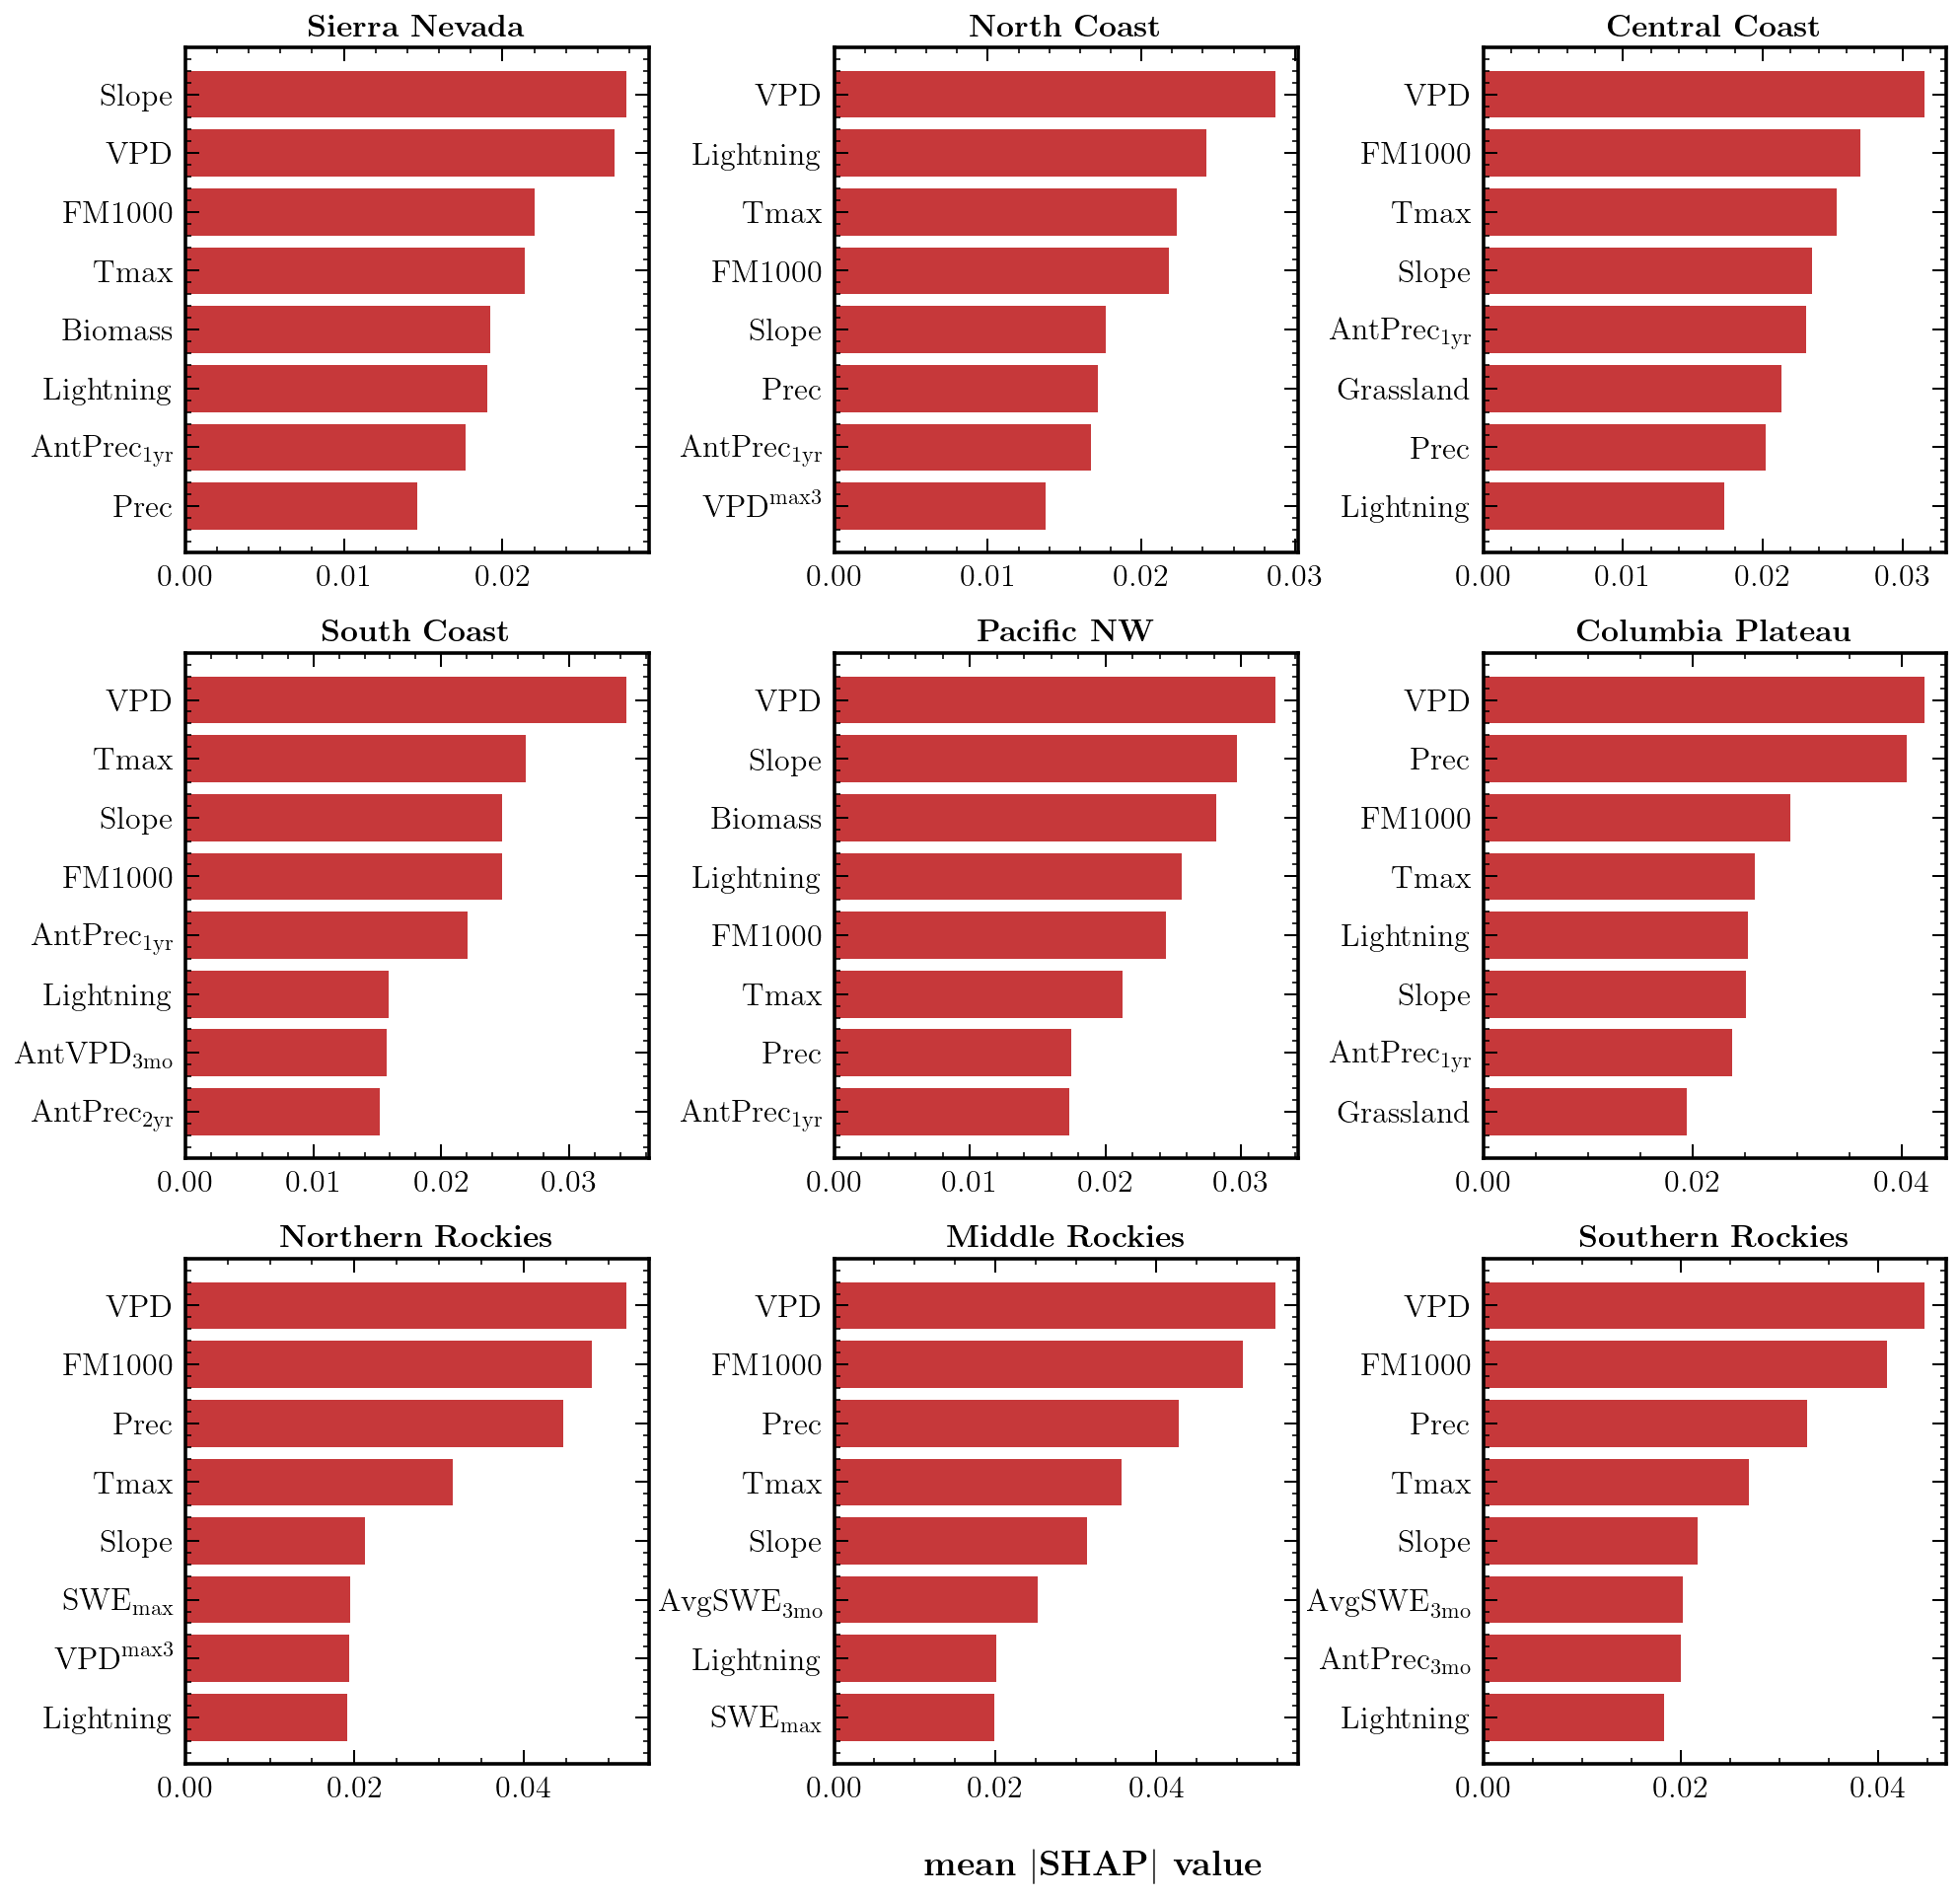

In [26]:
fig, ax= plt.subplots(3, 3, figsize= (16, 16))
shap_grid= [[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[10, 11, 12], [13, 14, 15], [16, 17, 18]]] 
for i in range(3):
    for j in range(3):
        regindx= shap_grid[0][i][j]
        ax[i, j].barh(X_plot_df.drop(columns= ['reg_indx']).columns[tmp_ind_vals[regindx -1]][-8:], np.sort(np.mean(np.array(abs(reg_shap_df.loc[X_plot_df.groupby('reg_indx').get_group(regindx).index])), axis= 0))[-8:])
        ax[i, j].set_title(r'{\bf %s}'%reg_name[regindx], va='center', fontsize= 16, pad= 10);
        fig.subplots_adjust(hspace= 0.2, wspace= 0.4)
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 16);
fig.text(0.45, 0.08, r'{\bf mean $|{\rm \bf SHAP}|$ value}', va='center', fontsize= 18);
#ax.set_xlabel(r'{\bf SHAP value}', fontsize= 20);
#plt.savefig('../paper_plots/shap_reg_freq_summary_1.pdf', bbox_inches='tight', dpi= 300);

In [77]:
X_forest_df= pd.concat([X_plot_df.groupby('reg_indx').get_group(k) for k in (1+forest_reg_arr)], axis= 0)
forest_shap_arr= reg_shap_df.loc[X_forest_df.drop(columns= ['reg_indx']).index]

X_desert_df= pd.concat([X_plot_df.groupby('reg_indx').get_group(k) for k in (1+desert_reg_arr)], axis= 0)
desert_shap_arr= reg_shap_df.loc[X_desert_df.drop(columns= ['reg_indx']).index]

X_plain_df= pd.concat([X_plot_df.groupby('reg_indx').get_group(k) for k in (1+plain_reg_arr)], axis= 0)
plain_shap_arr= reg_shap_df.loc[X_plain_df.drop(columns= ['reg_indx']).index]

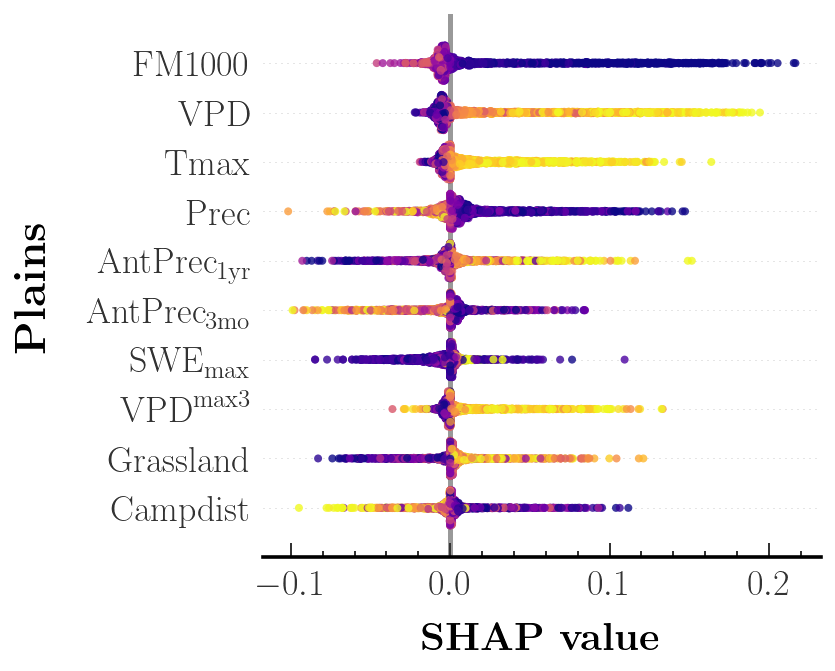

In [42]:
shap.summary_plot(np.array(plain_shap_arr), X_plain_df.drop(columns= ['reg_indx']), max_display= 10, plot_size= (5, 5), show= False, alpha= 0.8, color_bar= False, cmap= plt.cm.plasma)
fig, ax= plt.gcf(), plt.gca()
fig.text(-0.22, 0.5, r'{\bf Plains}', va='center', rotation= 'vertical', fontsize= 22);
ax.tick_params(labeltop=False, top=False, labelright=False, right=False, which='both', labelsize= 18);
ax.set_xlabel(r'{\bf SHAP value}', fontsize= 20);
#plt.colorbar(shrink= 0.9);
plt.clim(-2,3);
#plt.savefig('../paper_plots/shap_plain_freq_summary.pdf', bbox_inches='tight', dpi= 300);

In [78]:
X_plain_df.columns

Index(['Tmax', 'VPD', 'Prec', 'Antprec_lag1', 'Forest', 'Wind', 'Grassland',
       'FM1000', 'AvgVPD_3mo', 'Avgprec_3mo', 'Urban', 'FFWI_max3', 'Tmin',
       'Camp_dist', 'Camp_num', 'Road_dist', 'Antprec_lag2', 'VPD_max3',
       'Tmax_max3', 'Tmin_max3', 'Slope', 'SWE_mean', 'SWE_max', 'AvgSWE_3mo',
       'Biomass', 'Popdensity', 'Housedensity', 'Lightning', 'reg_indx'],
      dtype='object')

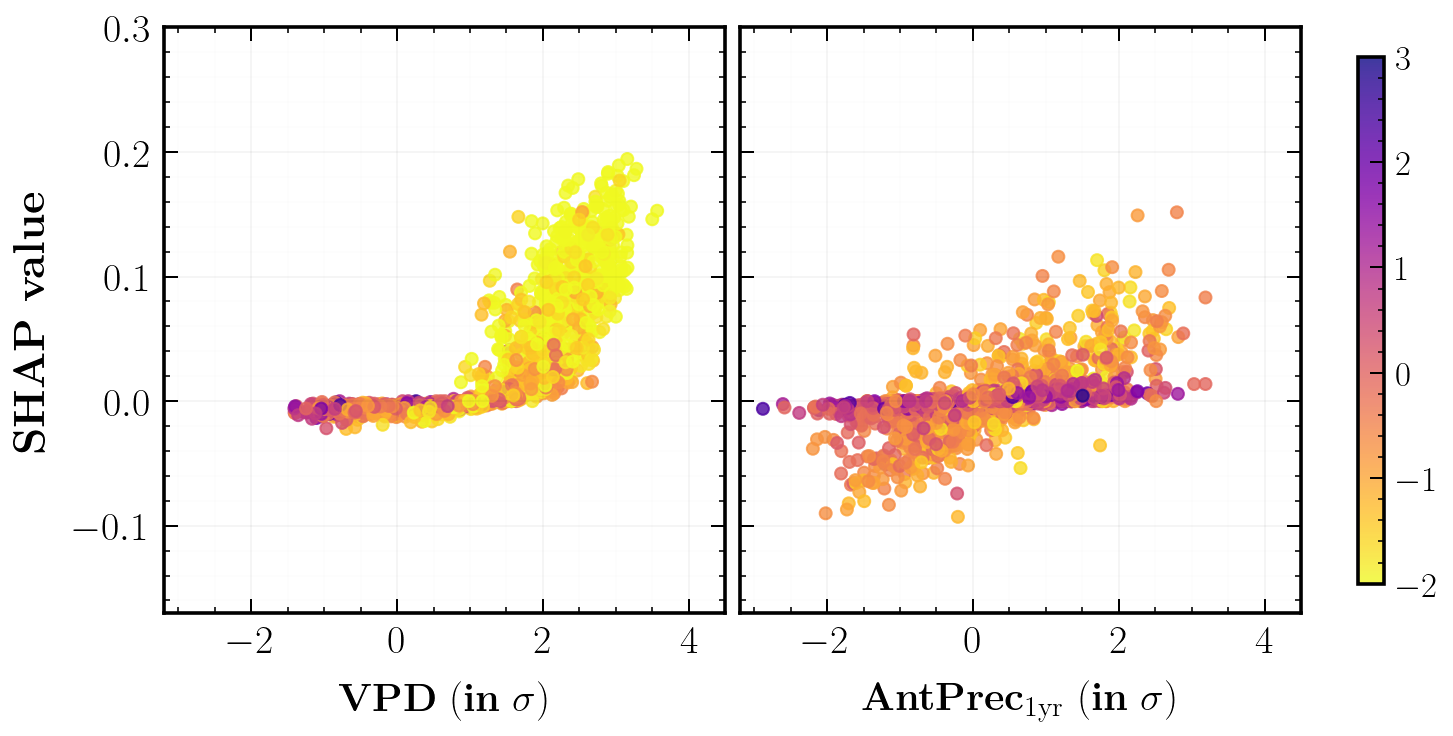

In [81]:
fig, ax= plt.subplots(1, 2, figsize= (10, 5) , constrained_layout= True)
CS0= ax[0].scatter(X_plain_df['VPD'], plain_shap_arr['VPD'], alpha=0.8, c= X_plain_df['FM1000'], cmap= plt.cm.plasma_r)
ax[0].set_xlabel(r'${\bf {\rm \bf VPD \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[0].set_ylim(-0.17, 0.3); #(-0.25, 0.4)
ax[0].set_xlim(-3.2, 4.5);
ax[0].set_ylabel(r'{\bf SHAP value}', fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].scatter(X_plain_df['Antprec_lag1'], plain_shap_arr['Antprec_lag1'], alpha= 0.8, c= X_plain_df['FM1000'], cmap= plt.cm.plasma_r)
ax[1].set_xlabel(r'${\bf {\rm \bf AntPrec_{\rm 1yr} \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[1].set_ylim(-0.17, 0.3);
ax[1].set_xlim(-3.2, 4.5);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].set_yticklabels([]);
cbar= fig.colorbar(CS0, ax= ax[:], shrink= 0.9);
CS0.set_clim(-2,3);
#plt.savefig('../paper_plots/shap_plain_freq_dependence.jpg', bbox_inches='tight', dpi= 300);

## 3. Grid fire locations

Plots for predicted and observed fire locations at an L3 ecoregion level that may be chosen using the `l3region` keyword. Options include the following ecoregions: </br>
{"ca_sierra", "ca_north_coast", "ca_cent_coast", "ca_south_coast", "pnw_mts", "columbia_plateau", "northern_rockies", "middle_rockies", "southern_rockies", "am_semidesert", "aznm_mts", "im_semidesert", "im_desert", "northern_great_plains", "high_plains", "colorado_plateau", "sw_tablelands", "ch_desert"}

All the custom functions called below maybe found in the `ml_utils.py` library file. 

### 3.1 Cumulative monthly locations

In [4]:
l3region= "northern_rockies"
run_id, it, bs, p_frac= ['02_27_22', 2, 8192, '0.3']
reg_pred_freq= bailey_ecoprovince_mask('../sav_files/pred_freq_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.nc'%it, region= l3region)
reg_obs_freq= bailey_ecoprovince_mask('../sav_files/obs_freq.nc', region= l3region)
lat_long_fire_grid= coord_transform(reg_pred_freq['X'][:].data, reg_pred_freq['Y'][:].data, input_crs= 'EPSG:5070')

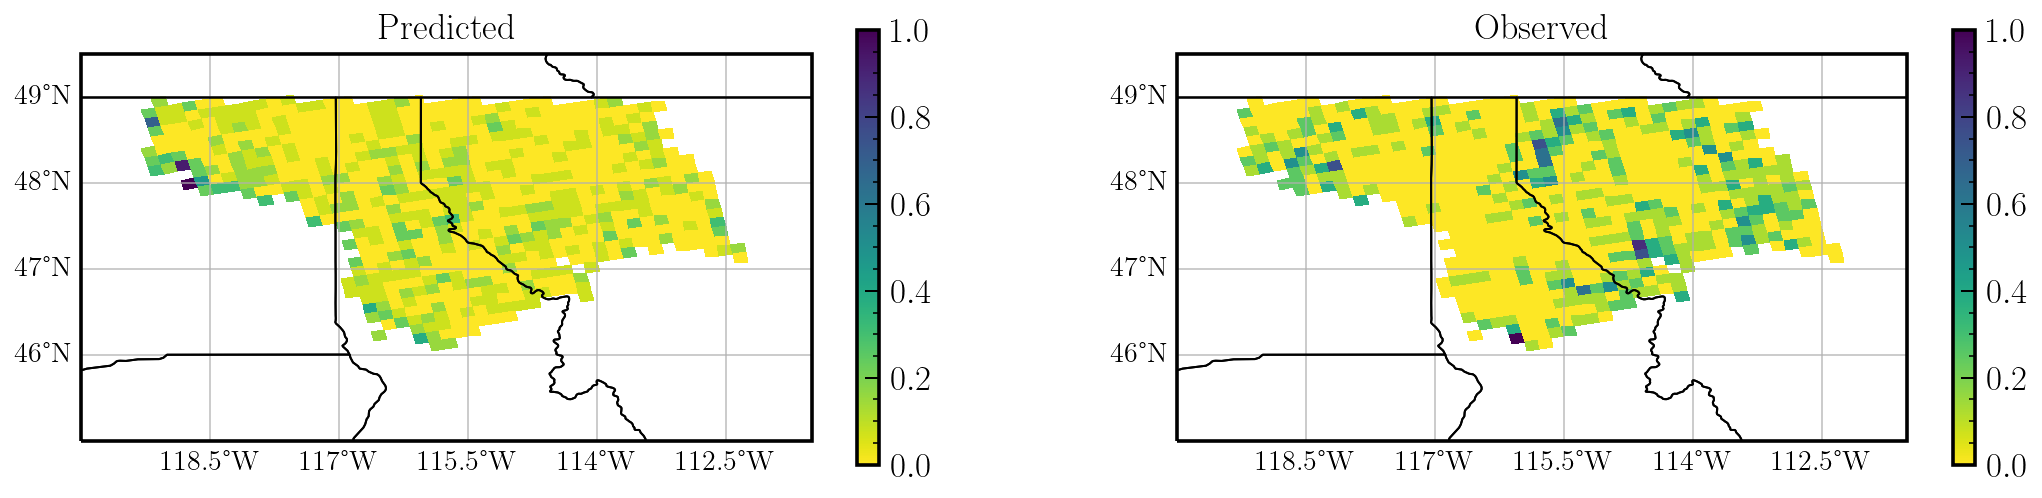

In [5]:
extent = [-120, -111.5, 45, 49.5] #[-120.5, -112.5, 42, 48.5] #[-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 4)) 

ax0= plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax0.set_extent(extent);

ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax0.gridlines(draw_labels=True, alpha= 0.8);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 14};
gl.ylabel_style = {'size': 14};

CS = ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(reg_pred_freq.values, axis= 0)/np.nanmax(np.sum(reg_pred_freq.values, axis= 0)), cmap=plt.cm.viridis_r)
cbar= fig.colorbar(CS, ax= ax0)
ax0.set_title(r'$\rm{Predicted}$', fontsize= 18);

ax1= plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent(extent);

ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl1= ax1.gridlines(draw_labels=True, alpha= 0.8);
gl1.top_labels = False;
gl1.right_labels = False;
gl1.xlabel_style = {'size': 14};
gl1.ylabel_style = {'size': 14};

CS1 = ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(reg_obs_freq.values, axis= 0)/np.nanmax(np.sum(reg_obs_freq.values, axis= 0)), cmap=plt.cm.viridis_r) #
cbar1= fig.colorbar(CS1)
ax1.set_title(r'$\rm{Observed}$', fontsize= 18);
#plt.savefig('../plots/grid_freq_loc_nrockies.jpg', bbox_inches='tight');

### 3.2 Longterm locations

In [6]:
l3region= "northern_rockies"
reg_obs_prob_freq= bailey_ecoprovince_mask('../sav_files/pred_freq_longterm_prob.nc', region= l3region)
reg_obs_freq= bailey_ecoprovince_mask('../sav_files/obs_freq.nc', region= l3region)
lat_long_fire_grid= coord_transform(reg_obs_freq['X'][:].data, reg_obs_freq['Y'][:].data, input_crs= 'EPSG:5070')

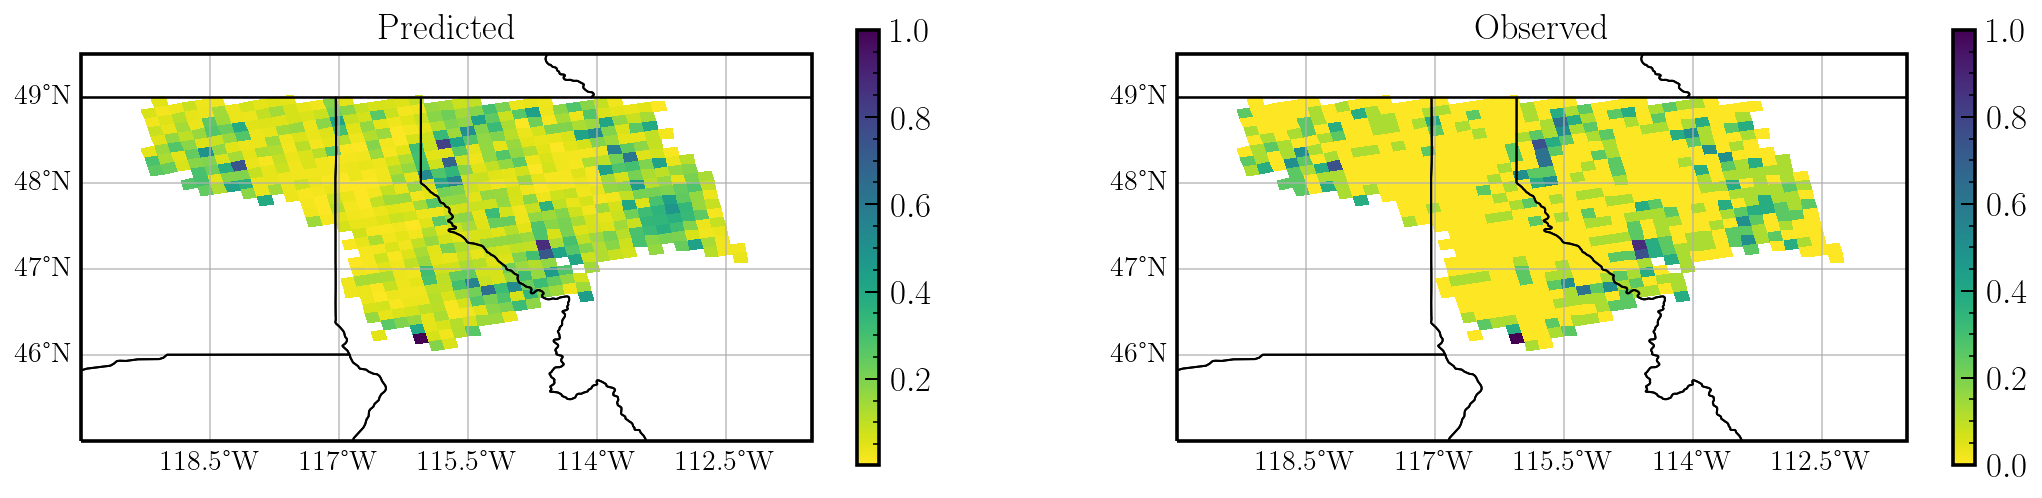

In [7]:
extent = [-120, -111.5, 45, 49.5]  #[-120, -111.5, 45, 49.5] #[-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 4)) 

ax0= plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax0.set_extent(extent);

ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax0.gridlines(draw_labels=True, alpha= 0.8);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 14};
gl.ylabel_style = {'size': 14};

CS = ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], reg_obs_prob_freq/np.max(reg_obs_prob_freq).values, cmap=plt.cm.viridis_r)
cbar= fig.colorbar(CS, ax= ax0)
ax0.set_title(r'$\rm{Predicted}$', fontsize= 18);

ax1= plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent(extent);

ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl1= ax1.gridlines(draw_labels=True, alpha= 0.8);
gl1.top_labels = False;
gl1.right_labels = False;
gl1.xlabel_style = {'size': 14};
gl1.ylabel_style = {'size': 14};

CS1 = ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(reg_obs_freq.values, axis= 0)/np.nanmax(np.sum(reg_obs_freq.values, axis= 0)), cmap=plt.cm.viridis_r) #
cbar1= fig.colorbar(CS1)
ax1.set_title(r'$\rm{Observed}$', fontsize= 18);
#plt.savefig('../plots/grid_freq_loc_nrockies.jpg', bbox_inches='tight');

## 4. Fire size model

This module includes all plotting functions for the grid scale fire sizes predicted using mixture density networks (MDNs). Briefly, the workflow is as follows, 

4.1) load the output from model runs (see `ml_grid_fire_size.ipynb`) with various loss functions including mixtures of: Generalized Pareto distribution (gpd), extreme fire size weighted GPD (gpd_ext), Lognormal distribution (lognorm), and Lognormal-GPD distribution (lognorm_gpd); </br>
4.2) plot the cumulative annual and monthly burned areas for the entire western US study region; </br>
4.3) plot the monthly and annual burned areas for individual L3 ecoregions;</br>
4.4) compare the empirical cumulative distribution functions (CDFs) of observed and predicted monthly burned areas;</br>
4.5) compare the empirical CDF of observed fire _sizes_ with the theoretical CDFs corresponding to MDN models with different loss functions.</br>

All the custom functions called below maybe found in the `ml_utils.py` library file. 

### 4.1 Loading model outputs

In [104]:
size_id= '07_15_22' #04_17_22 #05_04_22 05_30_22 #06_24_22 07_15_22
freq_id= '05_30_22' #04_17_22 #05_30_22
ml_flag= True

if ml_flag:
    reg_ml_freq_gpd_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_mon_fire_size_%s'%size_id + '_ml_freq_data_loc_run_%s'%freq_id + '_df.h5')
    reg_ml_freq_gpd_ext_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_ext_mon_fire_size_%s'%size_id + '_ml_freq_data_loc_run_%s'%freq_id + '_df.h5')
    reg_ml_loc_gpd_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_mon_fire_size_%s'%size_id + '_data_freq_ml_loc_run_%s'%freq_id + '_df.h5')
    reg_ml_loc_gpd_ext_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_ext_mon_fire_size_%s'%size_id + '_data_freq_ml_loc_run_%s'%freq_id + '_df.h5')
    reg_ml_fc_gpd_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_mon_fire_size_%s'%size_id + '_ml_freq_ml_loc_run_%s'%freq_id + '_df.h5')
    reg_ml_fc_gpd_ext_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_ext_mon_fire_size_%s'%size_id + '_ml_freq_ml_loc_run_%s'%freq_id + '_df.h5')
reg_gpd_data_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_mon_fire_size_%s'%size_id + '_data_freq_%s_df.h5'%freq_id)
reg_gpd_ext_data_size_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/gpd_ext_mon_fire_size_%s'%size_id + '_data_freq_%s_df.h5'%freq_id) #loc_ml_
mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_ext_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})

#reg_lognorm_gpd_data_size_df= pd.read_hdf('../sav_files/grid_size_runs_%s'%size_id + '/lognorm_gpd_mon_fire_size_%s'%size_id + '_data_freq_df.h5')
#reg_gpd_gpd_data_size_df= pd.read_hdf('../sav_files/gpd_gpd_tot_mon_fire_size_%s'%size_id + '_data_freq_df.h5')

In [92]:
break_year= 2004 #2002
break_month= (break_year + 1 - 1984)*12

### 4.2 WUS sizes

In [105]:
# Setting timebreak = True implies that the resultant time series will be a combnination of the MDN-gpd model time series for T < 2004 and MDN-gpd_ext for T >= 2004.
# Use the optflag= True argument to drop regions with monthly correlations less than 0.6 from the cummulative burned area time series
# Use the regarr argument for specifying custom regions: # regarr= [1, 4, 6, 7, 8, 10, 15] (forested) #regarr= [5, 11, 12, 13, 9, 14, 16, 17] (nonforested)

tot_mon_obs_size_arr, tot_mon_pred_size_arr, tot_mon_pred_1sig_arr, tot_ann_obs_size_arr, \
            tot_ann_pred_size_arr, tot_ann_pred_1sig_arr= cumm_fire_size_func(firefile= fire_file, reg_size_df= reg_gpd_data_size_df, tot_months= tot_months, \
                                                        optflag= False, timebreak= True, breakmon= break_month, reg_gpd_ext_size_df= reg_gpd_ext_data_size_df) 

In [106]:
tot_ann_pred_high_1sig_arr= tot_ann_pred_size_arr + tot_ann_pred_1sig_arr
tot_ann_pred_low_1sig_arr= tot_ann_pred_size_arr - tot_ann_pred_1sig_arr
tot_mon_pred_high_1sig_arr= tot_mon_pred_size_arr + tot_mon_pred_1sig_arr
tot_mon_pred_low_1sig_arr= tot_mon_pred_size_arr - tot_mon_pred_1sig_arr
tot_mon_pred_low_1sig_arr[tot_mon_pred_low_1sig_arr < 0]= 0

tot_mon_size_r= stats.pearsonr(np.sum(tot_mon_obs_size_arr, axis= 0), tot_mon_pred_size_arr)[0] #stats.pearsonr(np.sum(mon_obs_arr, axis= 0), np.sum(mon_pred_arr, axis= 0))[0]
tot_ann_size_r= stats.pearsonr(np.sum(tot_ann_obs_size_arr, axis= 0), tot_ann_pred_size_arr)[0] #stats.pearsonr(np.sum(ann_obs_arr, axis= 0), np.sum(ann_pred_arr, axis= 0))[0]

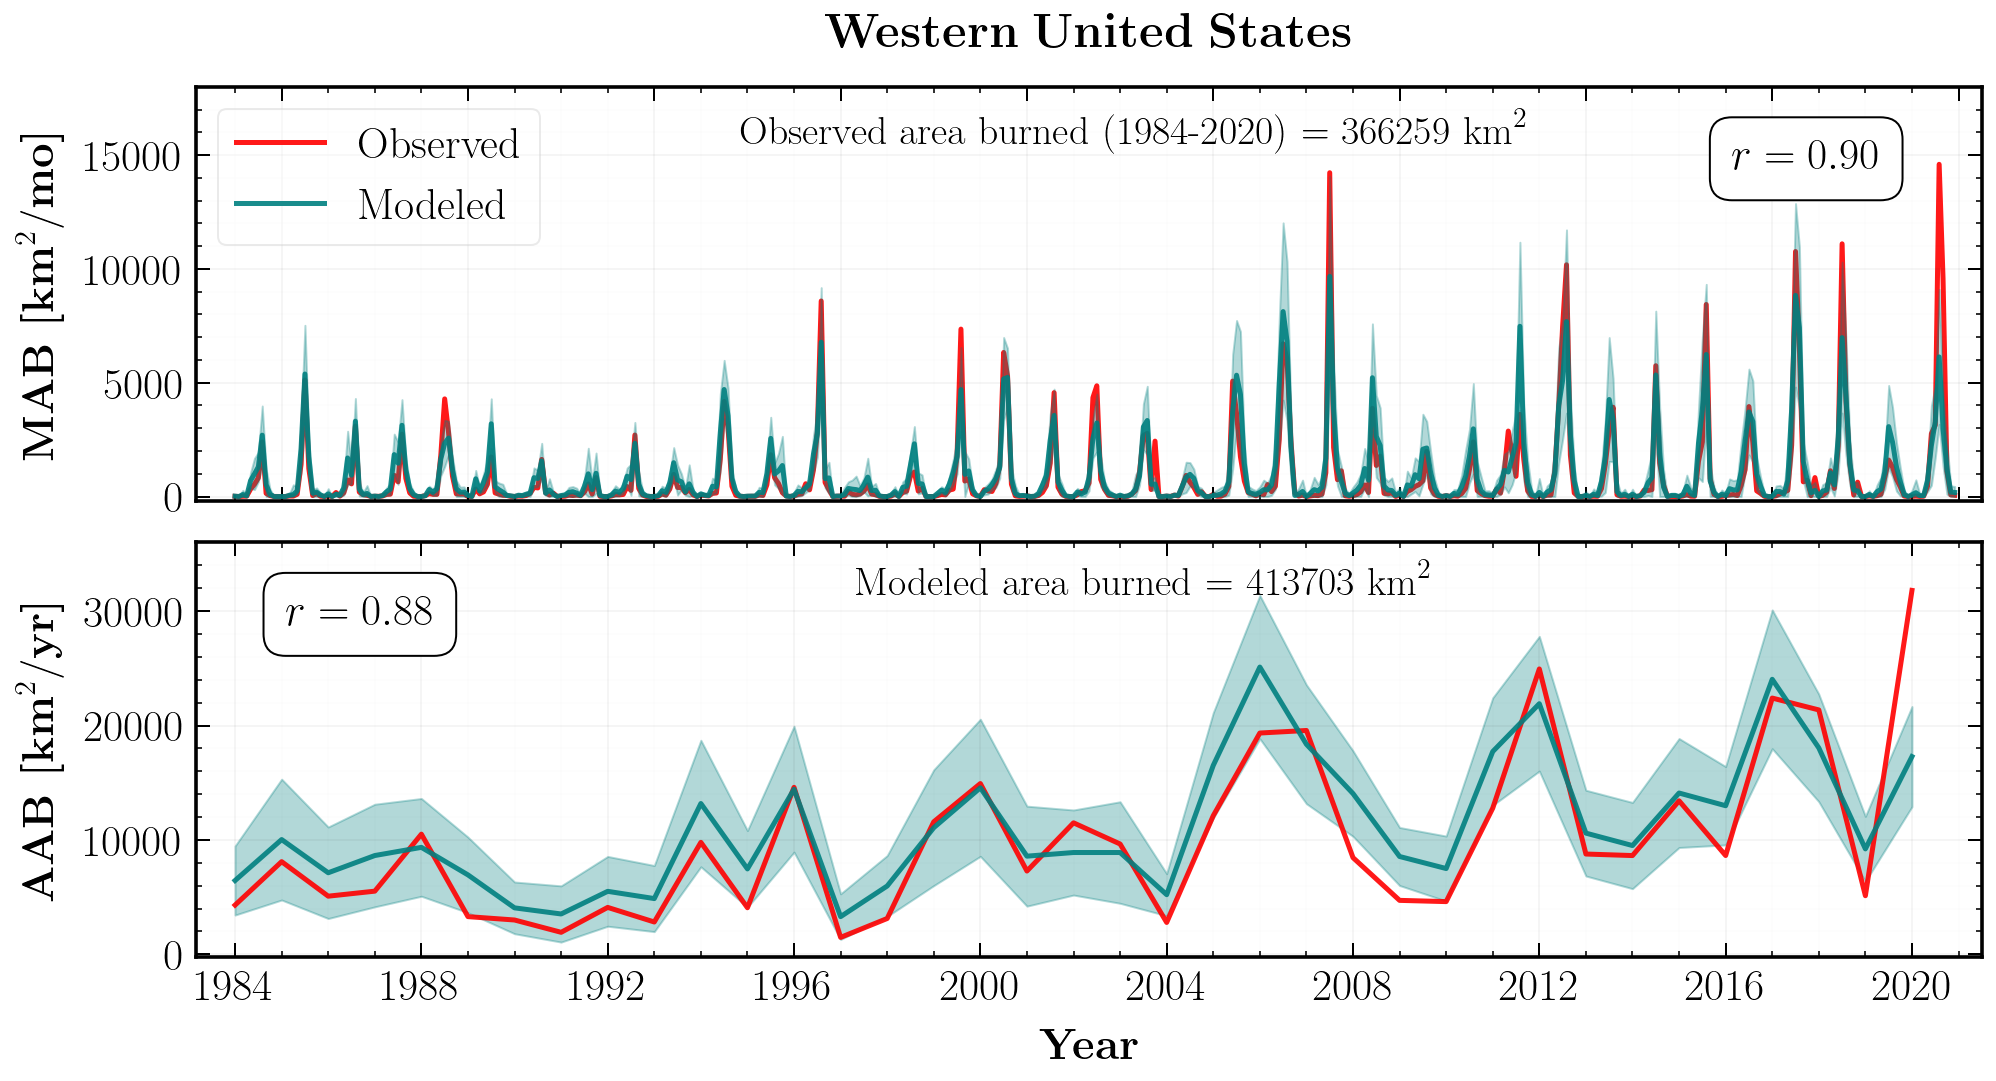

In [140]:
fig, ax= plt.subplots(2, 1, figsize=(16, 8))

ax[1].plot(yr_arr[:-1], np.sum(tot_ann_obs_size_arr, axis= 0), color= 'red');
ax[1].plot(yr_arr[:-1], tot_ann_pred_size_arr, color= 'teal'); #np.sum(ann_pred_arr, axis= 0)
ax[1].fill_between(yr_arr[:-1], tot_ann_pred_high_1sig_arr, tot_ann_pred_low_1sig_arr, color= 'teal', alpha= 0.3) #np.sum(ann_pred_high_1sig_arr, axis= 0)
ax[1].set_ylabel(r'{\bf AAB [${\bf km}^2/{\bf yr}$]}', fontsize= 22, labelpad= 10);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_xlim(-10, 450);
ax[1].set_ylim(-200, 36000);
ax[1].set_xticks((year_arr - 1984)*12);
ax[1].set_xticklabels(year_arr)
ax[1].text(0.05, 0.8, r'$r = %.2f$'%tot_ann_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
ax[1].text(160, 31500, r"Modeled area burned = %d ${\rm km}^2$"%np.sum(tot_ann_pred_size_arr), fontsize= 20);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[0].plot(month_arr, np.sum(tot_mon_obs_size_arr, axis= 0), color= 'red', label= 'Observed', zorder= 1);
ax[0].plot(month_arr, tot_mon_pred_size_arr, color= 'teal', label= 'Modeled');
ax[0].fill_between(month_arr, tot_mon_pred_high_1sig_arr, tot_mon_pred_low_1sig_arr, color= 'teal', alpha= 0.3, zorder= 10)
ax[0].set_title(r'${\bf Western \ United \ States}$', fontsize= 24, pad= 20); #Western \ United \ States
ax[0].set_ylabel(r'{\bf MAB [${\bf km}^2/{\bf mo}$]}', fontsize= 22, labelpad= 10);
ax[0].set_xlim(-10, 450);
ax[0].set_ylim(-200, 18000);
ax[0].set_xticks((year_arr - 1983)*12);
ax[0].set_xticklabels([])
ax[0].text(0.86, 0.8, r'$r = %.2f$'%tot_mon_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].text(130, 15500, r"Observed area burned (1984-2020) = %d ${\rm km}^2$"%np.sum(np.sum(tot_ann_obs_size_arr, axis= 0)), fontsize= 20);
ax[0].legend(loc='upper left', frameon= True, fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#fig.savefig('../paper_plots/ml_fire_size_wus.pdf', bbox_inches='tight', dpi= 300);

In [111]:
stats.pearsonr(np.sum(tot_ann_obs_size_arr, axis= 0)[:-1], tot_ann_pred_size_arr[:-1])[0], stats.pearsonr(np.sum(tot_mlf_ann_obs_size_arr, axis= 0)[:-1], tot_mlf_ann_pred_size_arr[:-1])[0]

(0.929985426477717, 0.893746544720092)

In [112]:
stats.pearsonr(np.sum(tot_mlfc_ann_obs_size_arr, axis= 0)[:-1], tot_mlfc_ann_pred_size_arr[:-1])[0], stats.pearsonr(np.sum(tot_mll_ann_obs_size_arr, axis= 0)[:-1], tot_mll_ann_pred_size_arr[:-1])[0]

(0.9139194169076515, 0.8466183249659457)

#### 4.2.1 WUS ML sizes

In [108]:
tot_mlf_mon_obs_size_arr, tot_mlf_mon_pred_size_arr, tot_mlf_mon_pred_1sig_arr, tot_mlf_ann_obs_size_arr, \
            tot_mlf_ann_pred_size_arr, tot_mlf_ann_pred_1sig_arr= cumm_fire_size_func(firefile= fire_file, reg_size_df= reg_ml_freq_gpd_size_df, tot_months= tot_months, \
                                                        optflag= False, timebreak= True, breakmon= break_month, reg_gpd_ext_size_df= reg_ml_freq_gpd_ext_size_df) #, rescale= True, sf_flag= 'obs_freq_scale_fac'

tot_mlf_ann_pred_high_1sig_arr= tot_mlf_ann_pred_size_arr + tot_mlf_ann_pred_1sig_arr
tot_mlf_ann_pred_low_1sig_arr= tot_mlf_ann_pred_size_arr - tot_mlf_ann_pred_1sig_arr
tot_mlf_ann_size_r= stats.pearsonr(np.sum(tot_mlf_ann_obs_size_arr, axis= 0), tot_mlf_ann_pred_size_arr)[0] #stats.pearsonr(np.sum(ann_obs_arr, axis= 0), np.sum(ann_pred_arr, axis= 0))[0]

In [109]:
tot_mll_mon_obs_size_arr, tot_mll_mon_pred_size_arr, tot_mll_mon_pred_1sig_arr, tot_mll_ann_obs_size_arr, \
            tot_mll_ann_pred_size_arr, tot_mll_ann_pred_1sig_arr= cumm_fire_size_func(firefile= fire_file, reg_size_df= reg_ml_loc_gpd_size_df, tot_months= tot_months, \
                                                        optflag= False, timebreak= True, breakmon= break_month, reg_gpd_ext_size_df= reg_ml_loc_gpd_ext_size_df) 

tot_mll_ann_pred_high_1sig_arr= tot_mll_ann_pred_size_arr + tot_mll_ann_pred_1sig_arr
tot_mll_ann_pred_low_1sig_arr= tot_mll_ann_pred_size_arr - tot_mll_ann_pred_1sig_arr
tot_mll_ann_size_r= stats.pearsonr(np.sum(tot_mll_ann_obs_size_arr, axis= 0), tot_mll_ann_pred_size_arr)[0]

In [110]:
tot_mlfc_mon_obs_size_arr, tot_mlfc_mon_pred_size_arr, tot_mlfc_mon_pred_1sig_arr, tot_mlfc_ann_obs_size_arr, \
            tot_mlfc_ann_pred_size_arr, tot_mlfc_ann_pred_1sig_arr= cumm_fire_size_func(firefile= fire_file, reg_size_df= reg_ml_fc_gpd_size_df, tot_months= tot_months, \
                                                        optflag= False, timebreak= True, breakmon= break_month, reg_gpd_ext_size_df= reg_ml_fc_gpd_ext_size_df) 

tot_mlfc_ann_pred_high_1sig_arr= tot_mlfc_ann_pred_size_arr + tot_mlfc_ann_pred_1sig_arr
tot_mlfc_ann_pred_low_1sig_arr= tot_mlfc_ann_pred_size_arr - tot_mlfc_ann_pred_1sig_arr
tot_mlfc_ann_size_r= stats.pearsonr(np.sum(tot_mlfc_ann_obs_size_arr, axis= 0), tot_mlfc_ann_pred_size_arr)[0]

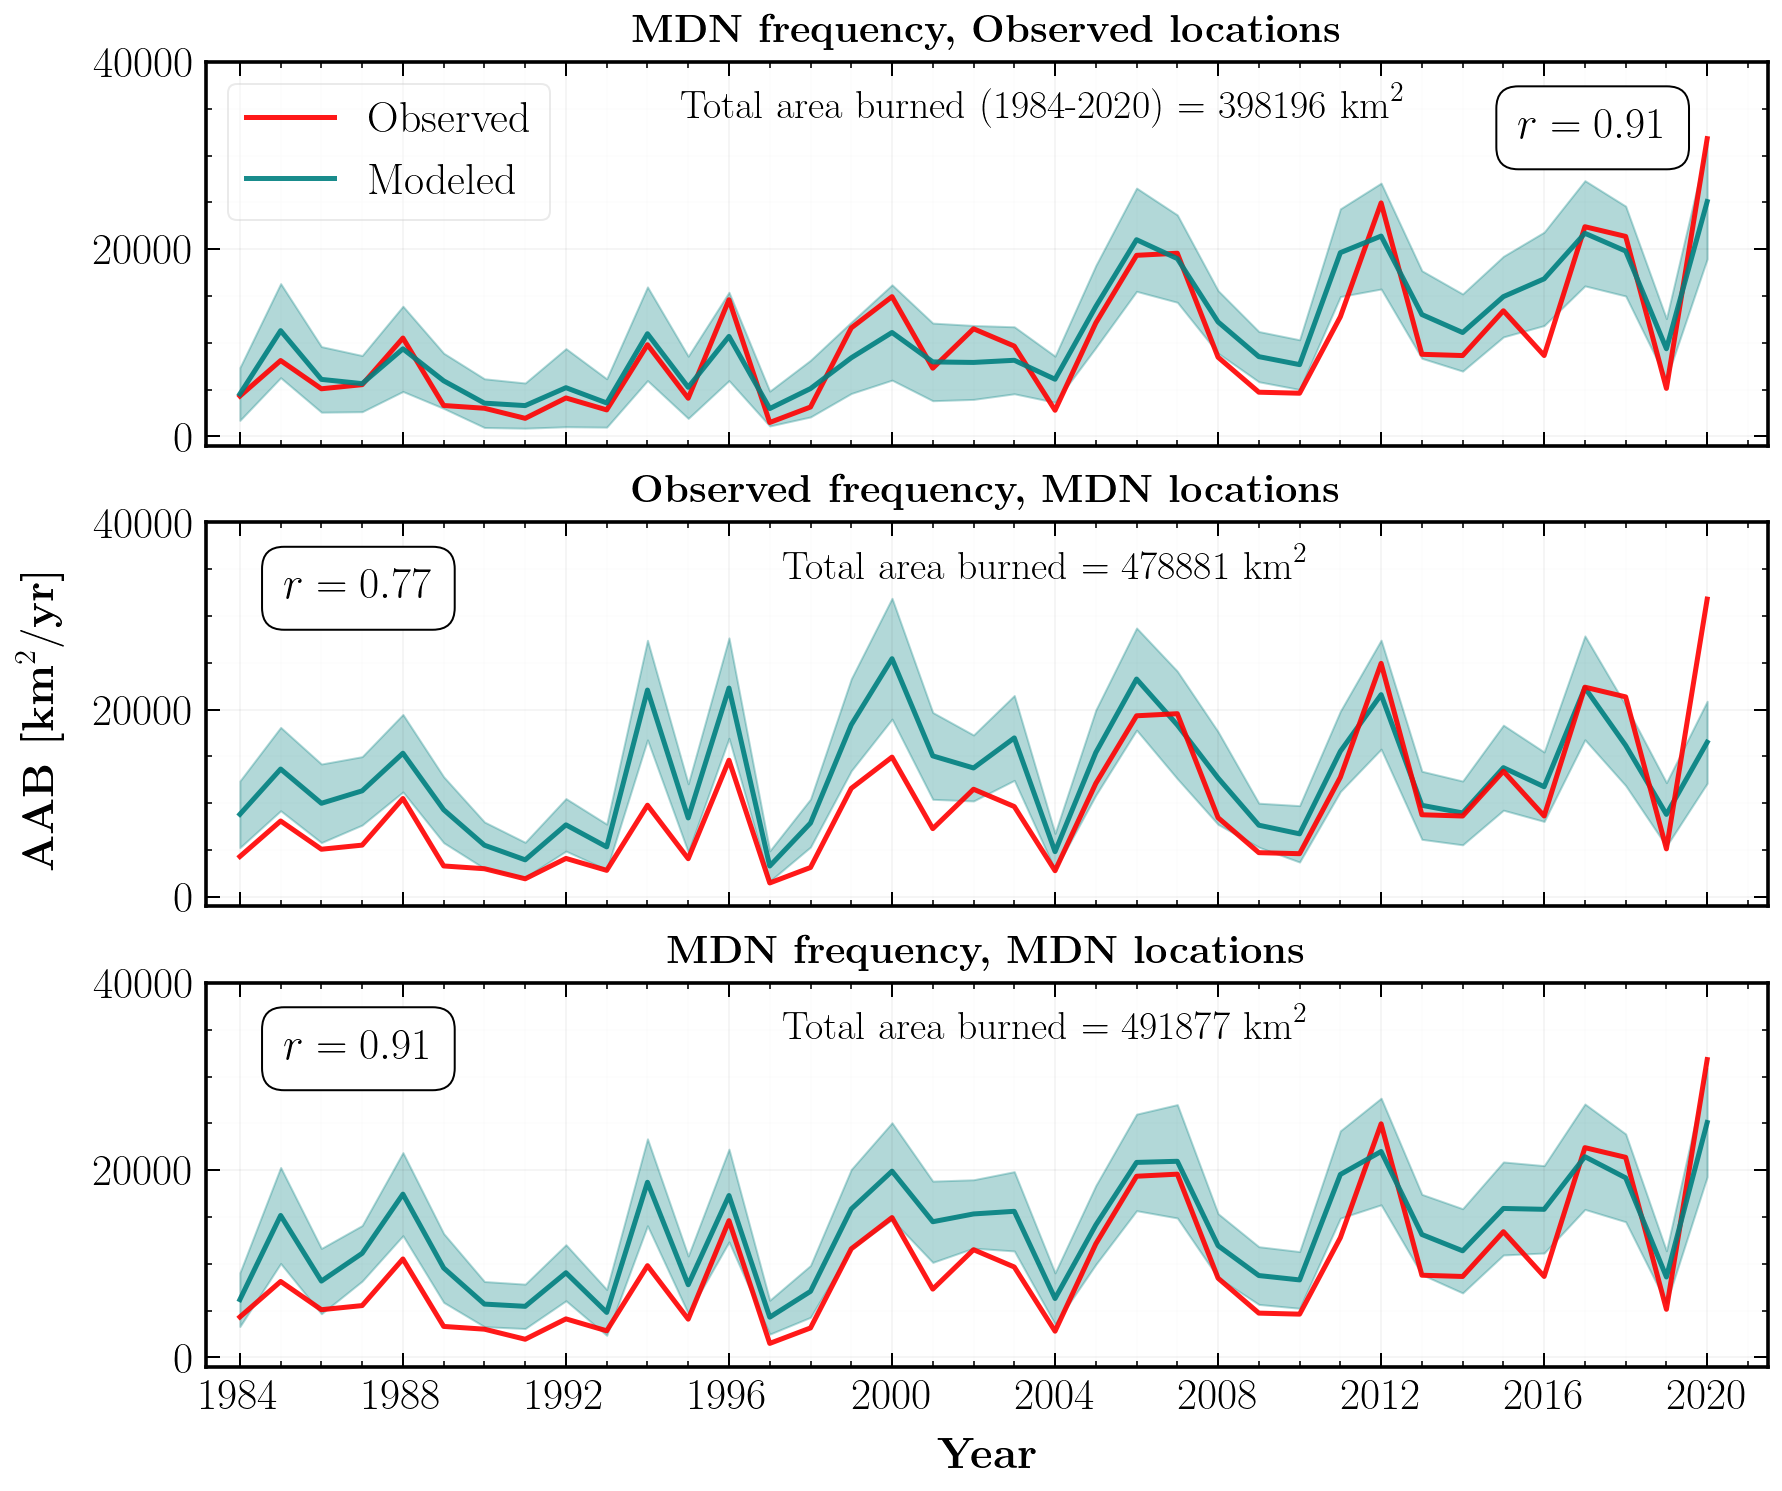

In [137]:
fig, ax= plt.subplots(3, 1, figsize=(14, 12))
fig.text(0.03, 0.5, r'{\bf AAB [${\bf km}^2/{\bf yr}$]}', va='center', rotation='vertical', fontsize= 22);

corr_fac_mlf= 1.0 #np.sum(tot_ann_pred_size_arr)/np.sum(tot_mlf_ann_pred_size_arr)
ax[0].plot(yr_arr[:-1], np.sum(tot_mlf_ann_obs_size_arr, axis= 0), color= 'red', label= 'Observed');
ax[0].plot(yr_arr[:-1], corr_fac_mlf*tot_mlf_ann_pred_size_arr, color= 'teal', label= 'Modeled'); #np.sum(ann_pred_arr, axis= 0)
ax[0].fill_between(yr_arr[:-1], corr_fac_mlf*tot_mlf_ann_pred_high_1sig_arr, corr_fac_mlf*tot_mlf_ann_pred_low_1sig_arr, color= 'teal', alpha= 0.3) #np.sum(ann_pred_high_1sig_arr, axis= 0)
ax[0].set_xlim(-10, 450);
ax[0].set_ylim(-1000, 40000);
ax[0].set_xticks((year_arr - 1984)*12);
ax[0].set_xticklabels([])
ax[0].text(0.84, 0.8, r'$r = %.2f$'%tot_mlf_ann_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].legend(loc='upper left', frameon= True, fontsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[0].text(130, 34000, r"Total area burned (1984-2020) = %d ${\rm km}^2$"%np.sum(tot_mlf_ann_pred_size_arr), fontsize= 20);
ax[0].set_title(r'{\bf MDN frequency, Observed locations}', fontsize= 20, pad= 10);

fig.subplots_adjust(hspace= 0.2);

corr_fac_mlfc= 1.0 #np.sum(tot_ann_pred_size_arr)/np.sum(tot_mlfc_ann_pred_size_arr)
ax[2].plot(yr_arr[:-1], np.sum(tot_mlfc_ann_obs_size_arr, axis= 0), color= 'red', zorder= 1);
ax[2].plot(yr_arr[:-1], corr_fac_mlfc*tot_mlfc_ann_pred_size_arr, color= 'teal', zorder= 1); #np.sum(ann_pred_arr, axis= 0)
ax[2].fill_between(yr_arr[:-1], corr_fac_mlfc*tot_mlfc_ann_pred_high_1sig_arr, corr_fac_mlfc*tot_mlfc_ann_pred_low_1sig_arr, color= 'teal', alpha= 0.3) #np.sum(ann_pred_high_1sig_arr, axis= 0)
#ax[2].set_ylabel(r'{\bf AAB [${\bf km}^2/{\bf yr}$]}', fontsize= 22, labelpad= 10);
ax[2].set_xlim(-10, 450);
ax[2].set_ylim(-1000, 40000);
ax[2].set_xticks((year_arr - 1984)*12);
ax[2].set_xticklabels(year_arr)
ax[2].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[2].text(0.05, 0.8, r'$r = %.2f$'%tot_mlfc_ann_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[2].transAxes)
ax[2].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[2].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[2].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[2].text(160, 34000, r"Total area burned = %d ${\rm km}^2$"%np.sum(tot_mlfc_ann_pred_size_arr), fontsize= 20);
ax[2].set_title(r'{\bf MDN frequency, MDN locations}', fontsize= 20, pad= 10);

fig.subplots_adjust(hspace= 0.2);

corr_fac_mll= 1.0 #np.sum(tot_ann_pred_size_arr)/np.sum(tot_mll_ann_pred_size_arr) #np.sum(tot_mll_ann_obs_size_arr, axis= 0)
ax[1].plot(yr_arr[:-1], np.sum(tot_mll_ann_obs_size_arr, axis= 0), color= 'red', zorder= 100);
ax[1].plot(yr_arr[:-1], corr_fac_mll*tot_mll_ann_pred_size_arr, color= 'teal'); #np.sum(ann_pred_arr, axis= 0)
ax[1].fill_between(yr_arr[:-1], corr_fac_mll*tot_mll_ann_pred_high_1sig_arr, corr_fac_mll*tot_mll_ann_pred_low_1sig_arr, color= 'teal', alpha= 0.3) #np.sum(ann_pred_high_1sig_arr, axis= 0)
ax[1].set_xlim(-10, 450);
ax[1].set_ylim(-1000, 40000);
#ax[0].set_ylim(-100, 35000);
ax[1].set_xticks((year_arr - 1984)*12);
ax[1].set_xticklabels([])
ax[1].text(0.05, 0.8, r'$r = %.2f$'%tot_mll_ann_size_r, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].text(160, 34000, r"Total area burned = %d ${\rm km}^2$"%np.sum(tot_mll_ann_pred_size_arr), fontsize= 20);
ax[1].set_title(r'{\bf Observed frequency, MDN locations}', fontsize= 20, pad= 10);
#fig.savefig('../paper_plots/ml_fire_size_wus_ml_2.pdf', bbox_inches='tight', dpi= 300);

In [91]:
np.sum(np.sum(tot_ann_obs_size_arr, axis= 0)), np.sum(tot_ann_pred_size_arr), np.sum(tot_mlf_ann_pred_size_arr), np.sum(tot_mll_ann_pred_size_arr), np.sum(tot_mlfc_ann_pred_size_arr)

(366259.78,
 413703.18488074036,
 398196.0615997101,
 478881.48991236876,
 491877.33917203976)

In [60]:
# functions to include different time breaks

# ann_obs_arr= []
# ann_pred_arr= []
# ann_pred_high_1sig_arr= []
# ann_pred_low_1sig_arr= []
# mon_obs_arr= []
# mon_pred_arr= []
# mon_pred_high_1sig_arr= []
# mon_pred_low_1sig_arr= []

# ann_obs_arr.append(np.sum(tot_ann_obs_size_arr, axis= 0))
# ann_pred_arr.append(tot_ann_pred_size_arr)
# ann_pred_high_1sig_arr.append(tot_ann_pred_high_1sig_arr)
# ann_pred_low_1sig_arr.append(tot_ann_pred_low_1sig_arr)
# mon_obs_arr.append(np.sum(tot_mon_obs_size_arr, axis= 0))
# mon_pred_arr.append(tot_mon_pred_size_arr)
# mon_pred_high_1sig_arr.append(tot_mon_pred_high_1sig_arr)
# mon_pred_low_1sig_arr.append(tot_mon_pred_low_1sig_arr)

### 4.3 Regional sizes

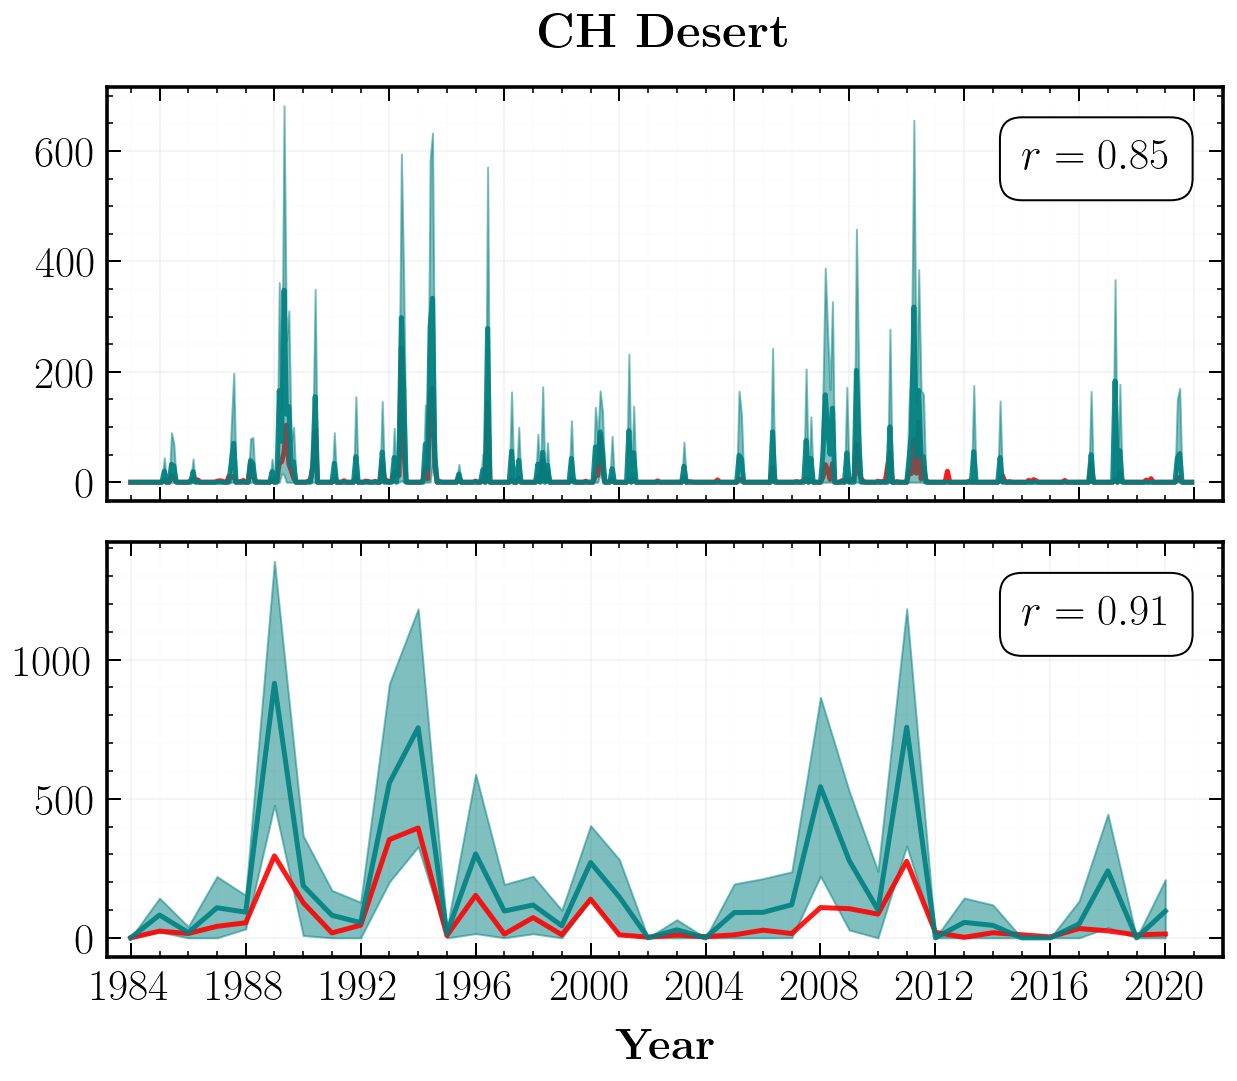

In [162]:
fig, ax= plt.subplots(2, 1, figsize=(10, 8))
pos_arr= [[0.8, 0.08], [0.82, 0.8]]

regindx= 18
pred_comb_sizes= np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
pred_std= 0.5*(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
pred_ext_std= 0.5*(reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
pred_comb_std= np.append(pred_std.iloc[0:break_month], pred_ext_std.iloc[break_month:])
pred_high_1sig= pred_comb_sizes + pred_comb_std
pred_low_1sig= pred_comb_sizes - pred_comb_std
pred_low_1sig[pred_low_1sig < 0]= 0
reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx, final_year= 2020), pred_comb_sizes)[0]

obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx, final_year= 2020)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
pred_ann_sizes, pred_ann_high_1sig, pred_ann_low_1sig= mon_to_ann_size_func(pred_comb_sizes, pred_high_1sig, pred_low_1sig, yr_arr)
reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_ann_sizes)[0]
#rockies_obs_mab_arr.append(obs_sizes)
#rockies_pred_mab_arr.append(pred_ann_sizes)

ax[0].plot(month_arr, mon_burned_area(fire_file, regindx, final_year= 2020)[startmon:], color= 'red', lw= 2.5, label= 'Observed', zorder= 1); #, label= 'Observed'
ax[0].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2.5, label= 'Modeled'); # label= 'Modeled'
ax[0].fill_between(month_arr, pred_high_1sig[startmon:], pred_low_1sig[startmon:], color= 'teal', alpha= 0.5, zorder= 10)
#ax[0].set_ylabel(r'{\bf MAB [${\bf km}^2/{\bf mo}$]}', fontsize= 20, labelpad= 10);
ax[0].set_xlim(-10, 456);
ax[0].set_xticks((year_arr - 1983)*12);
ax[0].set_xticklabels([])
ax[0].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_mon_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[0].transAxes)
ax[0].set_title(r'{\bf %s}'%reg_name[regindx], fontsize= 24, pad= 20);
#ax[0].legend(loc='upper left', frameon= True, fontsize= 20);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

fig.subplots_adjust(hspace= 0.1)

ax[1].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2.5);
ax[1].plot(yr_arr[:-1], pred_ann_sizes, color= 'teal', lw= 2.5);
ax[1].fill_between(yr_arr[:-1], pred_ann_high_1sig, pred_ann_low_1sig, color= 'teal', alpha= 0.5);
#ax[1].set_ylabel(r'{\bf AAB [${\bf km}^2/{\bf mo}$]}', fontsize= 20);
ax[1].set_xlabel(r'{\bf Year}', fontsize= 22);
ax[1].set_xlim(-10, 456);
#ax[1].set_ylim(-250, 6000);
ax[1].set_xticks((year_arr - 1984)*12);
ax[1].set_xticklabels(year_arr)
ax[1].text(pos_arr[1][0], pos_arr[1][1], r'$r = %.2f$'%reg_ann_r_calib, fontsize= 22, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[1].transAxes)
#ax[1].legend(loc='upper left', frameon= True, fontsize= 20);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#fig.savefig('../paper_plots/ml_fire_size_chdesert.pdf', bbox_inches='tight', dpi= 300); #bbox_inches='tight',

In [7]:
for r in tqdm(range(18)):
    reg_mon_r, reg_ann_r, red_chisq= fire_size_metrics(reg_gpd_data_size_df, reg_gpd_ext_data_size_df, fire_file, yr_arr, regindx= r+1, \
                                                                                                             break_month= break_month, finalyr= 2020)
    print("%s (1984-2020)"%reg_name[r+1] + " mon_r:%.2f"%reg_mon_r + " ann_r:%.2f"%reg_ann_r + " chisq:%.2f"%red_chisq)

  6%|▌         | 1/18 [00:51<14:43, 51.96s/it]

Sierra Nevada (1984-2020) mon_r:0.64 ann_r:0.51 chisq:1.44


 11%|█         | 2/18 [01:44<13:55, 52.21s/it]

North Coast (1984-2020) mon_r:0.60 ann_r:0.55 chisq:3.60


 17%|█▋        | 3/18 [02:42<13:47, 55.15s/it]

Central Coast (1984-2020) mon_r:0.51 ann_r:0.65 chisq:1.65


 22%|██▏       | 4/18 [03:28<11:59, 51.39s/it]

South Coast (1984-2020) mon_r:0.59 ann_r:0.64 chisq:2.17


 28%|██▊       | 5/18 [04:14<10:42, 49.39s/it]

Pacific NW (1984-2020) mon_r:0.78 ann_r:0.82 chisq:1.14


 33%|███▎      | 6/18 [04:58<09:30, 47.55s/it]

Columbia Plateau (1984-2020) mon_r:0.63 ann_r:0.75 chisq:0.58


 39%|███▉      | 7/18 [05:42<08:29, 46.30s/it]

Northern Rockies (1984-2020) mon_r:0.93 ann_r:0.92 chisq:0.39


 44%|████▍     | 8/18 [06:27<07:41, 46.12s/it]

Middle Rockies (1984-2020) mon_r:0.87 ann_r:0.87 chisq:1.06


 50%|█████     | 9/18 [07:19<07:11, 47.98s/it]

Southern Rockies (1984-2020) mon_r:0.79 ann_r:0.80 chisq:0.95


 56%|█████▌    | 10/18 [08:05<06:18, 47.25s/it]

AM Semidesert (1984-2020) mon_r:0.87 ann_r:0.95 chisq:0.53


 61%|██████    | 11/18 [09:10<06:09, 52.77s/it]

AZ/NM Mts. (1984-2020) mon_r:0.59 ann_r:0.68 chisq:1.58


 67%|██████▋   | 12/18 [10:04<05:17, 52.91s/it]

IM Semidesert (1984-2020) mon_r:0.89 ann_r:0.85 chisq:0.77


 72%|███████▏  | 13/18 [10:48<04:12, 50.46s/it]

IM Desert (1984-2020) mon_r:0.87 ann_r:0.91 chisq:0.63


 78%|███████▊  | 14/18 [11:36<03:18, 49.56s/it]

Northern Great Plains (1984-2020) mon_r:0.87 ann_r:0.92 chisq:0.61


 83%|████████▎ | 15/18 [12:23<02:26, 48.95s/it]

High Plains (1984-2020) mon_r:0.73 ann_r:0.95 chisq:0.58


 89%|████████▉ | 16/18 [13:09<01:36, 48.01s/it]

Colorado Plateau (1984-2020) mon_r:0.74 ann_r:0.74 chisq:0.44


 94%|█████████▍| 17/18 [14:01<00:49, 49.06s/it]

SW Tablelands (1984-2020) mon_r:0.88 ann_r:0.94 chisq:0.78


100%|██████████| 18/18 [14:48<00:00, 49.34s/it]

CH Desert (1984-2020) mon_r:0.86 ann_r:0.90 chisq:0.49


#### Monthly

In [96]:
ind_grid_1= [[1, 2, 5], [6, 7, 8], [9, 11, 16]]
ind_grid_2= [[12, 13, 14], [10, 15, 17], [3, 4, 18]]

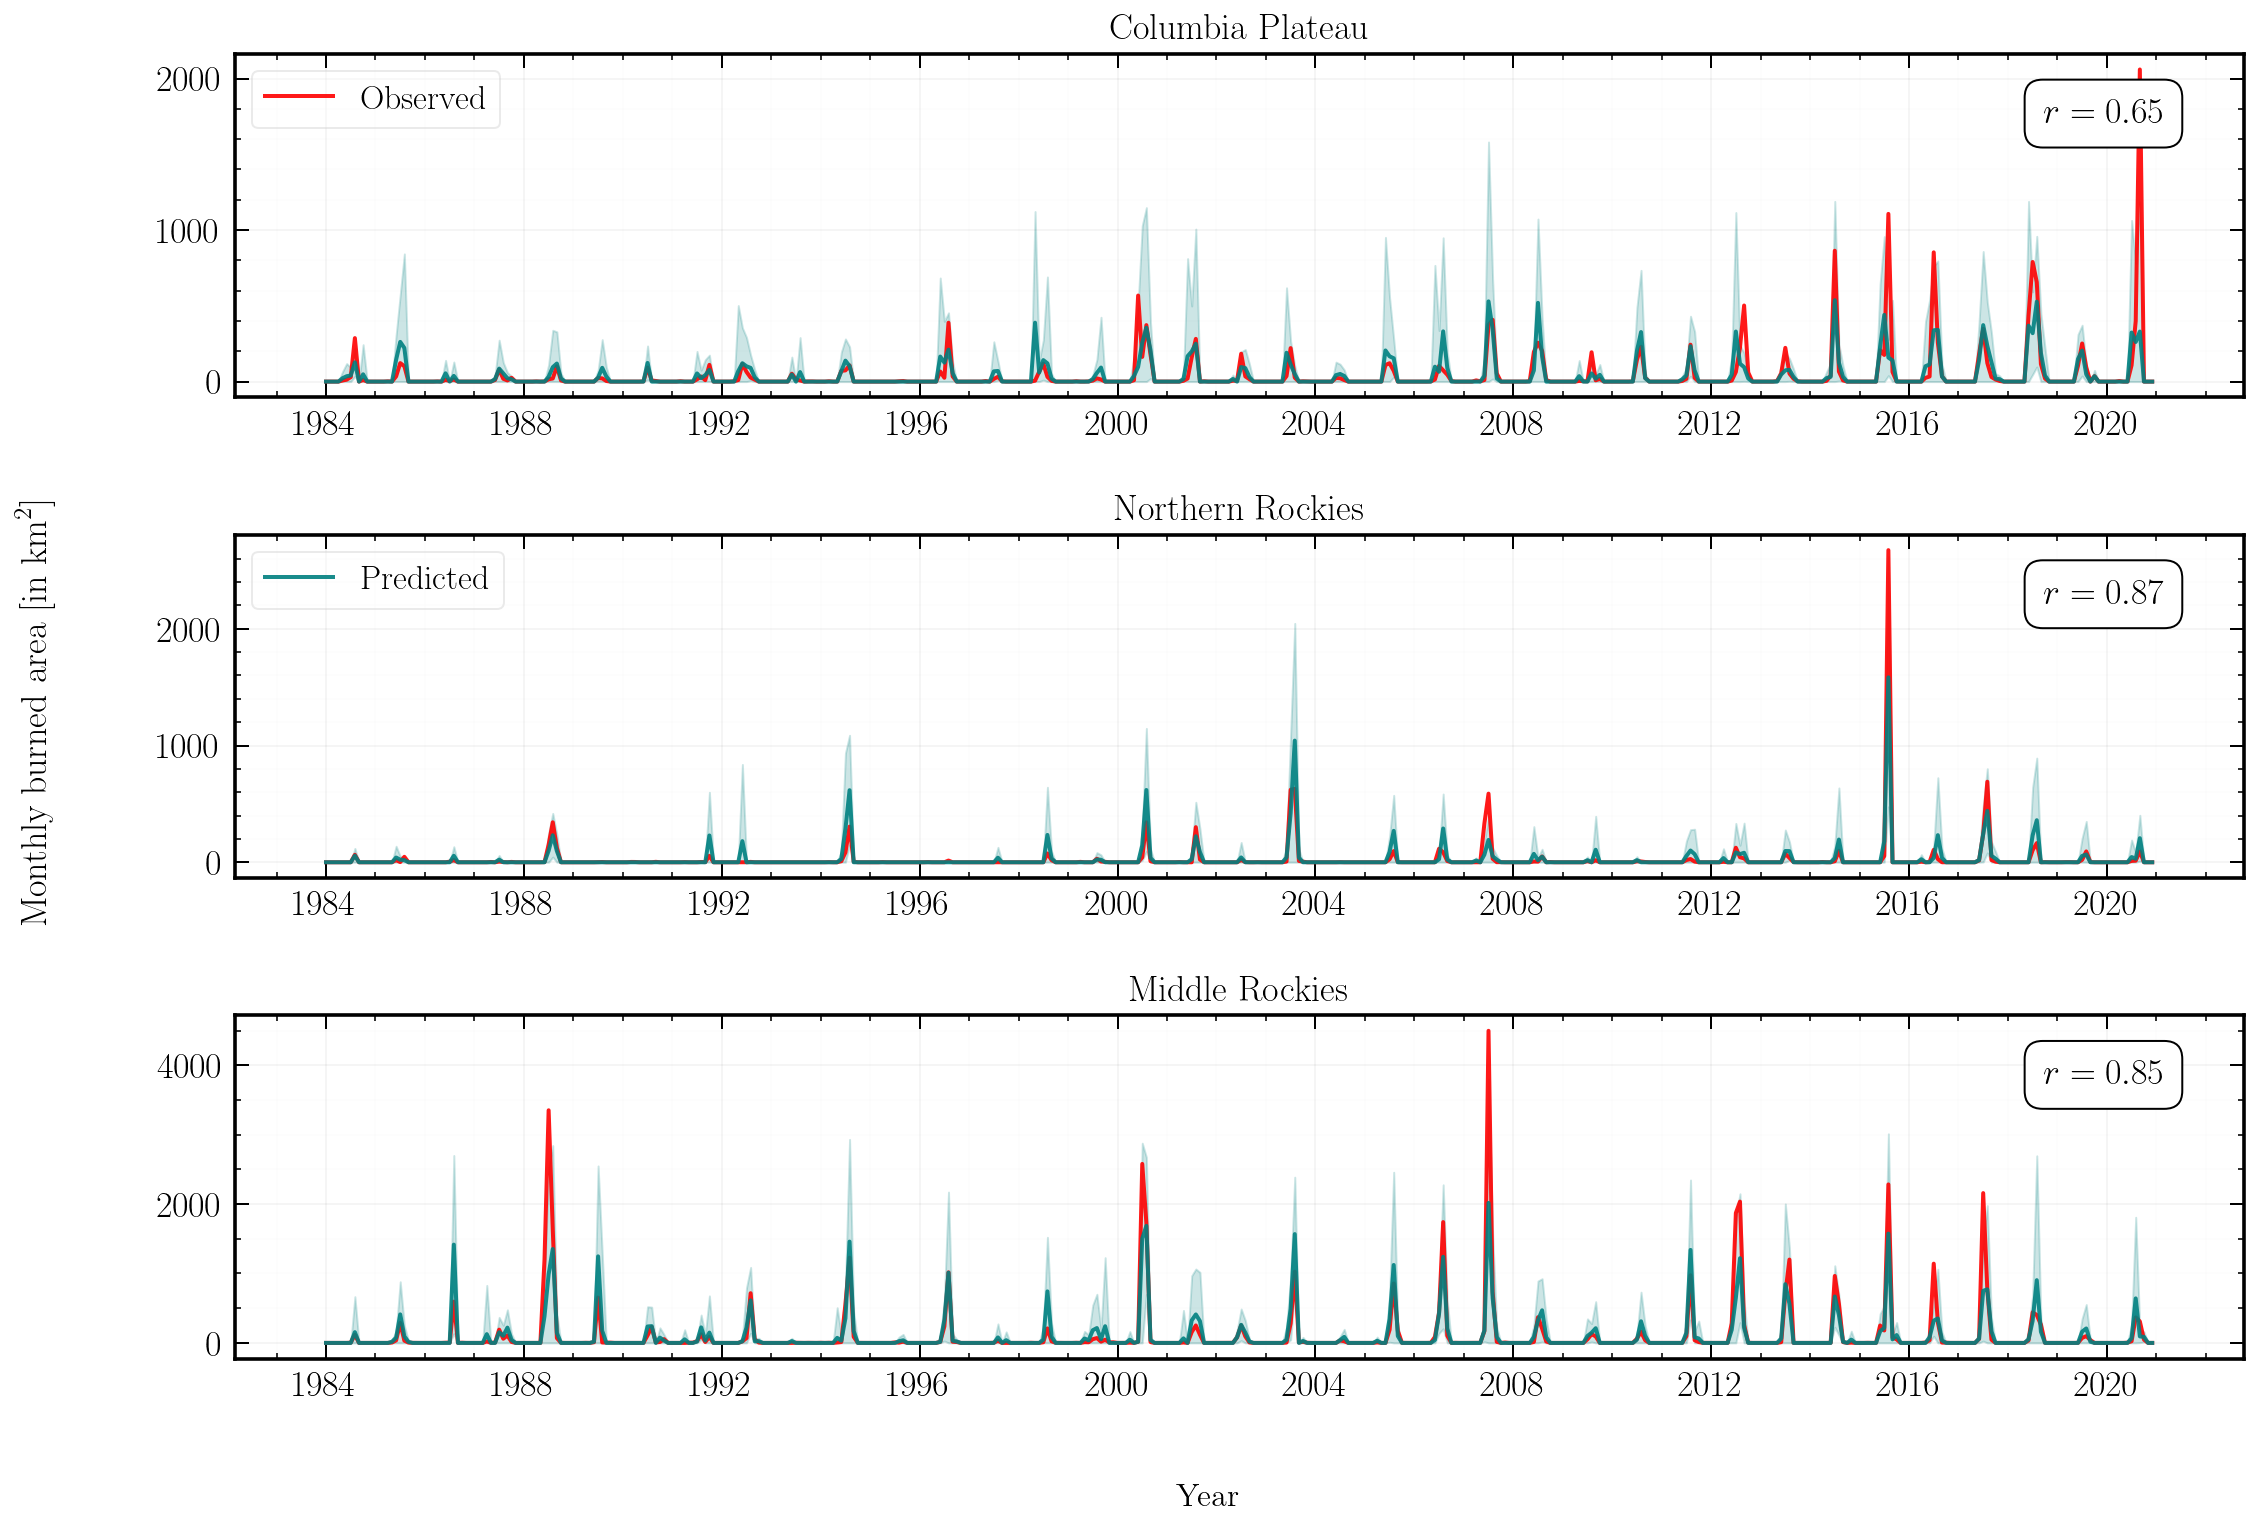

In [98]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in range(3):
    regindx= ind_grid_1[j][i]
    reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx, final_year= 2020), reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'])[0]
        
    if (i==0):
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx, final_year= 2020)[startmon:], color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx, final_year= 2020)[startmon:], color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(month_arr, reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][startmon:], color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][startmon:], color= 'teal', lw= 2);
    ax[i].fill_between(month_arr, reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'][startmon:], reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'][startmon:], \
                                                                                                                             color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12 + startmon);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_gpd_nforest_%d.pdf'%(j+1), bbox_inches='tight');

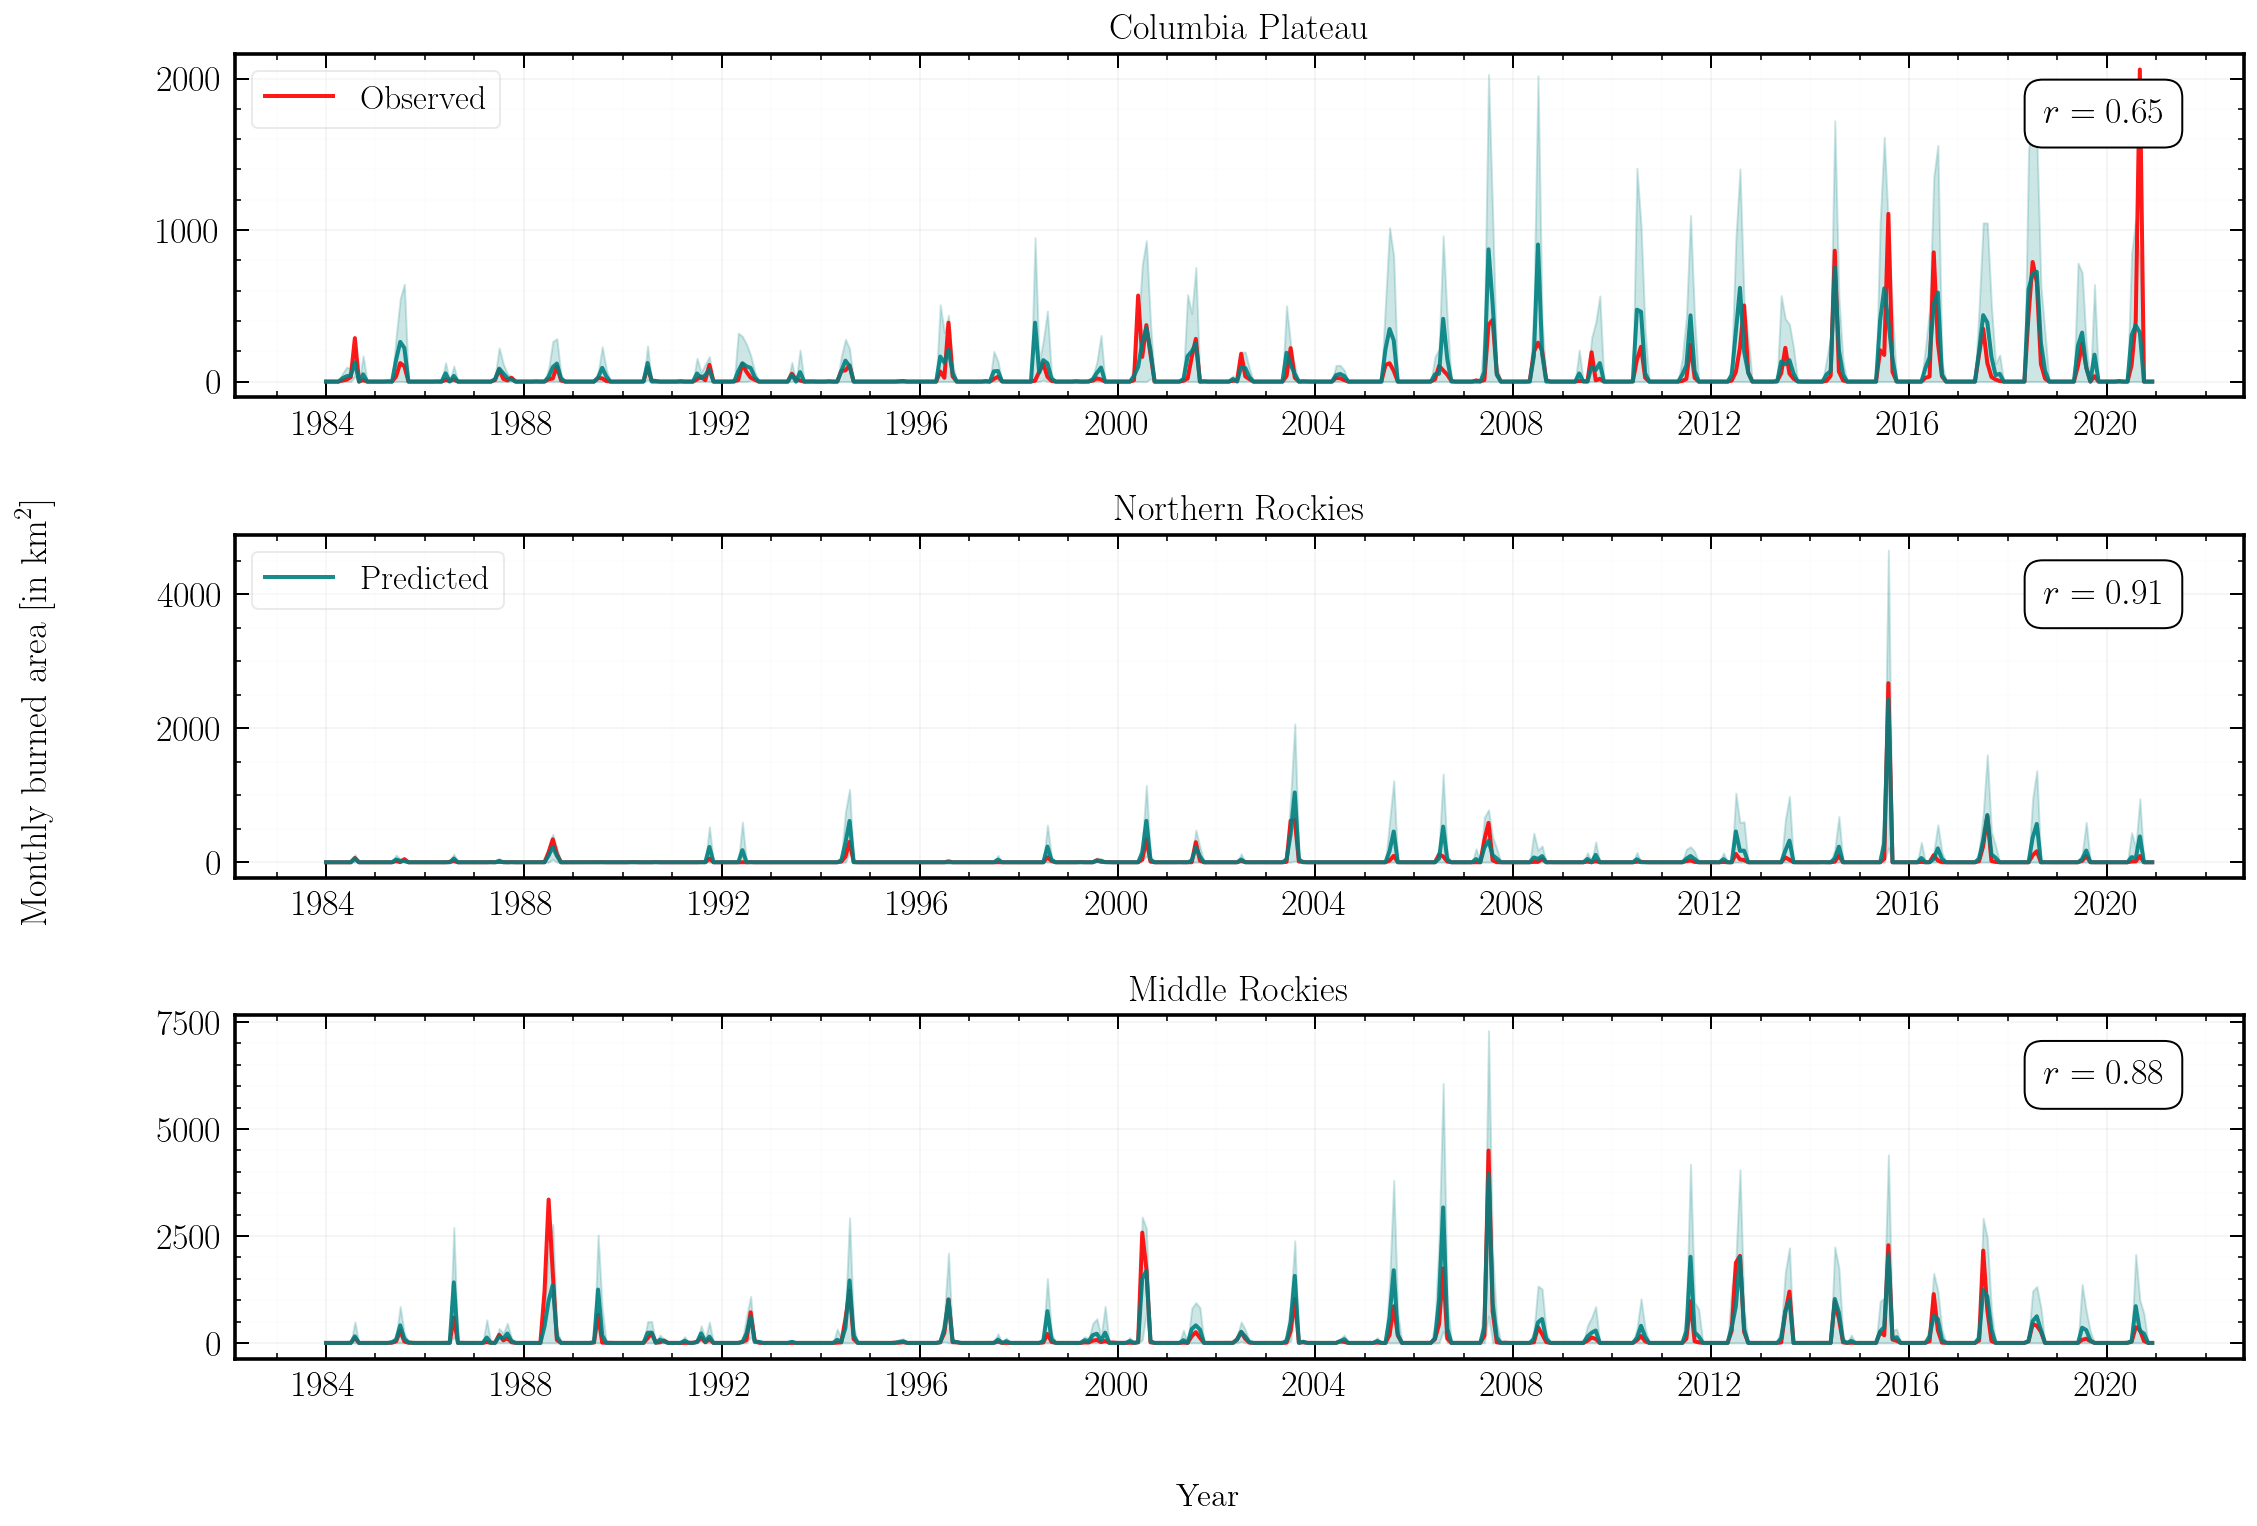

In [100]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in range(3):
    regindx= ind_grid_1[j][i]
    pred_comb_sizes= np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_std= 0.5*(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_ext_std= 0.5*(reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_comb_std= np.append(pred_std.iloc[0:break_month], pred_ext_std.iloc[break_month:])

    pred_high_1sig= pred_comb_sizes + pred_comb_std
    pred_low_1sig= pred_comb_sizes - pred_comb_std
    pred_low_1sig[pred_low_1sig < 0]= 0
    reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx, final_year= 2020), pred_comb_sizes)[0]
        
    if (i==0):
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx, final_year= 2020)[startmon:], color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx, final_year= 2020)[startmon:], color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2);
    ax[i].fill_between(month_arr, pred_high_1sig[startmon:], pred_low_1sig[startmon:], color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12 + startmon);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_combined_ml_freq_data_loc_%d.pdf'%(j+1), bbox_inches='tight');

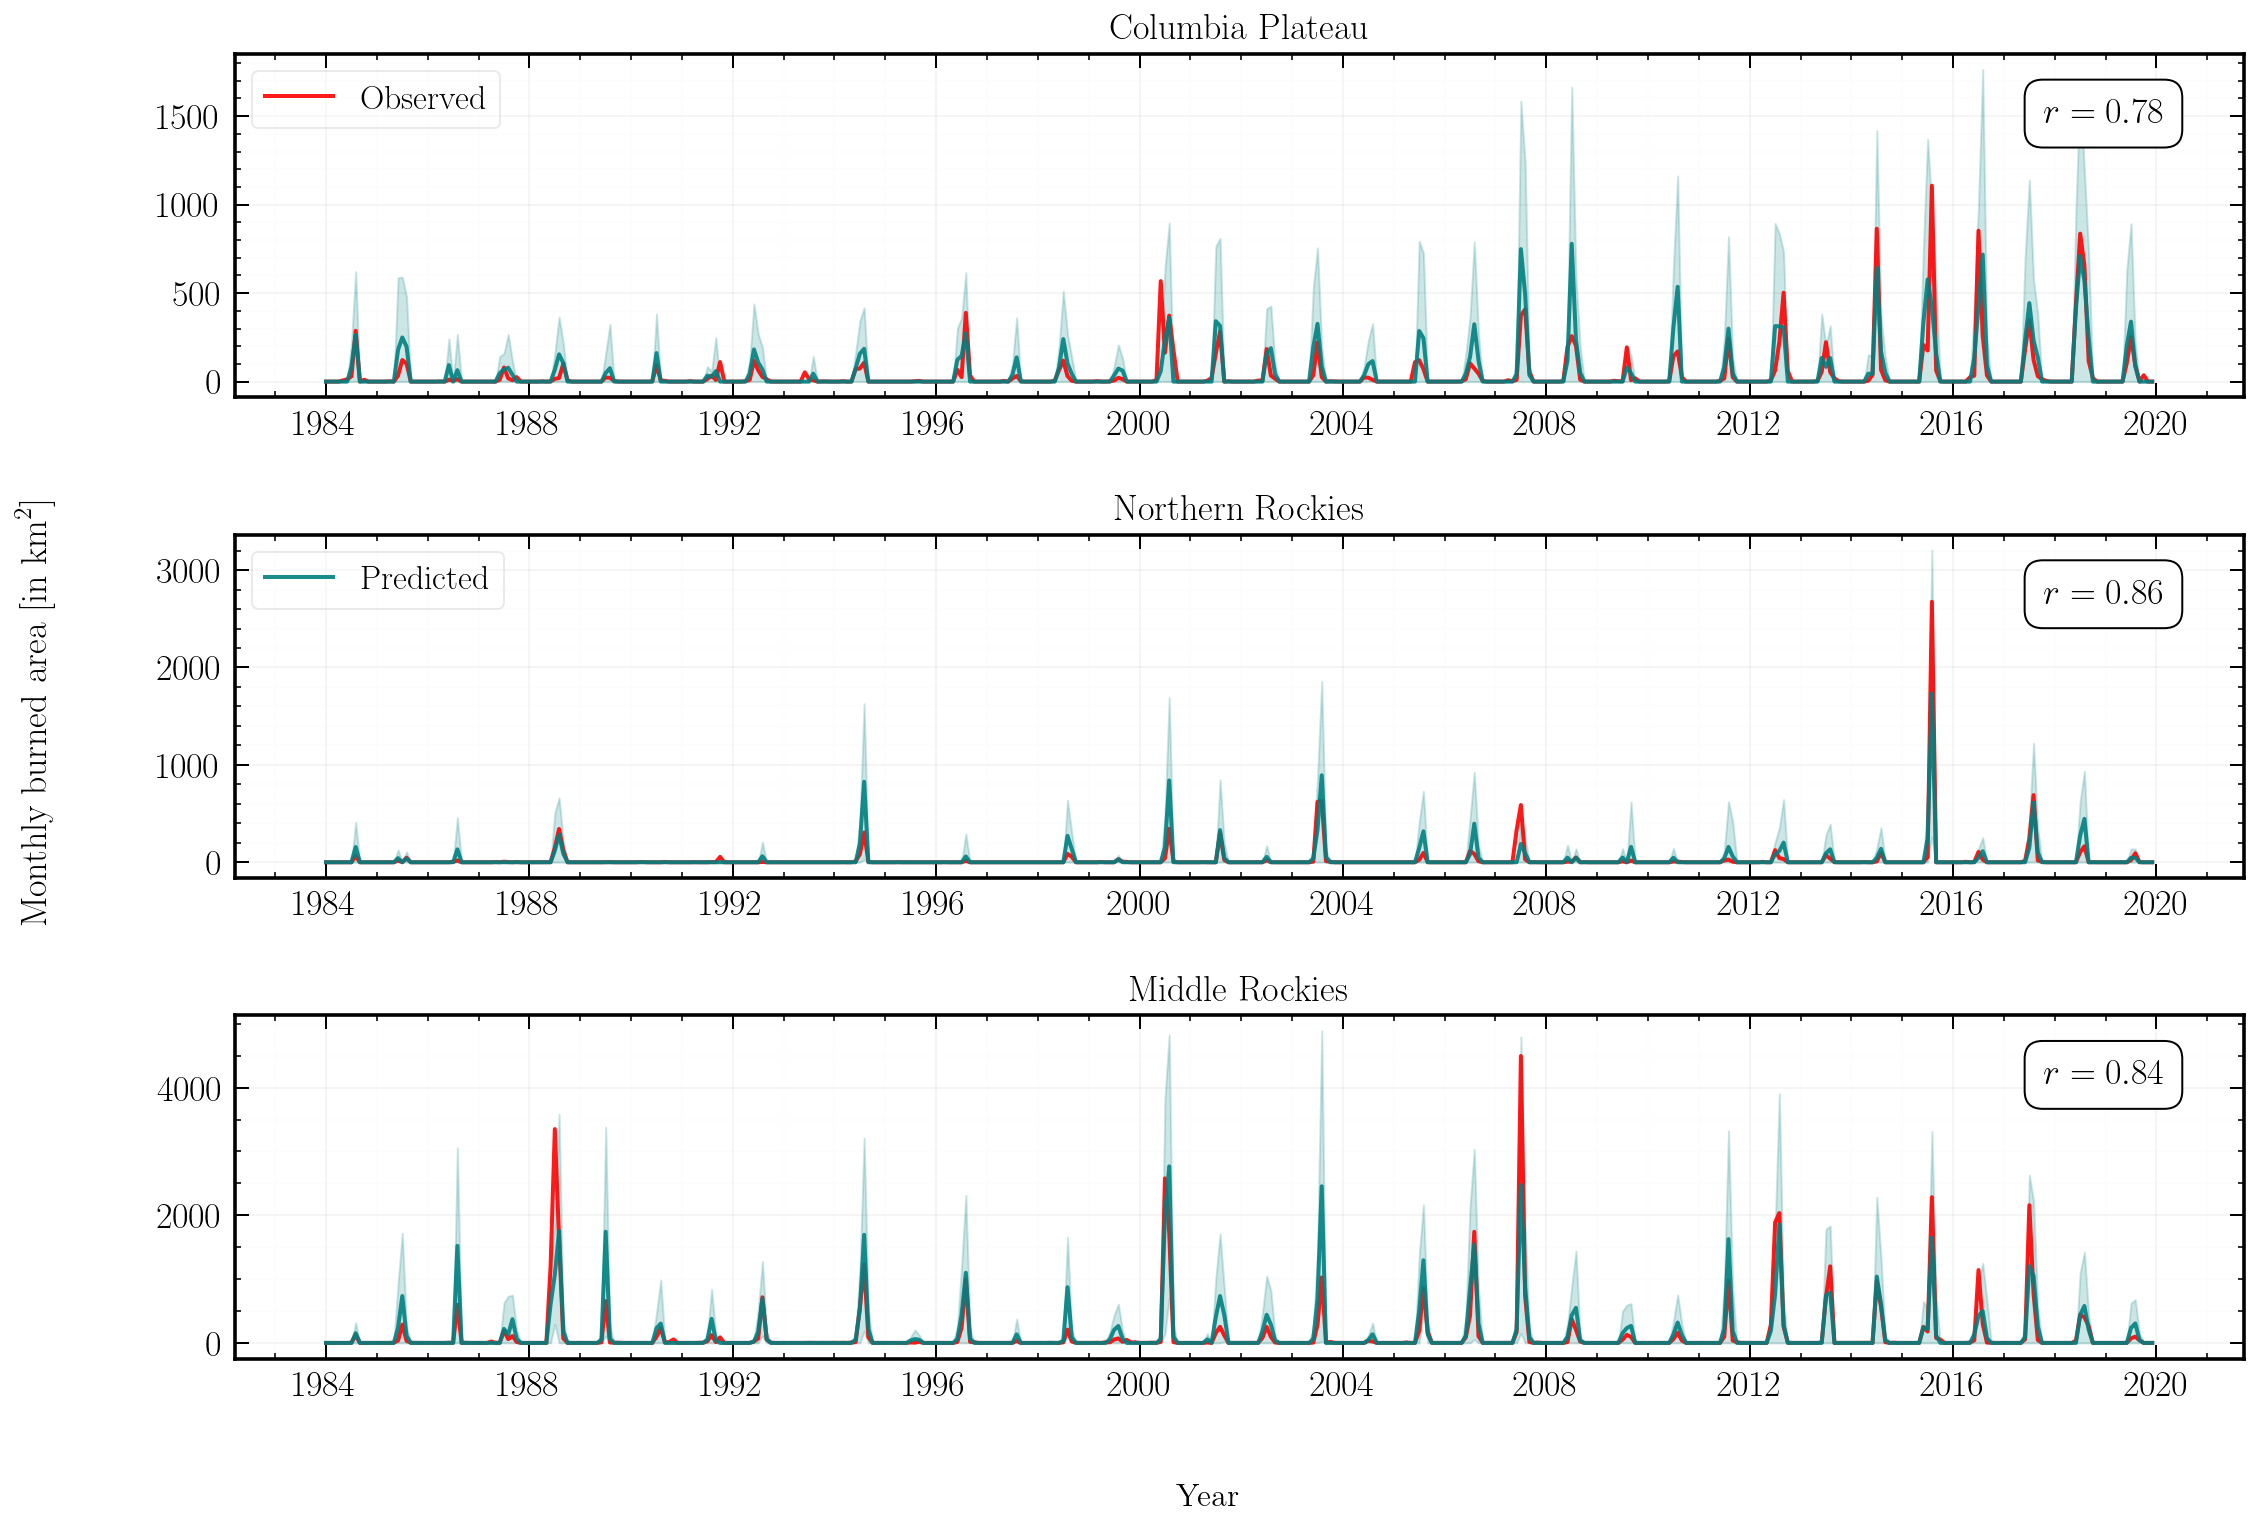

In [123]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in range(3):
    regindx= ind_grid_1[j][i]
    pred_comb_sizes= np.append(reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_std= 0.5*(reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_ext_std= 0.5*(reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                                                            reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])
    pred_comb_std= np.append(pred_std.iloc[0:break_month], pred_ext_std.iloc[break_month:])

    pred_high_1sig= pred_comb_sizes + pred_comb_std
    pred_low_1sig= pred_comb_sizes - pred_comb_std
    pred_low_1sig[pred_low_1sig < 0]= 0
    reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx), pred_comb_sizes)[0]
        
    if (i==0):
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(month_arr, pred_comb_sizes[startmon:], color= 'teal', lw= 2);
    ax[i].fill_between(month_arr, pred_high_1sig[startmon:], pred_low_1sig[startmon:], color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12 + startmon);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_combined_data_freq_ml_loc_%d.pdf'%(j+1), bbox_inches='tight');

#### Annual

100%|█████████████████████████████████████████████| 3/3 [00:57<00:00, 19.20s/it]


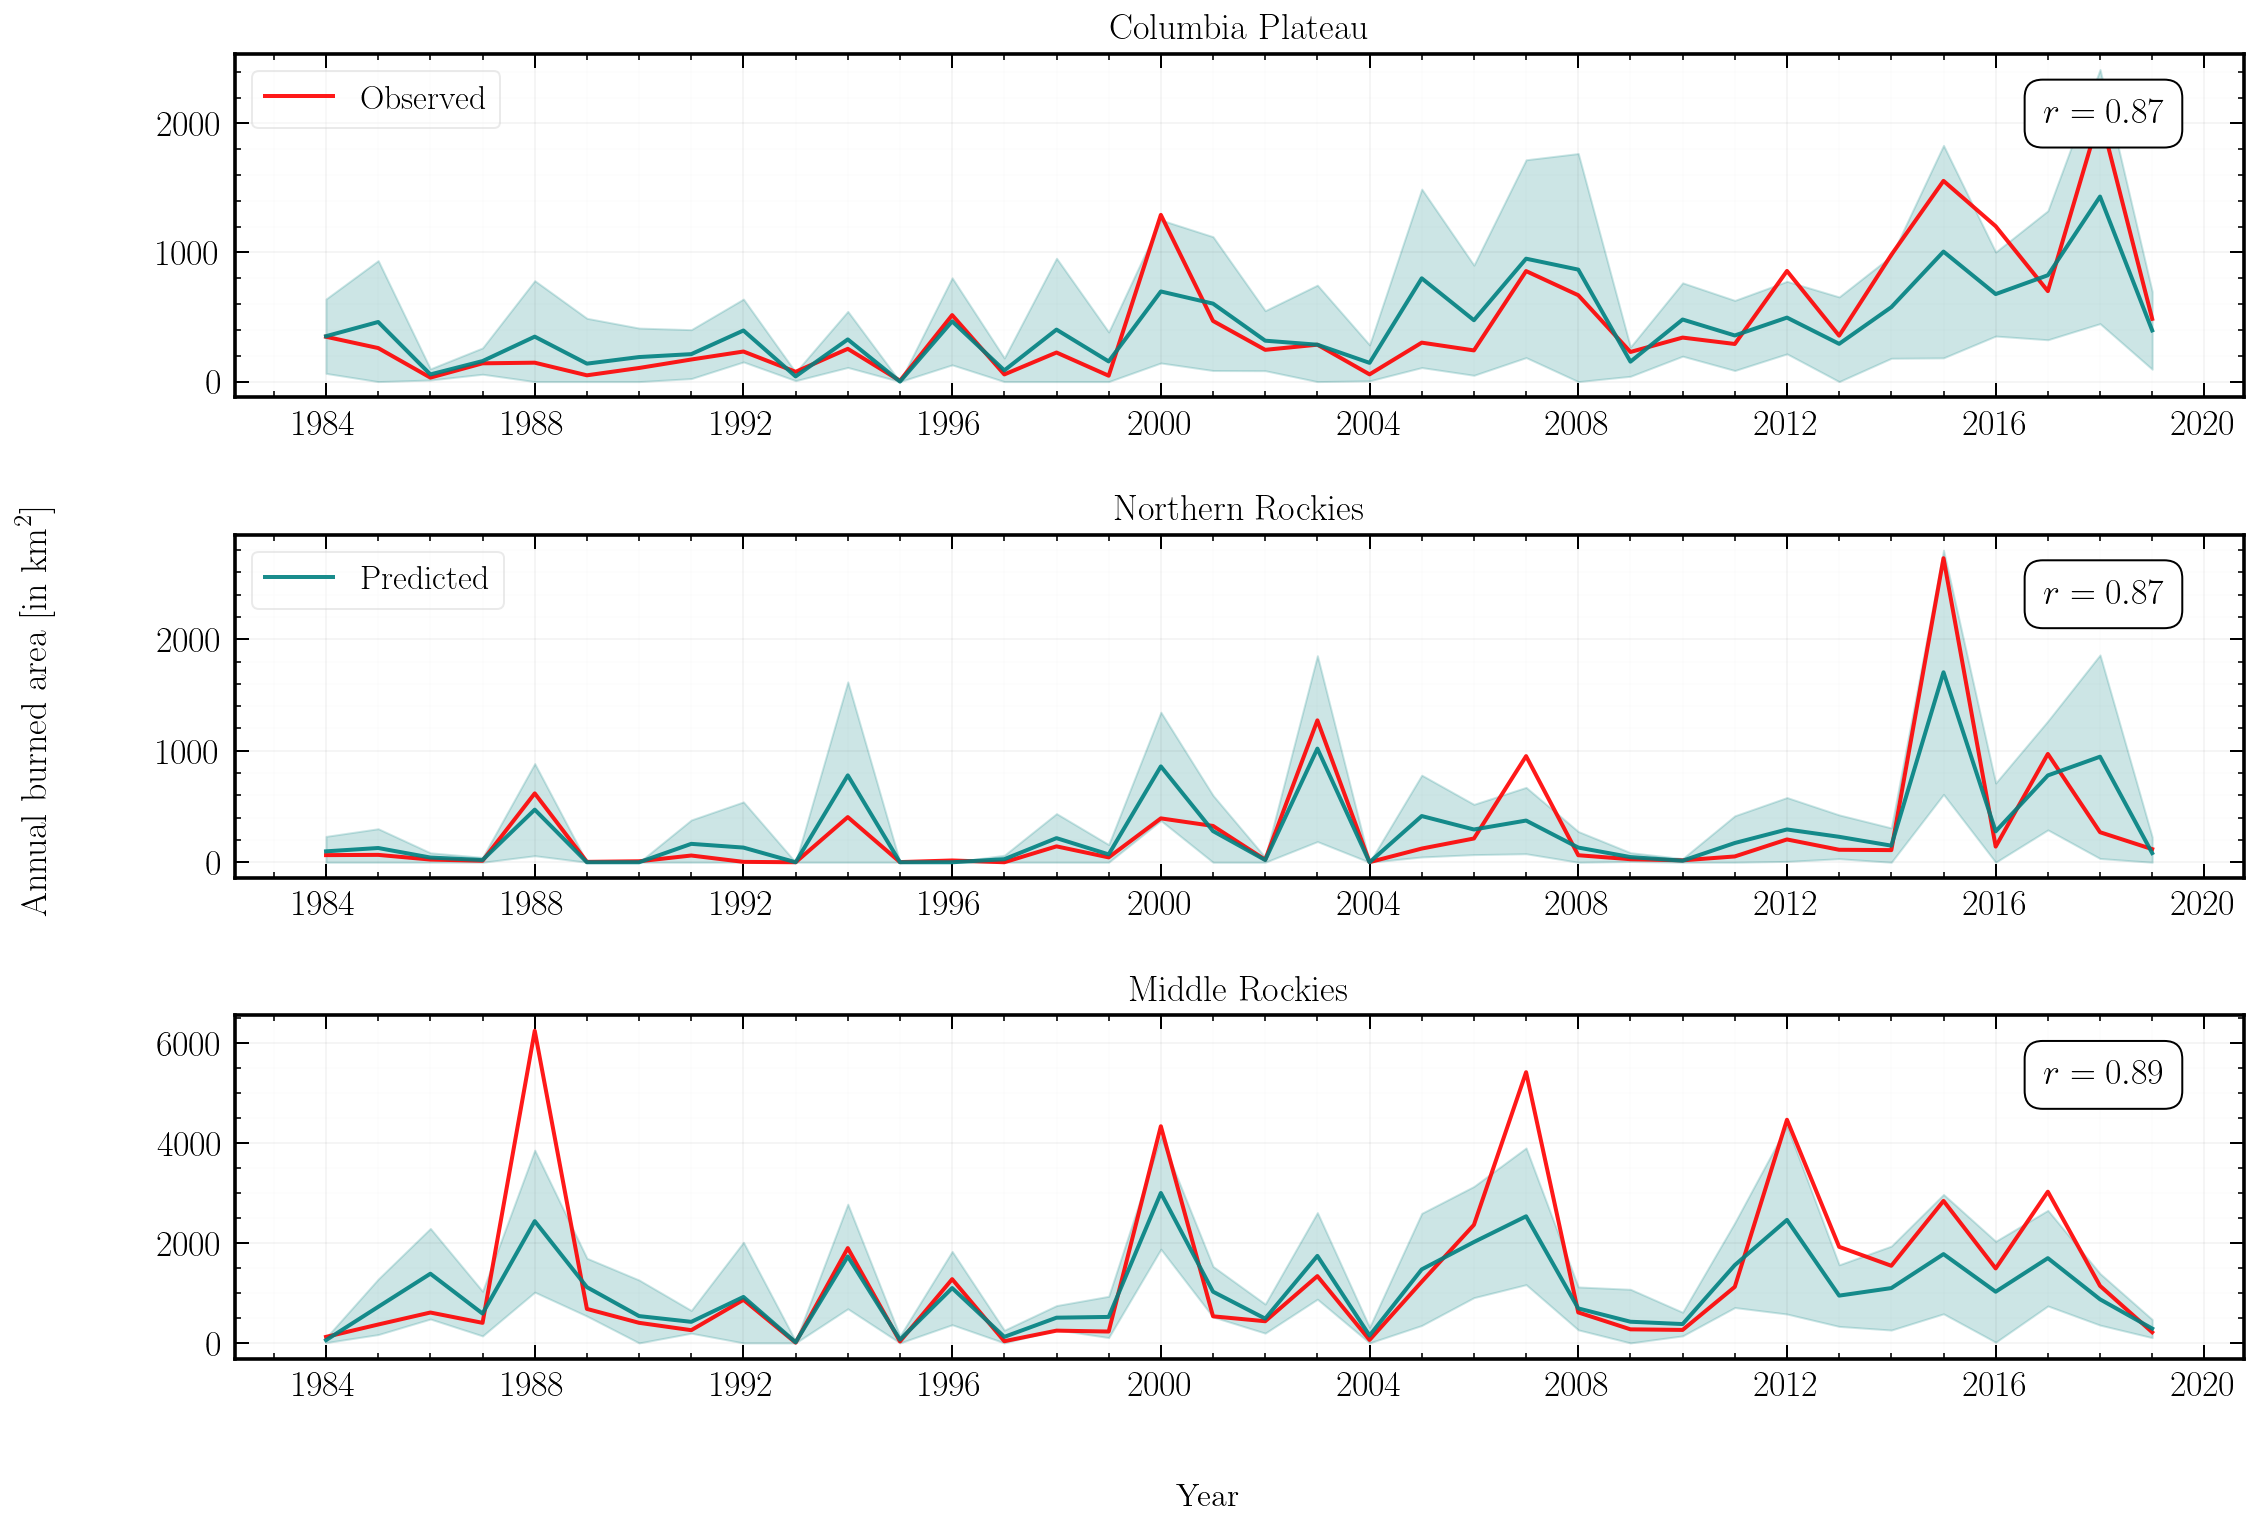

In [89]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in tqdm(range(3)):
    regindx= ind_grid_1[j][i]
    obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
    pred_sizes, pred_high_1sig, pred_low_1sig= mon_to_ann_size_func(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'], \
                                                                reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'],
                                                                reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'], yr_arr)
    reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_sizes)[0]
        
    if (i==0):
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2);
    ax[i].fill_between(yr_arr[:-1], pred_high_1sig, pred_low_1sig, color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_12km_gpd_nforest_%d.pdf'%(j+1), bbox_inches='tight');

100%|█████████████████████████████████████████████| 3/3 [00:56<00:00, 18.96s/it]


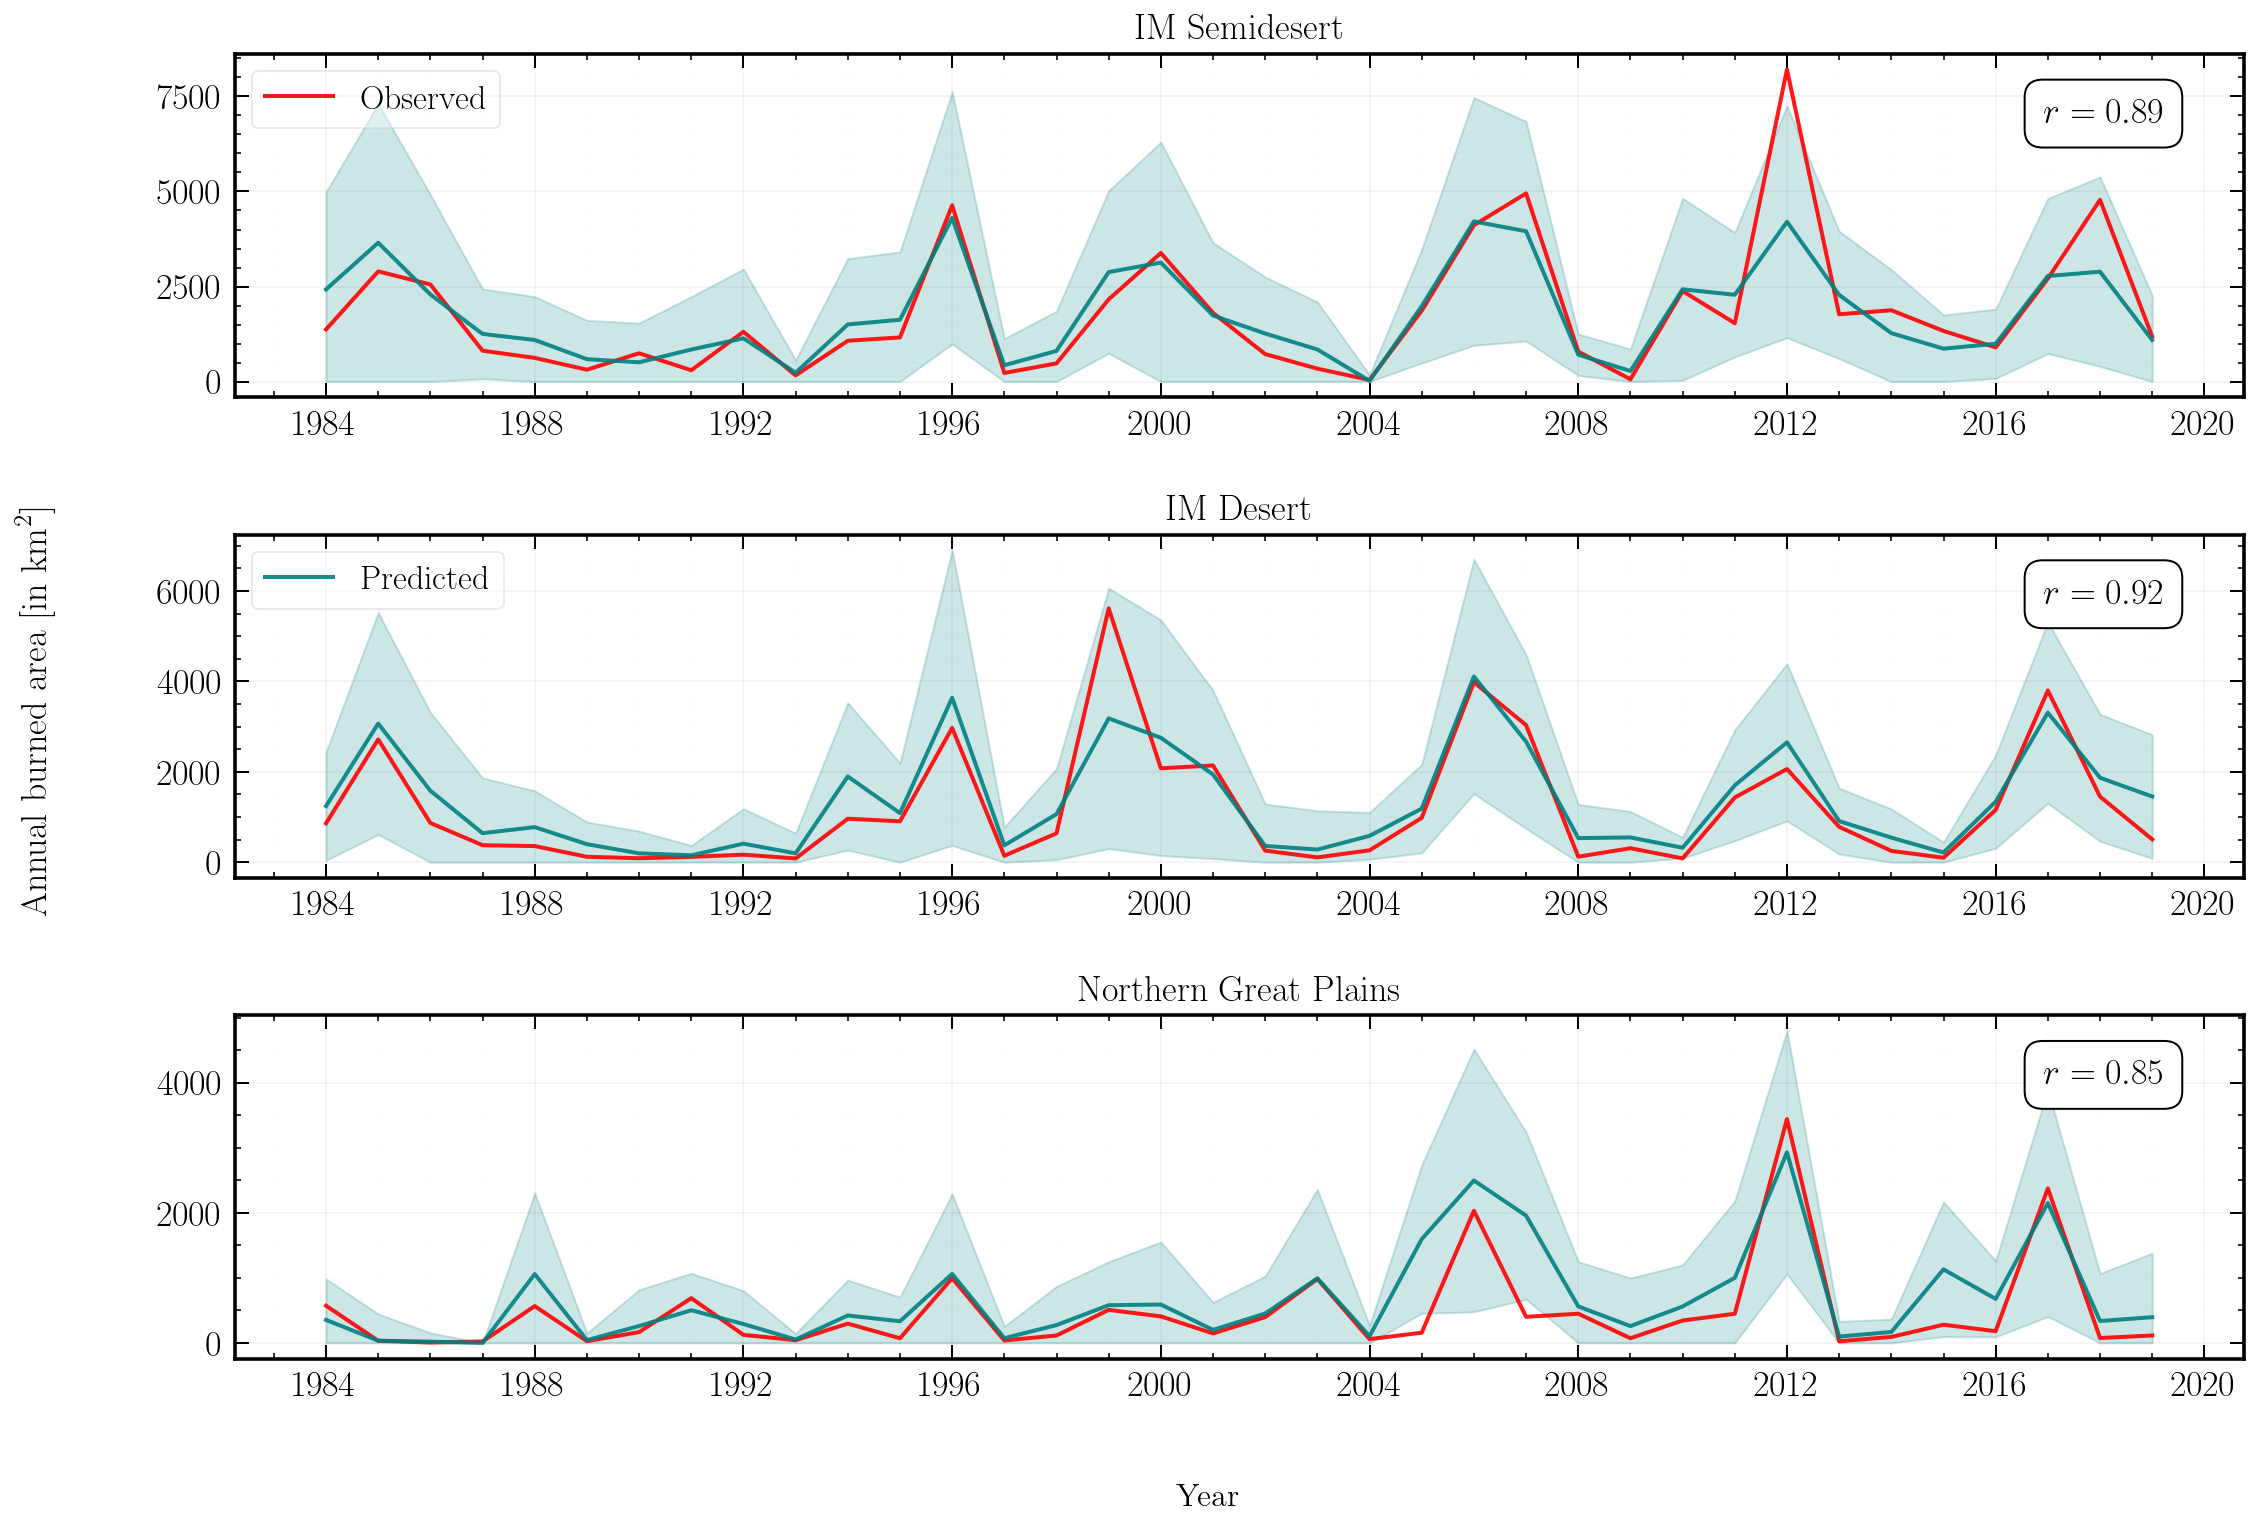

In [196]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 0
for i in tqdm(range(3)):
    regindx= ind_grid_2[j][i]
    obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
    pred_comb_sizes= np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_sizes, pred_high_1sig, pred_low_1sig= mon_to_ann_size_func(pred_comb_sizes, \
                                                                reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'],
                                                                reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'], yr_arr)
    reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_sizes)[0]
        
    if (i==0):
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2);
    ax[i].fill_between(yr_arr[:-1], pred_high_1sig, pred_low_1sig, color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_12km_combined_ml_freq_data_loc_%d.pdf'%(j+1), bbox_inches='tight');

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.03s/it]


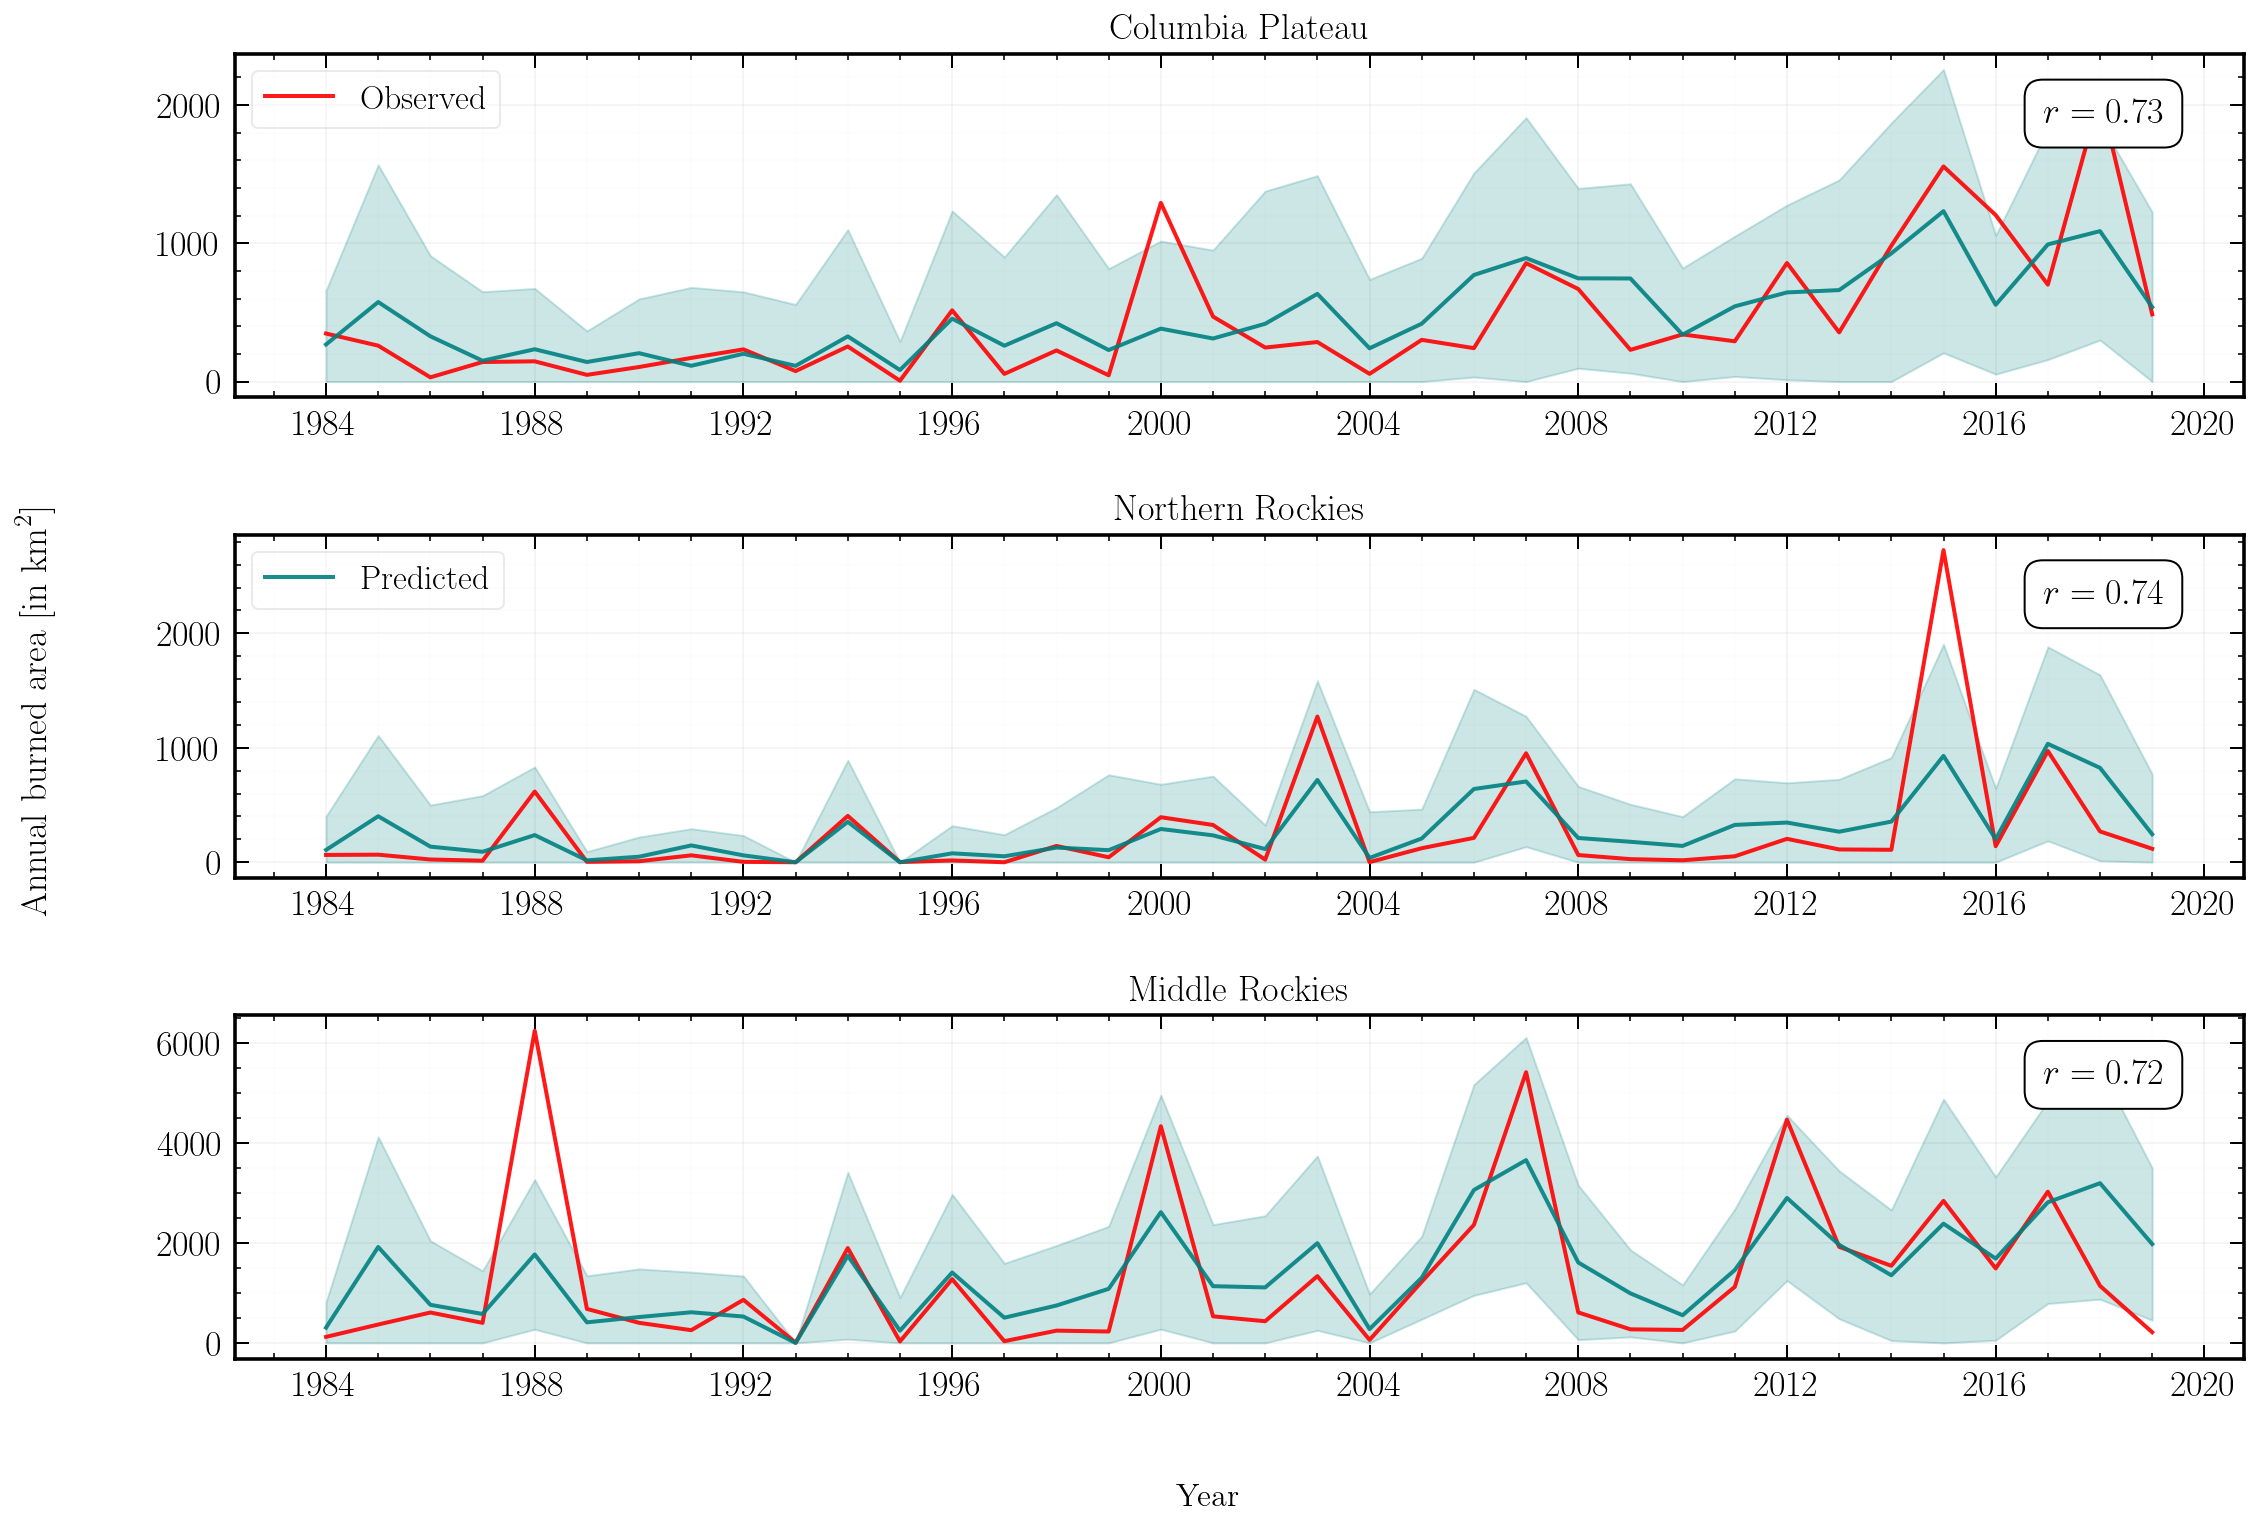

In [15]:
fig, ax= plt.subplots(3, 1, figsize=(18, 12))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

j= 1
for i in tqdm(range(3)):
    regindx= ind_grid_1[j][i]
    obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
    pred_comb_sizes= np.append(reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[0:break_month], reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['mean_size'].iloc[break_month:])
    pred_sizes, pred_high_1sig, pred_low_1sig= mon_to_ann_size_func(pred_comb_sizes, \
                                                                reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'],
                                                                reg_ml_gpd_ext_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'], yr_arr)
    reg_ann_r_calib= stats.pearsonr(obs_sizes, pred_sizes)[0]
        
    if (i==0):
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2, label= 'Observed');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], obs_sizes, color= 'red', lw= 2);
    if (i==1):
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2, label= 'Predicted');
        ax[i].legend(loc='upper left', frameon= True);
    else:
        ax[i].plot(yr_arr[:-1], pred_sizes, color= 'teal', lw= 2);
    ax[i].fill_between(yr_arr[:-1], pred_high_1sig, pred_low_1sig, color= 'teal', alpha=0.2);
    ax[i].text(0.9, 0.8, r'$r = %.2f$'%reg_ann_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    ax[i].set_title(reg_name[regindx], fontsize= 18);
    ax[i].set_xticks((year_arr - 1984)*12);
    ax[i].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
    fig.subplots_adjust(hspace= 0.4)
        #fig.minorticks_on()
    ax[i].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
    ax[i].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
    ax[i].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_12km_combined_ml_freq_ml_loc_%d.pdf'%(j+1), bbox_inches='tight');

### 4.4 Summary statistics plot

In [10]:
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test, size_scaler= fire_size_data(res= '12km', \
                            dropcols= drop_col_func(mod_type= 'normal'), start_month= 420, tot_test_months= 12, threshold= 4, tflag= True) #tflag= True

X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 1158.22it/s]


In [ ]:
# extreme years: 1996, 2007, 2012, 2017, 2018; 1988, 1996, 2007, 2012, 2020

In [34]:
wus_2012_pab, wus_2012_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2012], rseed= 99)
wus_2020_pab, wus_2020_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2020], inf_fac= 5.0, rseed= 67)
forest_2012_pab, forest_2012_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2012], \
                                                           reglist= [0, 1, 2, 3, 4, 6, 7, 8, 10], rseed= 99)
forest_2020_pab, forest_2020_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2020], inf_fac= 5.0, \
                                                           reglist= [0, 1, 2, 3, 4, 6, 7, 8, 10], rseed= 11)
desert_2012_pab, desert_2012_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2012], \
                                                           reglist= [5, 9, 11, 12, 15, 16, 17], rseed= 99)
desert_2020_pab, desert_2020_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2020], inf_fac= 5.0, \
                                                           reglist= [5, 9, 11, 12, 15, 16, 17], rseed= 13)
plains_2012_pab, plains_2012_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2012], \
                                                           reglist= [13, 14], rseed= 99)
plains_2020_pab, plains_2020_eab= ann_size_percentile_func(mdn_model= mdn_gpd_ext_mod, firefile= fire_file, fire_size_df= fire_size_tot, X_sizes_dat= X_sizes_tot, extyeararr= [2020], inf_fac= 5.0, \
                                                           reglist= [13, 14], rseed= 13)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


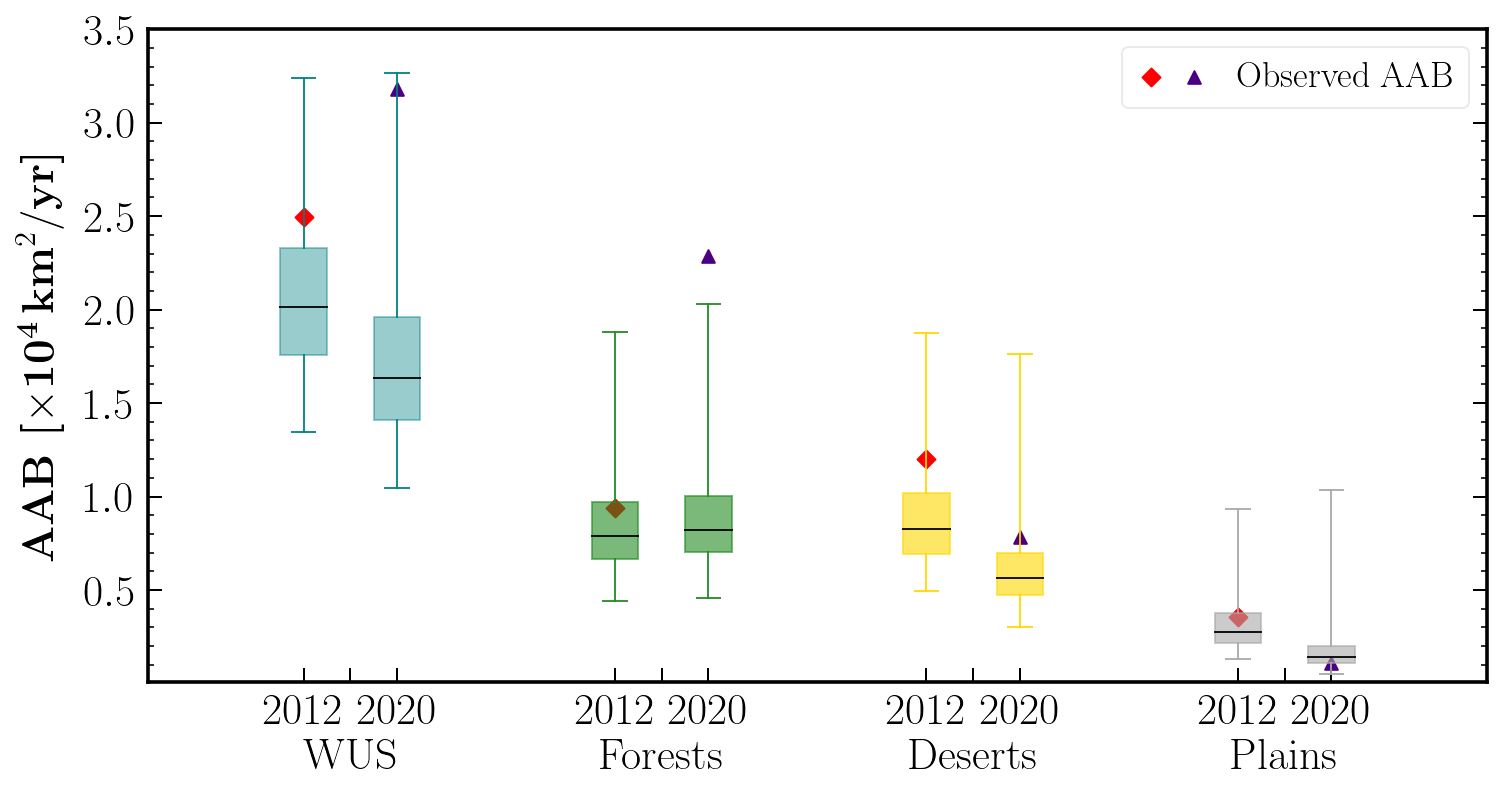

In [35]:
fig, ax= plt.subplots(1, 1, figsize= (12, 6));
c= 'teal'
c2= 'forestgreen'
c3= 'gold'
c4= 'darkgray'
norm_fac= 10**4
plt.boxplot([np.mean(wus_2012_pab, axis= 0)/norm_fac, [], np.mean(wus_2020_pab, axis= 0)/norm_fac], whis= (0.5, 99.5), positions= [1, 1.15, 1.3], showfliers= False,\
                                                                                                    patch_artist=True,
                                                                                                    boxprops=dict(facecolor=c, color=c, alpha= 0.4),
                                                                                                    capprops=dict(color=c),
                                                                                                    medianprops= dict(color= 'black'),
                                                                                                    whiskerprops=dict(color=c));
plt.boxplot([np.mean(forest_2012_pab, axis= 0)/norm_fac, [], np.mean(forest_2020_pab, axis= 0)/norm_fac], whis= (0.5, 99.5), positions= [2, 2.15, 2.3], showfliers= False,\
                                                                                                    patch_artist=True,
                                                                                                    boxprops=dict(facecolor=c2, color=c2, alpha= 0.6),
                                                                                                    capprops=dict(color=c2),
                                                                                                    medianprops= dict(color= 'black'),
                                                                                                    whiskerprops=dict(color=c2));
plt.boxplot([np.mean(desert_2012_pab, axis= 0)/norm_fac, [], np.mean(desert_2020_pab, axis= 0)/norm_fac], whis= (0.5, 99.5), positions= [3, 3.15, 3.3], showfliers= False,\
                                                                                                    patch_artist=True,
                                                                                                    boxprops=dict(facecolor=c3, color=c3, alpha= 0.6),
                                                                                                    capprops=dict(color=c3),
                                                                                                    medianprops= dict(color= 'black'),
                                                                                                    whiskerprops=dict(color=c3));
plt.boxplot([np.mean(plains_2012_pab, axis= 0)/norm_fac, [], np.mean(plains_2020_pab, axis= 0)/norm_fac], whis= (0.5, 99.5), positions= [4, 4.15, 4.3], showfliers= False,\
                                                                                                    patch_artist=True,
                                                                                                    boxprops=dict(facecolor=c4, color=c4, alpha= 0.6),
                                                                                                    capprops=dict(color=c4),
                                                                                                    medianprops= dict(color= 'black'),
                                                                                                    whiskerprops=dict(color=c4));
p1= plt.scatter(1, np.mean(wus_2012_eab)/norm_fac, marker= 'D', s= 40, color= 'red');
p2= plt.scatter(1.3, np.mean(wus_2020_eab)/norm_fac, marker= '^', s= 40, color= 'indigo');
plt.scatter(2, np.mean(forest_2012_eab)/norm_fac, marker= 'D', s= 40, color= 'red');
plt.scatter(2.3, np.mean(forest_2020_eab)/norm_fac, marker= '^', s= 40, color= 'indigo');
plt.scatter(3, np.mean(desert_2012_eab)/norm_fac, marker= 'D', s= 40, color= 'red');
plt.scatter(3.3, np.mean(desert_2020_eab)/norm_fac, marker= '^', s= 40, color= 'indigo');
plt.scatter(4, np.mean(plains_2012_eab)/norm_fac, marker= 'D', s= 40, color= 'red');
plt.scatter(4.3, np.mean(plains_2020_eab)/norm_fac, marker= '^', s= 40, color= 'indigo');
plt.scatter([], [], color='b', label='data2')
#plt.yscale('log');
ax.set_xticklabels(['2012', '\n WUS', '2020', '2012', '\n Forests', '2020', '2012', '\n Deserts', '2020', '2012', '\n Plains', '2020']);
plt.ylim(0.01, 3.5);
ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 22);
ax.tick_params(bottom= False, which='minor', labelsize= 22);
ax.legend([(p1, p2)], ['Observed AAB'], handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize= 18, frameon= True, loc= 'upper right')

ax.set_ylabel(r'{\bf AAB [${\bf \times 10^4} \, {\bf km}^2/{\bf yr}$]}', fontsize= 22, labelpad= 10);
#fig.savefig('../paper_plots/ext_fyr_aab.pdf', bbox_inches='tight', dpi= 300);

### 4.5 SHAP plots

In [83]:
size_id= '07_23_22' #'06_04_22'
X_plot_size_df= pd.read_hdf('../sav_files/shap_files/fire_size_data_%s.h5'%size_id)
reg_size_shap_df= pd.read_hdf('../sav_files/shap_files/fire_size_shap_%s.h5'%size_id)

In [84]:
reg_size_shap_df.columns

Index(['Tmax', 'VPD', 'Prec', 'Antprec_lag1', 'Forest', 'Wind', 'Grassland',
       'FM1000', 'AvgVPD_3mo', 'Avgprec_3mo', 'Urban', 'FFWI_max3', 'Tmin',
       'Camp_dist', 'Road_dist', 'Antprec_lag2', 'VPD_max3', 'Tmax_max3',
       'Tmin_max3', 'Slope', 'Southness', 'SWE_mean', 'SWE_max', 'AvgSWE_3mo',
       'Biomass', 'Popdensity', 'Housedensity'],
      dtype='object')

#### WUS feature importance

In [10]:
X_plot_size_df.columns= ['Tmax', 'VPD', 'Prec', r'${\rm AntPrec}_{\rm 1yr}$', 'Forest', 'Wind', 'Grassland', 'FM1000', r'${\rm AntVPD}_{\rm 3mo}$', r'${\rm AntPrec}_{\rm 3mo}$', 'Urban', \
                    r'${\rm FFWI}^{\rm max3}$', 'Tmin', 'Campdist', 'Roaddist', r'${\rm AntPrec}_{\rm 2yr}$', r'${\rm VPD}^{\rm max3}$', r'${\rm Tmax}^{\rm max3}$',  r'${\rm Tmin}^{\rm max3}$', 'Slope', \
                    'Southness', r'${\rm SWE}_{\rm mean}$', r'${\rm SWE}_{\rm max}$', r'${\rm AvgSWE}_{\rm 3mo}$', 'Biomass', 'Popdensity', 'Housedensity', 'reg_indx'] # 'Tmin', 'Elev',

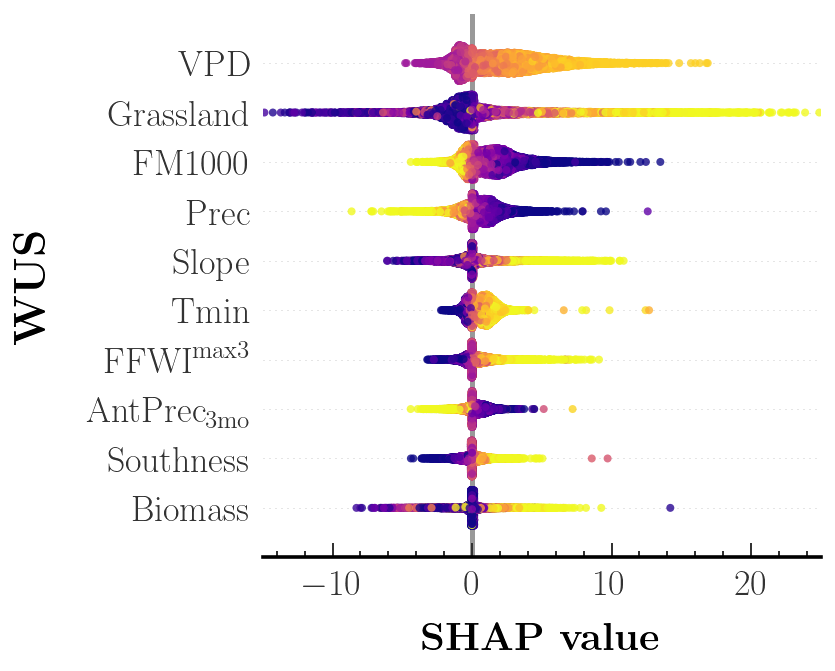

In [44]:
shap.summary_plot(np.array(reg_size_shap_df), X_plot_size_df.drop(columns= ['reg_indx']), max_display= 10, plot_size= (5, 5), show= False, alpha= 0.8, color_bar= False, cmap= plt.cm.plasma)
fig, ax= plt.gcf(), plt.gca()
fig.text(-0.22, 0.5, r'{\bf WUS}', va='center', rotation= 'vertical', fontsize= 22);
ax.set_xlim(-15, 25);
ax.tick_params(labeltop=False, top=False, labelright=False, right=False, which='both', labelsize= 18);
ax.set_xlabel(r'{\bf SHAP value}', fontsize= 20);
#plt.colorbar(shrink= 0.9);
plt.clim(-3,3);
#plt.savefig('../paper_plots/shap_size_summary.pdf', bbox_inches='tight', dpi= 300);

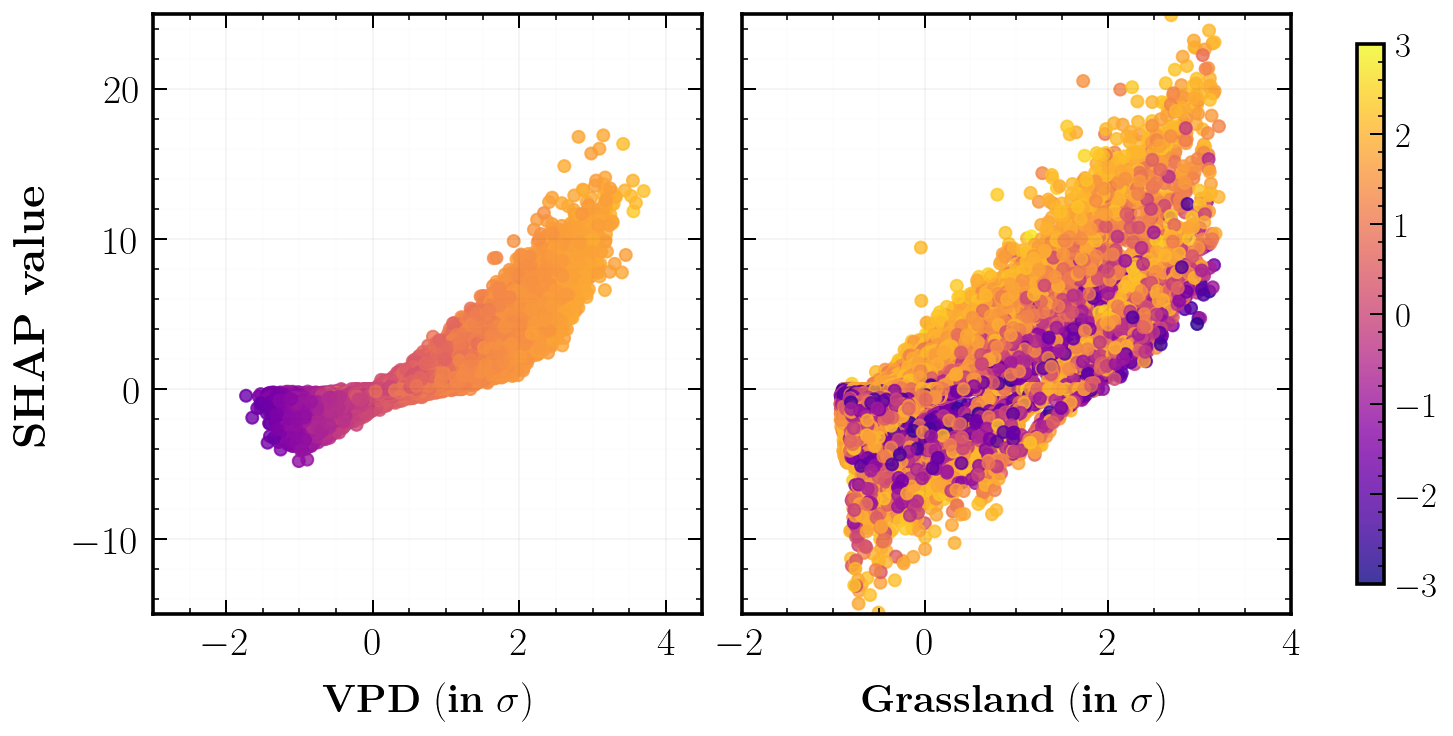

In [43]:
fig, ax= plt.subplots(1, 2, figsize= (10, 5) , constrained_layout= True)
CS0= ax[0].scatter(X_plot_size_df['VPD'], reg_size_shap_df['VPD'], alpha=0.8, c= X_plot_size_df['Tmax'], cmap= plt.cm.plasma)
ax[0].set_xlabel(r'${\bf {\rm \bf VPD \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[0].set_ylim(-15, 25);
ax[0].set_xlim(-3, 4.5);
ax[0].set_ylabel(r'{\bf SHAP value}', fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].scatter(X_plot_size_df['Grassland'], reg_size_shap_df['Grassland'], alpha= 0.8, c= X_plot_size_df['Tmax'], cmap= plt.cm.plasma)
ax[1].set_xlabel(r'${\bf {\rm \bf Grassland \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[1].set_ylim(-15, 25);
ax[1].set_xlim(-2, 4);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].set_yticklabels([]);
cbar= fig.colorbar(CS0, ax= ax[:], shrink= 0.9);
CS0.set_clim(-3,3);
#plt.savefig('../paper_plots/shap_size_dependence.jpg', bbox_inches='tight', dpi= 300);

#### Regional feature importance

In [85]:
tmp_size_ind_vals= []
for r in range(18):
    tmp_size_ind_vals.append(np.argsort(np.mean(abs(reg_size_shap_df.iloc[X_plot_size_df.groupby('reg_indx').get_group(r+1).index].values), axis= 0)))
    print("Top %s"%reg_name[r+1] + " size predictors: %s"%np.array(X_plot_size_df.columns[tmp_size_ind_vals[r]][::-1][0:8]))

Top Sierra Nevada size predictors: ['VPD' 'Slope' 'FM1000' 'Biomass' 'Tmin' 'Grassland' 'Prec' 'Avgprec_3mo']
Top North Coast size predictors: ['VPD' 'FM1000' 'Slope' 'Grassland' 'Tmin' 'Prec' 'Biomass' 'Avgprec_3mo']
Top Central Coast size predictors: ['Grassland' 'VPD' 'FM1000' 'Biomass' 'Slope' 'Tmin' 'Prec' 'FFWI_max3']
Top South Coast size predictors: ['VPD' 'Grassland' 'Slope' 'FM1000' 'Urban' 'FFWI_max3' 'Tmin' 'Southness']
Top Pacific NW size predictors: ['VPD' 'Biomass' 'FM1000' 'Slope' 'Prec' 'Grassland' 'Tmin' 'FFWI_max3']
Top Columbia Plateau size predictors: ['Grassland' 'VPD' 'FM1000' 'Prec' 'Slope' 'Tmin' 'FFWI_max3' 'Southness']
Top Northern Rockies size predictors: ['VPD' 'FM1000' 'Prec' 'Slope' 'Grassland' 'Tmin' 'Biomass' 'Avgprec_3mo']
Top Middle Rockies size predictors: ['VPD' 'FM1000' 'Grassland' 'Prec' 'Slope' 'Tmin' 'Biomass' 'FFWI_max3']
Top Southern Rockies size predictors: ['VPD' 'Grassland' 'FM1000' 'Prec' 'Slope' 'FFWI_max3' 'Tmin'
 'Avgprec_3mo']
Top AM Se

In [86]:
X_plot_size_df.columns= ['Tmax', 'VPD', 'Prec', r'${\rm AntPrec}_{\rm 1yr}$', 'Forest', 'Wind', 'Grassland', 'FM1000', r'${\rm AntVPD}_{\rm 3mo}$', r'${\rm AntPrec}_{\rm 3mo}$', 'Urban', \
                    r'${\rm FFWI}^{\rm max3}$', 'Tmin', 'Campdist', 'Roaddist', r'${\rm AntPrec}_{\rm 2yr}$', r'${\rm VPD}^{\rm max3}$', r'${\rm Tmax}^{\rm max3}$',  r'${\rm Tmin}^{\rm max3}$', 'Slope', \
                    'Southness', r'${\rm SWE}_{\rm mean}$', r'${\rm SWE}_{\rm max}$', r'${\rm AvgSWE}_{\rm 3mo}$', 'Biomass', 'Popdensity', 'Housedensity', 'reg_indx'] #'Elev'

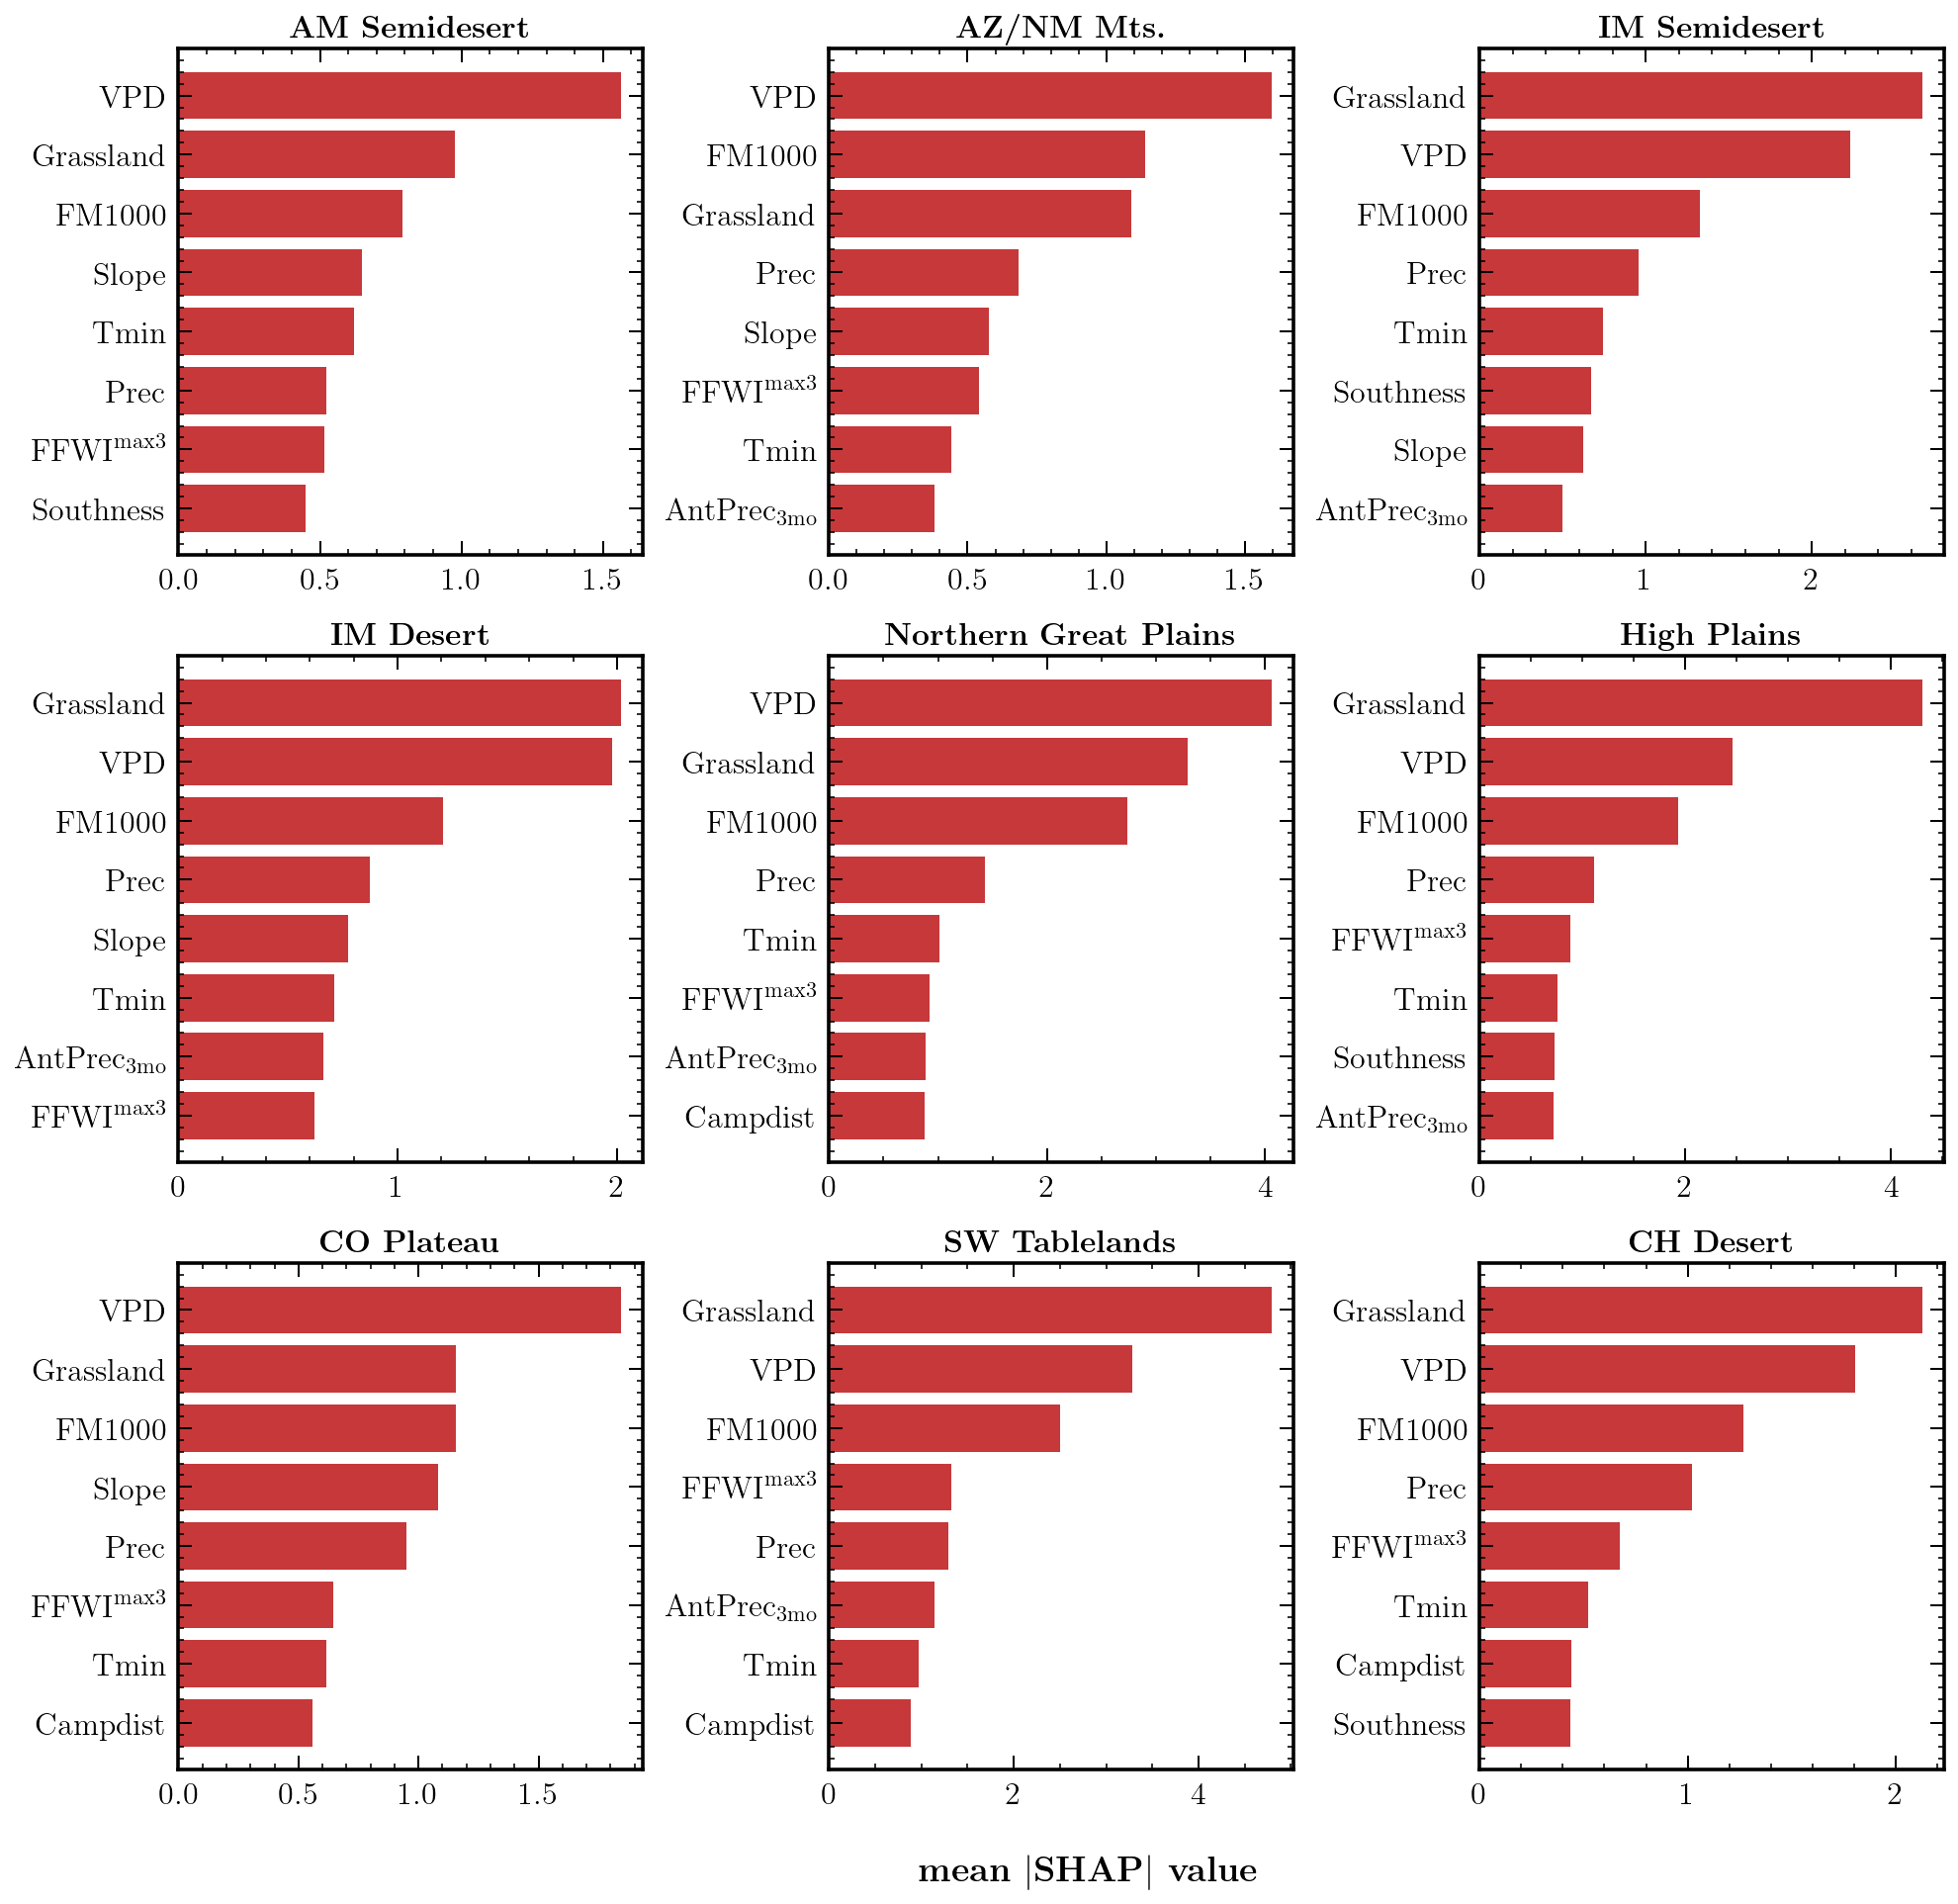

In [42]:
fig, ax= plt.subplots(3, 3, figsize= (16, 16))
shap_grid= [[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[10, 11, 12], [13, 14, 15], [16, 17, 18]]] 
for i in range(3):
    for j in range(3):
        regindx= shap_grid[1][i][j]
        ax[i, j].barh(X_plot_size_df.drop(columns= ['reg_indx']).columns[tmp_size_ind_vals[regindx -1]][-8:], np.sort(np.mean(np.array(abs(reg_size_shap_df.loc[X_plot_size_df.groupby('reg_indx').get_group(regindx).index])), axis= 0))[-8:])
        ax[i, j].set_title(r'{\bf %s}'%reg_name[regindx], va='center', fontsize= 16, pad= 10);
        fig.subplots_adjust(hspace= 0.2, wspace= 0.4)
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 16);
fig.text(0.45, 0.08, r'{\bf mean $|{\rm \bf SHAP}|$ value}', va='center', fontsize= 18);
#ax.set_xlabel(r'{\bf SHAP value}', fontsize= 20);
#plt.savefig('../paper_plots/shap_reg_size_summary_2.pdf', bbox_inches='tight', dpi= 300);

In [87]:
X_size_forest_df= pd.concat([X_plot_size_df.groupby('reg_indx').get_group(k) for k in (1+forest_reg_arr)], axis= 0)
forest_size_shap_arr= reg_size_shap_df.loc[X_size_forest_df.drop(columns= ['reg_indx']).index]

X_size_desert_df= pd.concat([X_plot_size_df.groupby('reg_indx').get_group(k) for k in (1+desert_reg_arr)], axis= 0)
desert_size_shap_arr= reg_size_shap_df.loc[X_size_desert_df.drop(columns= ['reg_indx']).index]

X_size_plain_df= pd.concat([X_plot_size_df.groupby('reg_indx').get_group(k) for k in (1+plain_reg_arr)], axis= 0)
plain_size_shap_arr= reg_size_shap_df.loc[X_size_plain_df.drop(columns= ['reg_indx']).index]

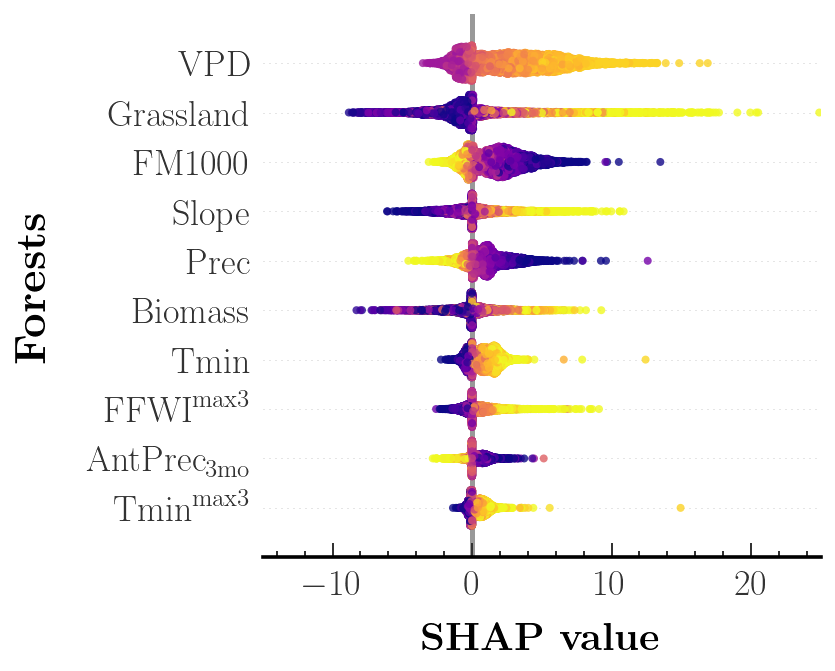

In [90]:
shap.summary_plot(np.array(forest_size_shap_arr), X_size_forest_df.drop(columns= ['reg_indx']), max_display= 10, plot_size= (5, 5), show= False, alpha= 0.8, color_bar= False, cmap= plt.cm.plasma)
fig, ax= plt.gcf(), plt.gca()
fig.text(-0.22, 0.5, r'{\bf Forests}', va='center', rotation= 'vertical', fontsize= 22);
ax.set_xlim(-15, 25);
ax.tick_params(labeltop=False, top=False, labelright=False, right=False, which='both', labelsize= 18);
ax.set_xlabel(r'{\bf SHAP value}', fontsize= 20);
#plt.colorbar(shrink= 0.9);
plt.clim(-3,3);
#plt.savefig('../paper_plots/shap_forest_size_summary.pdf', bbox_inches='tight', dpi= 300);

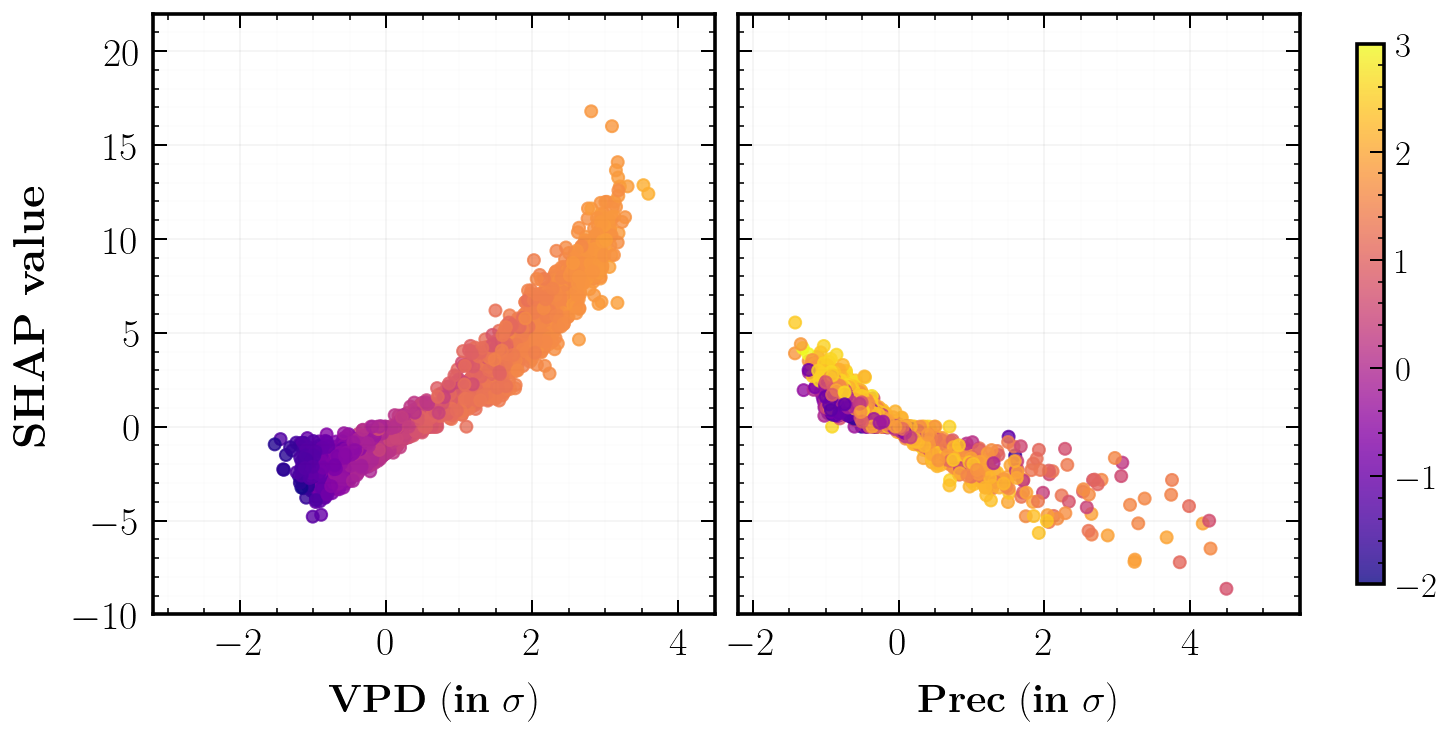

In [40]:
fig, ax= plt.subplots(1, 2, figsize= (10, 5) , constrained_layout= True)
CS0= ax[0].scatter(X_size_plain_df['VPD'], plain_size_shap_arr['VPD'], alpha=0.8, c= X_size_plain_df['Tmax'], cmap= plt.cm.plasma)
ax[0].set_xlabel(r'${\bf {\rm \bf VPD \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[0].set_ylim(-10, 22);
ax[0].set_xlim(-3.2, 4.5);
ax[0].set_ylabel(r'{\bf SHAP value}', fontsize= 22);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].scatter(X_size_plain_df['Prec'], plain_size_shap_arr['Prec'], alpha= 0.8, c= X_size_plain_df['Tmax'], cmap= plt.cm.plasma)
ax[1].set_xlabel(r'${\bf {\rm \bf Prec \ (in \ } \sigma {\rm \bf)}}$', fontsize= 20)
ax[1].set_ylim(-10, 22);
ax[1].set_xlim(-2.2, 5.5);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].set_yticklabels([]);
cbar= fig.colorbar(CS0, ax= ax[:], shrink= 0.9);
CS0.set_clim(-2,3);
#plt.savefig('../paper_plots/shap_plain_size_dependence.jpg', bbox_inches='tight', dpi= 300);

### 4.6 CDF: monthly burned area

In [123]:
obssizes_arr= []
predsizes_gpd_arr= []
predsizes_lognorm_gpd_arr= []
predsizes_data_arr= []

for r in tqdm(range(n_regions)):
    obssizes_arr.append(mon_burned_area(fire_file, r+1))
    predsizes_gpd_arr.append(np.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[0:break_month], \
                                               reg_gpd_ext_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[break_month:]))
    predsizes_lognorm_gpd_arr.append(np.append(reg_lognorm_gpd_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[0:break_month], \
                                               reg_lognorm_gpd_ext_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].iloc[break_month:]))
    predsizes_data_arr.append(reg_gpd_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'])

100%|███████████████████████████████████████████| 18/18 [00:09<00:00,  1.85it/s]


In [124]:
obssizes_arr= np.concatenate(obssizes_arr)
predsizes_gpd_arr= np.concatenate(predsizes_gpd_arr)
predsizes_lognorm_gpd_arr= np.concatenate(predsizes_lognorm_gpd_arr)
predsizes_data_arr= np.concatenate(predsizes_data_arr)
empcdf_obs= tfd.Empirical(obssizes_arr[obssizes_arr > 4])
empcdf_gpd_pred= tfd.Empirical(predsizes_gpd_arr[predsizes_gpd_arr > 4])
empcdf_lognorm_gpd_pred= tfd.Empirical(predsizes_lognorm_gpd_arr[predsizes_lognorm_gpd_arr > 4])
empcdf_data_pred= tfd.Empirical(predsizes_data_arr[predsizes_data_arr > 4])

cdf_emp_obs= empcdf_obs.cdf(obssizes_arr[obssizes_arr > 4])
cdf_emp_gpd_pred= empcdf_gpd_pred.cdf(predsizes_gpd_arr[predsizes_gpd_arr > 4])
cdf_emp_lognorm_gpd_pred= empcdf_lognorm_gpd_pred.cdf(predsizes_lognorm_gpd_arr[predsizes_lognorm_gpd_arr > 4])
cdf_emp_data_pred= empcdf_data_pred.cdf(predsizes_data_arr[predsizes_data_arr > 4])

# arr_1= np.sort(predsizes_gpd_arr)[np.nonzero(np.sort(predsizes_gpd_arr))[0]]
# arr_2= np.sort(predsizes_data_arr)[np.nonzero(np.sort(predsizes_data_arr))[0]]
# tot_arr= 10**(0.6*np.log10(arr_1) + 0.4*np.log10(arr_2))
# tot_arr= np.insert(tot_arr, 0, np.zeros(len(1- np.sort(cdf_emp_data_pred)) - len(tot_arr)))

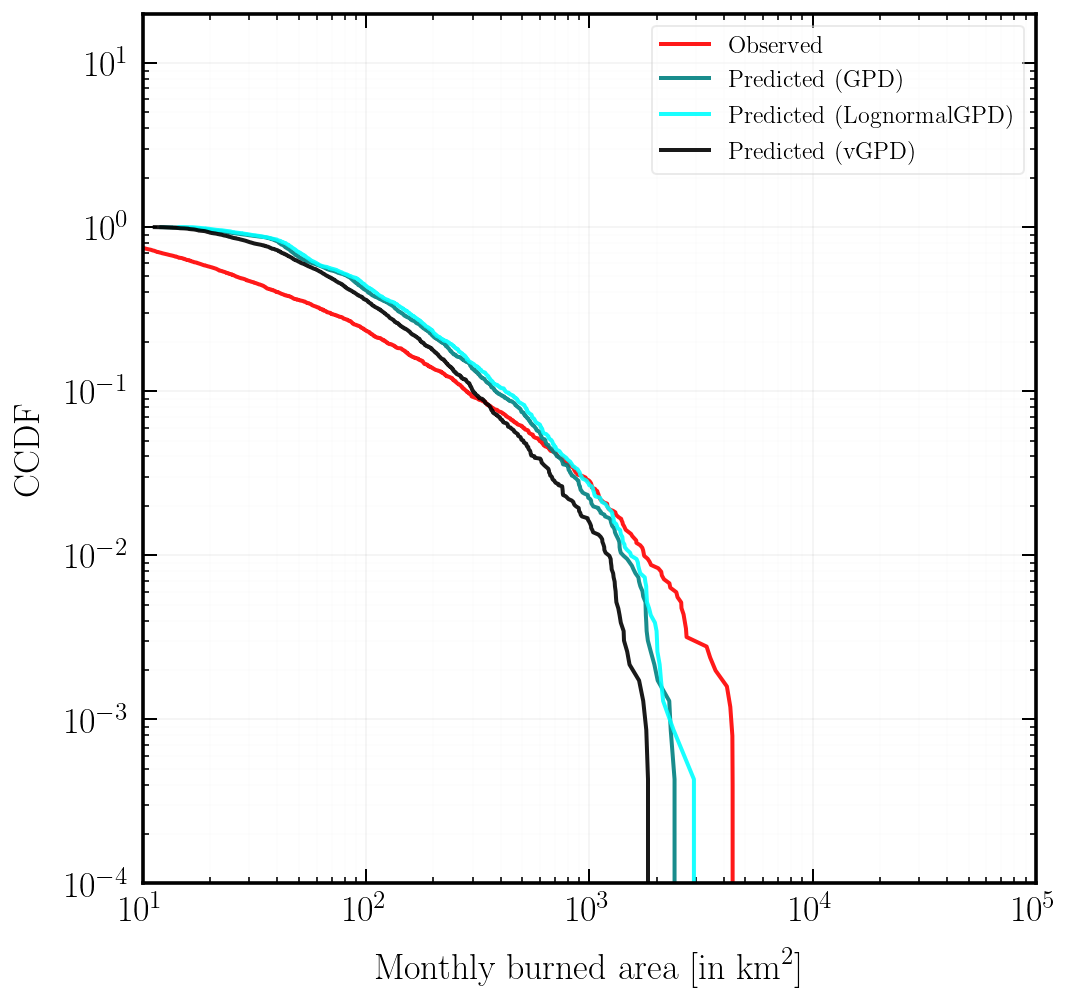

In [132]:
fig, ax= plt.subplots(figsize=(8, 8))

plt.plot(np.sort(obssizes_arr[obssizes_arr > 4]), 1 - np.sort(cdf_emp_obs), color= 'red', lw= 2, label= 'Observed')
plt.plot(np.sort(predsizes_gpd_arr[predsizes_gpd_arr > 4]), 1- np.sort(cdf_emp_gpd_pred), color= 'teal', lw= 2, label= 'Predicted (GPD)') 
plt.plot(np.sort(predsizes_lognorm_gpd_arr[predsizes_lognorm_gpd_arr > 4]), 1- np.sort(cdf_emp_lognorm_gpd_pred), color= 'cyan', lw= 2, label= 'Predicted (LognormalGPD)') 
plt.plot(np.sort(predsizes_data_arr[predsizes_data_arr > 4]), 1- np.sort(cdf_emp_data_pred), color= 'black', lw= 2, label= 'Predicted (vGPD)')
#plt.plot(np.sort(tot_arr), 1 - np.sort(cdf_emp_gpd_pred), color= 'purple', lw= 2, label= 'Predicted (Log mean)')

ax.set_xlabel(r'Monthly burned area [in ${\rm km}^2$]', fontsize= 18);
ax.set_ylabel(r'CCDF', fontsize= 18);

ax.set_ylim(10**-4, 20);
ax.set_xlim(10, 10**5);
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);
#plt.savefig('../plots/grid_fire_size_ccdf_%s.pdf'%size_id, bbox_inches='tight');

### 4.7 CDF: fire sizes

In [4]:
size_id= '06_14_22' #'04_17_22' 05_30_22
#mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
#mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_ext_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_lognorm_ext_size_model_%s'%size_id, \
                                                 custom_objects= {'lognorm_loss': lognorm_loss, 'lognorm_accuracy': lognorm_accuracy})
mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_lognorm_size_model_%s'%size_id, \
                                                 custom_objects= {'lognorm_loss': lognorm_gpd_loss, 'lognorm_accuracy': lognorm_gpd_accuracy})

In [5]:
n_features= 36
start_month= 252 #for test data
tot_test_months= 192 #180
end_month= start_month + tot_test_months

In [16]:
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test, size_scaler= fire_size_data(res= '12km', \
                                                dropcols= ['CAPE', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
                                                'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'], start_month= start_month, \
                                                tot_test_months= tot_test_months) #threshold= 4 'AvgVPD_2mo'

X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

100%|██████████| 8111/8111 [00:24<00:00, 329.49it/s]


#### Western US

In [17]:
regmodels_train, tot_fires_train= theoretical_cdf_func(fire_size_train, X_sizes_train_df, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= 252)
regmodels_test, tot_fires_test= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_mod, start_month= 252, final_month= 444) #final_month= 432
regmodels_ext_test, _= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_ext_mod, start_month= 252, final_month= 444)
regmodels_tot, tot_fires= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= 444)
regmodels_ext_tot, _= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_ext_mod, start_month= 0, final_month= 444)

100%|██████████| 18/18 [02:00<00:00,  6.72s/it]


In [19]:
sizearr_train= (fire_size_train.loc[1:tot_fires_train, 'fire_size']/1e6).to_numpy() #np.logspace(0, 5, tot_fires) #mon_burned_area(fire_file, 1).values
sizearr_test= (fire_size_test.loc[1:tot_fires_test, 'fire_size']/1e6).to_numpy()
sizearr_tot= (fire_size_tot.loc[1:tot_fires, 'fire_size']/1e6).to_numpy() 

empcdf_train= tfd.Empirical(sizearr_train)
cdf_emp_train= empcdf_train.cdf(sizearr_train)
empcdf_test= tfd.Empirical(sizearr_test)
cdf_emp_test= empcdf_test.cdf(sizearr_test)
empcdf_tot= tfd.Empirical(sizearr_tot)
cdf_emp_tot= empcdf_tot.cdf(sizearr_tot)

cdf_mod_train= tfd.BatchConcat(regmodels_train, axis= 0).cdf(sizearr_train)
cdf_mod_test= tfd.BatchConcat(regmodels_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_test))
cdf_mod_ext_test= tfd.BatchConcat(regmodels_ext_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_test))
cdf_mod_tot= tfd.BatchConcat(regmodels_tot, axis= 0).cdf(sizearr_tot)
cdf_mod_ext_tot= tfd.BatchConcat(regmodels_ext_tot, axis= 0).cdf(np.logspace(0, 5, tot_fires))
cdf_mod_comb_tot= tfd.BatchConcat(list(np.append(regmodels_train, regmodels_ext_test)), axis= 0).cdf(sizearr_tot[1:])

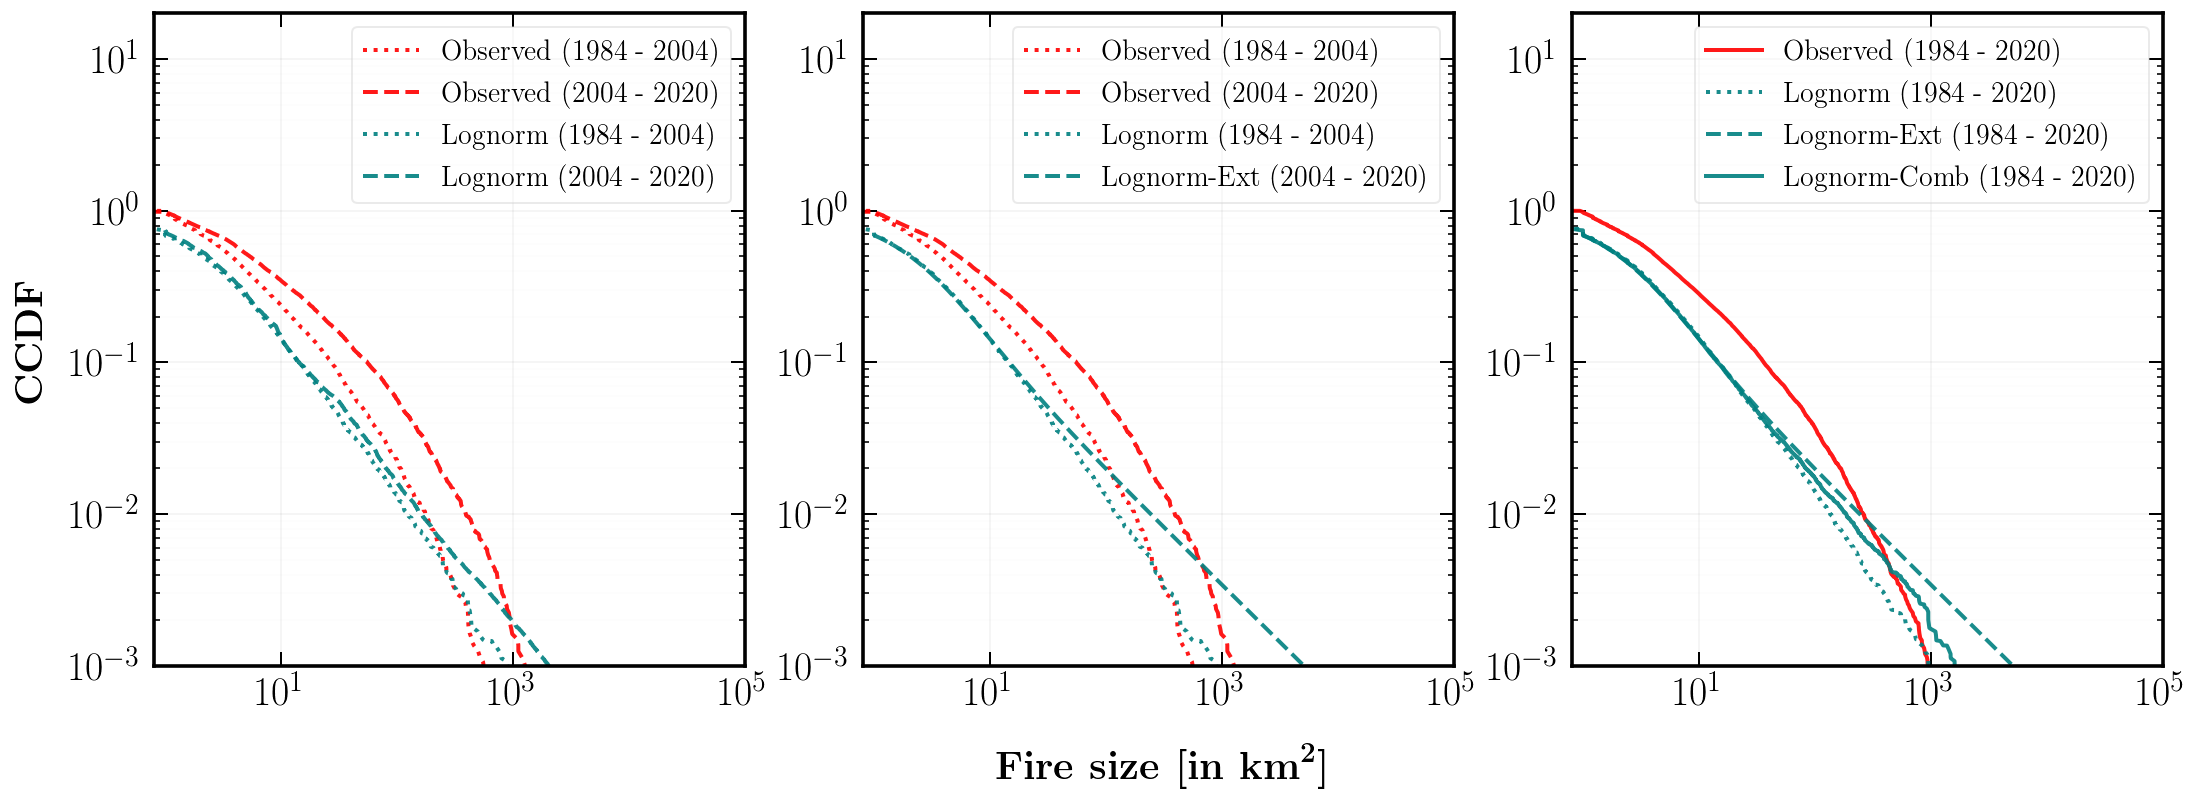

In [23]:
fig, ax= plt.subplots(1, 3, figsize=(18, 6))
fig.text(0.45, 0.01, r'{\bf Fire size [in ${\bf {\rm \bf km}^2}$]}', va='center', fontsize= 20);

loss_func= 'Lognorm'
ax[0].plot(np.sort(sizearr_train), 1 - np.sort(cdf_emp_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[0].plot(np.sort(sizearr_test), 1 - np.sort(cdf_emp_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2020)')
ax[0].plot(np.sort(sizearr_train), 1 - np.sort(cdf_mod_train), color= 'teal', lw= 2, linestyle= 'dotted', label= '%s (1984 - 2004)'%loss_func)
ax[0].plot(np.logspace(0, 5, tot_fires_test), 1 - np.sort(cdf_mod_test), color= 'teal', lw= 2, linestyle= 'dashed', label= '%s (2004 - 2020)'%loss_func)

#ax[0].set_xlabel(r'{\bf Fire size [in ${\bf {\rm \bf km}^2}$]}', fontsize= 20);
ax[0].set_ylabel(r'{\bf CCDF}', fontsize= 20);
ax[0].set_ylim(10**-3, 20);
ax[0].set_xlim(0.8, 10**5);
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on();
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[0].legend(loc='upper right', frameon=True, fontsize= 14);

ax[1].plot(np.sort(sizearr_train), 1 - np.sort(cdf_emp_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[1].plot(np.sort(sizearr_test), 1 - np.sort(cdf_emp_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2020)')
ax[1].plot(np.sort(sizearr_train), 1 - np.sort(cdf_mod_train), color= 'teal', lw= 2, linestyle= 'dotted', label= '%s (1984 - 2004)'%loss_func)
ax[1].plot(np.logspace(0, 5, tot_fires_test), 1 - np.sort(cdf_mod_ext_test), color= 'teal', lw= 2, linestyle= 'dashed', label= '%s-Ext (2004 - 2020)'%loss_func)

#ax[1].set_xlabel(r'{\bf Fire size [in ${\bf {\rm \bf km}^2}$]}', fontsize= 20);
ax[1].set_ylim(10**-3, 20);
ax[1].set_xlim(0.8, 10**5);
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].minorticks_on();
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].legend(loc='upper right', frameon=True, fontsize= 14);

ax[2].plot(np.sort(sizearr_tot), 1 - np.sort(cdf_emp_tot), color= 'red', lw= 2, label= 'Observed (1984 - 2020)')
ax[2].plot(np.sort(sizearr_tot), 1 - np.sort(cdf_mod_tot), color= 'teal', lw= 2, linestyle= 'dotted', label= '%s (1984 - 2020)'%loss_func)
ax[2].plot(np.logspace(0, 5, tot_fires), 1 - np.sort(cdf_mod_ext_tot), color= 'teal', lw= 2, linestyle= 'dashed', label= '%s-Ext (1984 - 2020)'%loss_func)
ax[2].plot(np.sort(sizearr_tot[0:]), 1 - np.sort(cdf_mod_comb_tot), color= 'teal', lw= 2, label= '%s-Comb (1984 - 2020)'%loss_func)

#ax[2].set_xlabel(r'{\bf Fire size [in ${\bf {\rm \bf km}^2}$]}', fontsize= 20);
ax[2].set_ylim(10**-3, 20);
ax[2].set_xlim(0.8, 10**5);
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].minorticks_on();
ax[2].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 20);
ax[2].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[2].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[2].legend(loc='upper right', frameon=True, fontsize= 14);

#plt.suptitle(r'Threshold = 4 ${\rm km}^2$', fontsize= 18);
#plt.savefig('../paper_plots/fire_lognorm_size_ccdf_b2004_%s.pdf'%size_id, bbox_inches='tight');

#### Regional CDFs

In [38]:
rindx= 14
regmodels_ims_train, tot_fires_ims_train= theoretical_cdf_func(fire_size_train, X_sizes_train_df, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= break_month, regmode= True, regindx= rindx)
regmodels_ims_test, tot_fires_ims_test= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_mod, start_month= break_month, final_month= 432, regmode= True, regindx= rindx)
regmodels_ims_ext_test, _= theoretical_cdf_func(fire_size_test, X_sizes_test, mdn_mod= mdn_gpd_ext_mod, start_month= break_month, final_month= 432, regmode= True, regindx= rindx)
regmodels_ims_tot, tot_ims_fires= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_mod, start_month= 0, final_month= 432, regmode= True, regindx= rindx)
regmodels_ims_ext_tot, _= theoretical_cdf_func(fire_size_tot, X_sizes_tot, mdn_mod= mdn_gpd_ext_mod, start_month= 0, final_month= 432, regmode= True, regindx= rindx)

In [39]:
sizearr_ims_train= (fire_size_train.groupby('reg_indx').get_group(rindx)['fire_size']/1e6).to_numpy()
sizearr_ims_test= (fire_size_test.groupby('reg_indx').get_group(rindx)['fire_size']/1e6).to_numpy()
sizearr_ims_tot= (fire_size_tot.groupby('reg_indx').get_group(rindx)['fire_size']/1e6).to_numpy()

empcdf_ims_train= tfd.Empirical(sizearr_ims_train)
cdf_emp_ims_train= empcdf_ims_train.cdf(sizearr_ims_train)
empcdf_ims_test= tfd.Empirical(sizearr_ims_test)
cdf_emp_ims_test= empcdf_ims_test.cdf(sizearr_ims_test)
empcdf_ims_tot= tfd.Empirical(sizearr_ims_tot)
cdf_emp_ims_tot= empcdf_ims_tot.cdf(sizearr_ims_tot)

cdf_mod_ims_train= tfd.BatchConcat(regmodels_ims_train, axis= 0).cdf(sizearr_ims_train)
cdf_mod_ims_test= tfd.BatchConcat(regmodels_ims_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_ims_test))
cdf_mod_ims_ext_test= tfd.BatchConcat(regmodels_ims_ext_test, axis= 0).cdf(np.logspace(0, 5, tot_fires_ims_test))
cdf_mod_ims_tot= tfd.BatchConcat(regmodels_ims_tot, axis= 0).cdf(sizearr_ims_tot)
cdf_mod_ims_ext_tot= tfd.BatchConcat(regmodels_ims_ext_tot, axis= 0).cdf(np.logspace(0, 5, tot_ims_fires))
cdf_mod_ims_comb_tot= tfd.BatchConcat(list(np.append(regmodels_ims_train, regmodels_ims_ext_test)), axis= 0).cdf(sizearr_ims_tot)

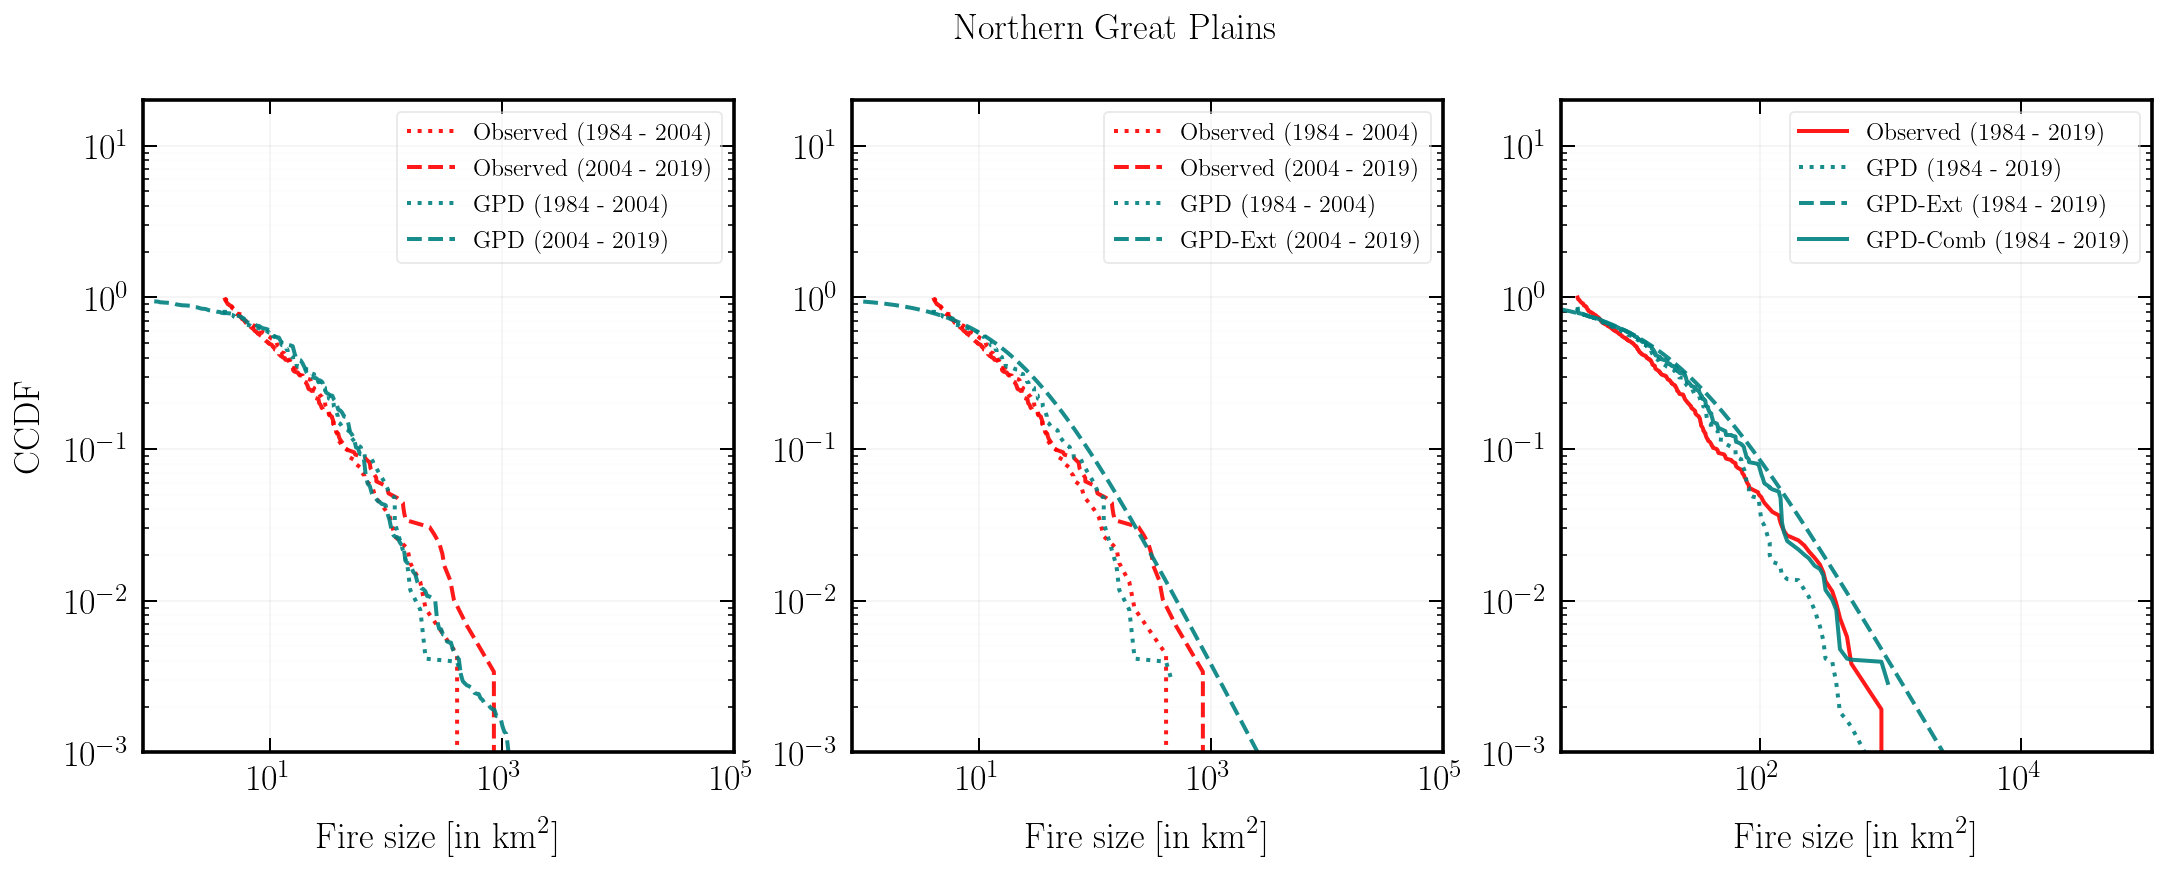

In [40]:
fig, ax= plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_emp_ims_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[0].plot(np.sort(sizearr_ims_test), 1 - np.sort(cdf_emp_ims_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2019)')
ax[0].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_mod_ims_train), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2004)')
ax[0].plot(np.logspace(0, 5, tot_fires_ims_test), 1 - np.sort(cdf_mod_ims_test), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD (2004 - 2019)')

ax[0].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[0].set_ylabel(r'CCDF', fontsize= 18);
ax[0].set_ylim(10**-3, 20);
ax[0].set_xlim(0.8, 10**5);
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].minorticks_on();
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[0].legend(loc='upper right', frameon=True, fontsize=12);

ax[1].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_emp_ims_train), color= 'red', lw= 2, linestyle= 'dotted', label= 'Observed (1984 - 2004)')
ax[1].plot(np.sort(sizearr_ims_test), 1 - np.sort(cdf_emp_ims_test), color= 'red', lw= 2, linestyle= 'dashed', label= 'Observed (2004 - 2019)')
ax[1].plot(np.sort(sizearr_ims_train), 1 - np.sort(cdf_mod_ims_train), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2004)')
ax[1].plot(np.logspace(0, 5, tot_fires_ims_test), 1 - np.sort(cdf_mod_ims_ext_test), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD-Ext (2004 - 2019)')

ax[1].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[1].set_ylim(10**-3, 20);
ax[1].set_xlim(0.8, 10**5);
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].minorticks_on();
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[1].legend(loc='upper right', frameon=True, fontsize=12);

ax[2].plot(np.sort(sizearr_ims_tot), 1 - np.sort(cdf_emp_ims_tot), color= 'red', lw= 2, label= 'Observed (1984 - 2019)')
ax[2].plot(np.sort(sizearr_ims_tot), 1 - np.sort(cdf_mod_ims_tot), color= 'teal', lw= 2, linestyle= 'dotted', label= 'GPD (1984 - 2019)')
ax[2].plot(np.logspace(0, 5, tot_ims_fires), 1 - np.sort(cdf_mod_ims_ext_tot), color= 'teal', lw= 2, linestyle= 'dashed', label= 'GPD-Ext (1984 - 2019)')
ax[2].plot(np.sort(sizearr_ims_tot), 1 - np.sort(cdf_mod_ims_comb_tot), color= 'teal', lw= 2, label= 'GPD-Comb (1984 - 2019)')

ax[2].set_xlabel(r'Fire size [in ${\rm km}^2$]', fontsize= 18);
ax[2].set_ylim(10**-3, 20);
ax[2].set_xlim(3, 10**5);
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].minorticks_on();
ax[2].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax[2].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[2].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax[2].legend(loc='upper right', frameon=True, fontsize=12);

plt.suptitle(r'${\rm Northern \ Great \ Plains}$', fontsize= 18);
#plt.savefig('../plots/fire_size_ccdf_b2009_%s.pdf'%size_id, bbox_inches='tight');

## Sanity check

In [40]:
tmparr= np.random.choice(np.nonzero(freq_arr[6])[0], (np.sum(freq_arr[6])*(np.std(reg_freq_groups.get_group(1)['obs_freq'])/np.std(pred_freq))).astype(int))

In [41]:
X_test_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']).index.to_numpy()[tmparr]

array([3746133, 3741808, 3750194, 3741511, 3748828, 3749649, 3742959])

In [13]:
dnn_freq_df= pd.read_hdf('../sav_files/dnn_mon_fire_freq_03_01_22_it_12_8192_0.3.h5')
dnn_freq_groups= dnn_freq_df.groupby('reg_indx')

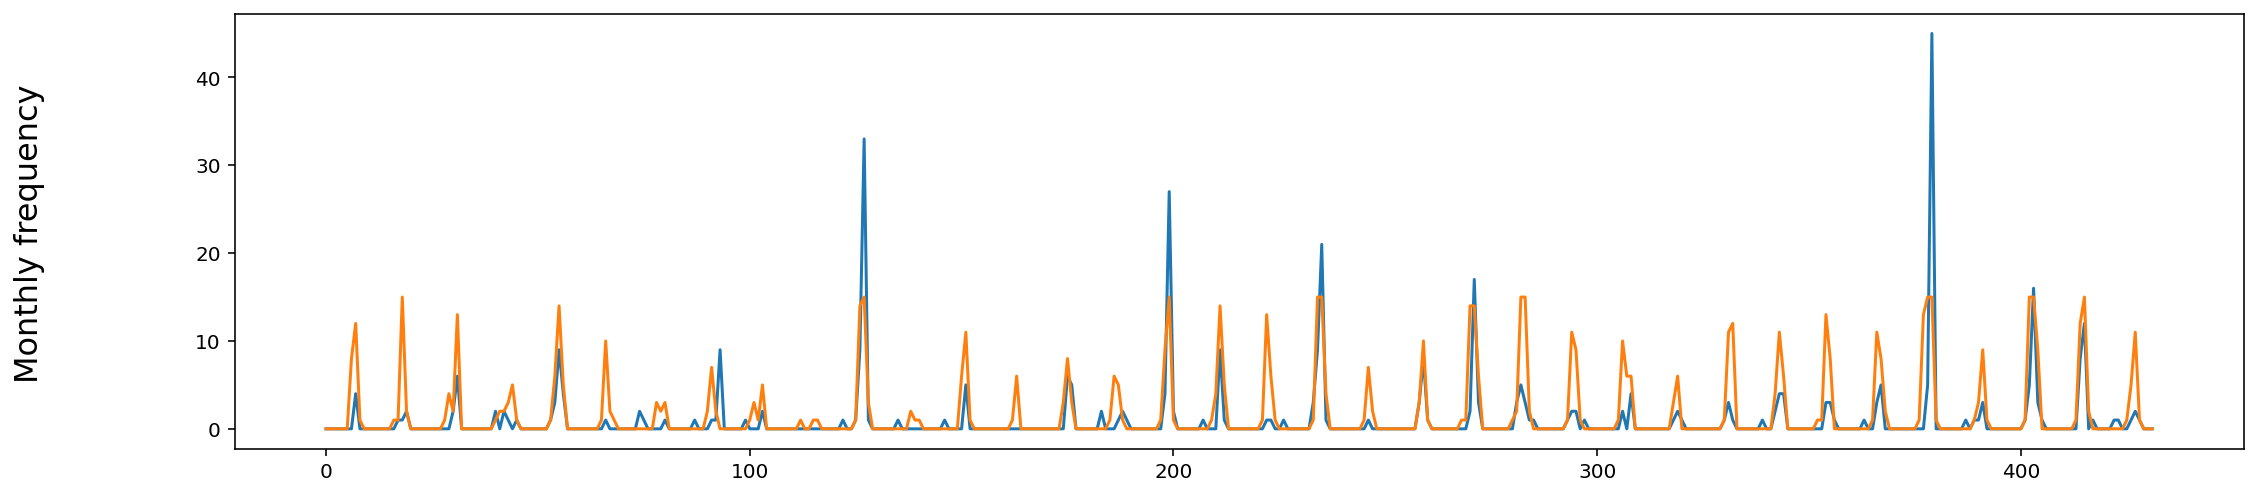

In [24]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 7

plt.plot(month_arr, dnn_freq_groups.get_group(regindx)['obs_freq'])
plt.plot(month_arr, dnn_freq_groups.get_group(regindx)['pred_mean_freq']);
#plt.fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)

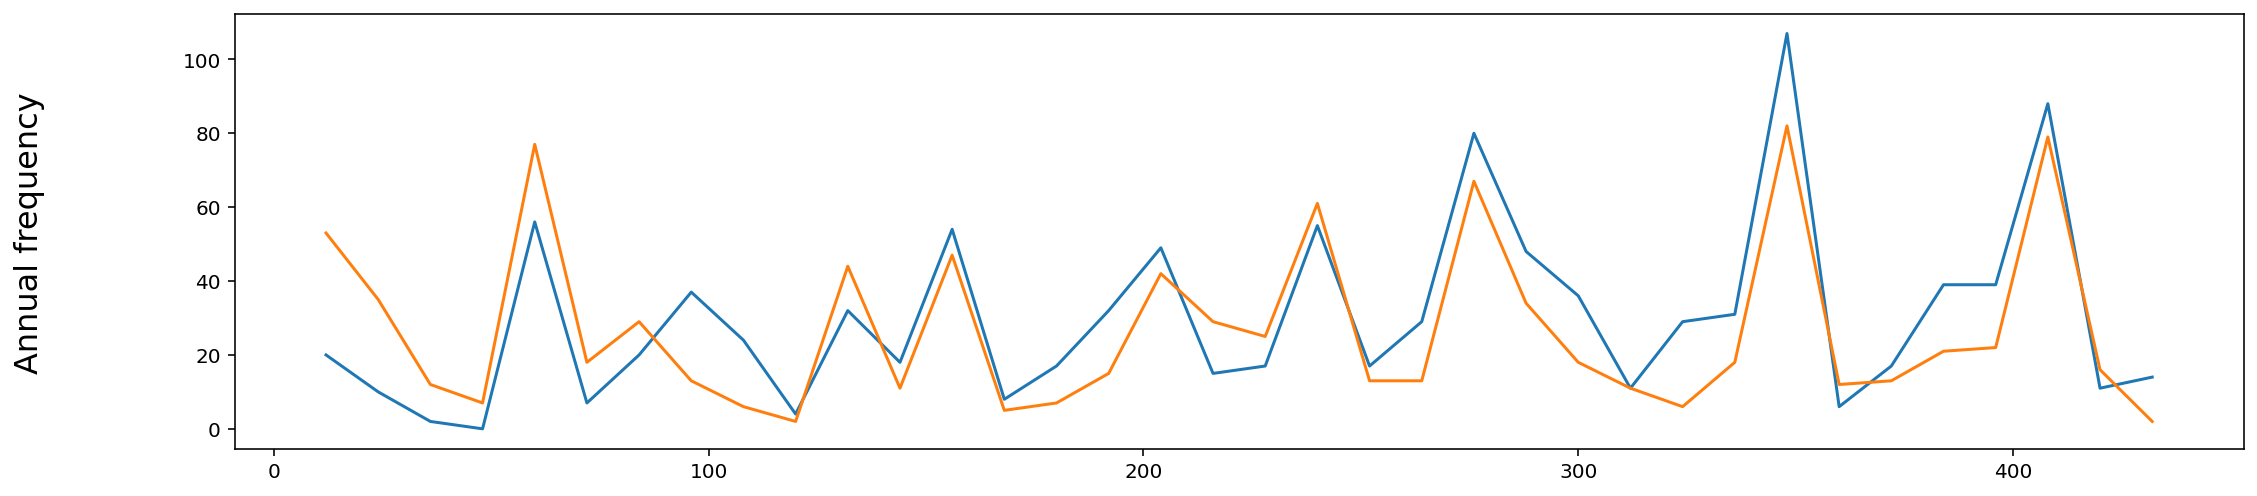

In [23]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 14

#pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
#                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)])  
pred_freq= np.array([np.sum(dnn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])

plt.plot(yr_arr[1:], np.array([np.sum(dnn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]));
plt.plot(yr_arr[1:], pred_freq);
#plt.fill_between(yr_arr[1:], pred_freq + 2*pred_std, pred_freq - 2*pred_std, color= 'orange', alpha= 0.3)